In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(831136, 828)
(831136, 8)
validation
(101248, 828)
(101248, 8)
test
(98888, 828)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/84 [..............................] - ETA: 1:57 - loss: 1.8853 - STD: 0.0533 - MAE: 0.2094

 4/84 [>.............................] - ETA: 2s - loss: 1.5373 - STD: 0.1514 - MAE: 0.1644  

 5/84 [>.............................] - ETA: 2s - loss: 1.5083 - STD: 0.1701 - MAE: 0.1567

 6/84 [=>............................] - ETA: 3s - loss: 1.4861 - STD: 0.1820 - MAE: 0.1518

 7/84 [=>............................] - ETA: 3s - loss: 1.4616 - STD: 0.1888 - MAE: 0.1486

 8/84 [=>............................] - ETA: 3s - loss: 1.4440 - STD: 0.1918 - MAE: 0.1472

 9/84 [==>...........................] - ETA: 3s - loss: 1.4290 - STD: 0.1920 - MAE: 0.1468

10/84 [==>...........................] - ETA: 3s - loss: 1.4204 - STD: 0.1906 - MAE: 0.1473

11/84 [==>...........................] - ETA: 3s - loss: 1.4132 - STD: 0.1885 - MAE: 0.1480

12/84 [===>..........................] - ETA: 3s - loss: 1.4090 - STD: 0.1865 - MAE: 0.1488

13/84 [===>..........................] - ETA: 3s - loss: 1.4031 - STD: 0.1850 - MAE: 0.1493

14/84 [====>.........................] - ETA: 3s - loss: 1.3987 - STD: 0.1842 - MAE: 0.1496

15/84 [====>.........................] - ETA: 3s - loss: 1.3950 - STD: 0.1840 - MAE: 0.1496

16/84 [====>.........................] - ETA: 3s - loss: 1.3911 - STD: 0.1846 - MAE: 0.1493

17/84 [=====>........................] - ETA: 3s - loss: 1.3869 - STD: 0.1855 - MAE: 0.1488

18/84 [=====>........................] - ETA: 3s - loss: 1.3840 - STD: 0.1868 - MAE: 0.1483

19/84 [=====>........................] - ETA: 3s - loss: 1.3816 - STD: 0.1882 - MAE: 0.1477

20/84 [======>.......................] - ETA: 3s - loss: 1.3778 - STD: 0.1895 - MAE: 0.1471

21/84 [======>.......................] - ETA: 3s - loss: 1.3747 - STD: 0.1907 - MAE: 0.1466

22/84 [======>.......................] - ETA: 3s - loss: 1.3727 - STD: 0.1916 - MAE: 0.1462

23/84 [=======>......................] - ETA: 3s - loss: 1.3694 - STD: 0.1923 - MAE: 0.1458

24/84 [=======>......................] - ETA: 3s - loss: 1.3670 - STD: 0.1927 - MAE: 0.1456

25/84 [=======>......................] - ETA: 3s - loss: 1.3644 - STD: 0.1927 - MAE: 0.1455

26/84 [========>.....................] - ETA: 3s - loss: 1.3622 - STD: 0.1926 - MAE: 0.1455

27/84 [========>.....................] - ETA: 3s - loss: 1.3601 - STD: 0.1924 - MAE: 0.1456

28/84 [=========>....................] - ETA: 3s - loss: 1.3584 - STD: 0.1920 - MAE: 0.1457

29/84 [=========>....................] - ETA: 3s - loss: 1.3570 - STD: 0.1917 - MAE: 0.1458

30/84 [=========>....................] - ETA: 3s - loss: 1.3558 - STD: 0.1914 - MAE: 0.1459

31/84 [==========>...................] - ETA: 3s - loss: 1.3551 - STD: 0.1911 - MAE: 0.1460

32/84 [==========>...................] - ETA: 2s - loss: 1.3538 - STD: 0.1910 - MAE: 0.1460

33/84 [==========>...................] - ETA: 2s - loss: 1.3522 - STD: 0.1909 - MAE: 0.1460

34/84 [===========>..................] - ETA: 2s - loss: 1.3506 - STD: 0.1910 - MAE: 0.1460

35/84 [===========>..................] - ETA: 2s - loss: 1.3494 - STD: 0.1911 - MAE: 0.1459

36/84 [===========>..................] - ETA: 2s - loss: 1.3483 - STD: 0.1912 - MAE: 0.1458

37/84 [============>.................] - ETA: 2s - loss: 1.3472 - STD: 0.1914 - MAE: 0.1457

38/84 [============>.................] - ETA: 2s - loss: 1.3463 - STD: 0.1916 - MAE: 0.1457

39/84 [============>.................] - ETA: 2s - loss: 1.3455 - STD: 0.1917 - MAE: 0.1456

40/84 [=============>................] - ETA: 2s - loss: 1.3448 - STD: 0.1918 - MAE: 0.1456

41/84 [=============>................] - ETA: 2s - loss: 1.3442 - STD: 0.1919 - MAE: 0.1455

42/84 [==============>...............] - ETA: 2s - loss: 1.3433 - STD: 0.1919 - MAE: 0.1455

43/84 [==============>...............] - ETA: 2s - loss: 1.3425 - STD: 0.1918 - MAE: 0.1455

44/84 [==============>...............] - ETA: 2s - loss: 1.3418 - STD: 0.1917 - MAE: 0.1456

45/84 [===============>..............] - ETA: 2s - loss: 1.3412 - STD: 0.1916 - MAE: 0.1456

46/84 [===============>..............] - ETA: 2s - loss: 1.3411 - STD: 0.1914 - MAE: 0.1457

47/84 [===============>..............] - ETA: 2s - loss: 1.3405 - STD: 0.1914 - MAE: 0.1457

48/84 [================>.............] - ETA: 2s - loss: 1.3399 - STD: 0.1913 - MAE: 0.1457

49/84 [================>.............] - ETA: 2s - loss: 1.3387 - STD: 0.1912 - MAE: 0.1457

50/84 [================>.............] - ETA: 1s - loss: 1.3386 - STD: 0.1912 - MAE: 0.1457

51/84 [=================>............] - ETA: 1s - loss: 1.3377 - STD: 0.1912 - MAE: 0.1457

52/84 [=================>............] - ETA: 1s - loss: 1.3372 - STD: 0.1913 - MAE: 0.1456

53/84 [=================>............] - ETA: 1s - loss: 1.3363 - STD: 0.1914 - MAE: 0.1456

54/84 [==================>...........] - ETA: 1s - loss: 1.3356 - STD: 0.1914 - MAE: 0.1455

55/84 [==================>...........] - ETA: 1s - loss: 1.3347 - STD: 0.1915 - MAE: 0.1455

56/84 [===================>..........] - ETA: 1s - loss: 1.3344 - STD: 0.1916 - MAE: 0.1455

57/84 [===================>..........] - ETA: 1s - loss: 1.3338 - STD: 0.1916 - MAE: 0.1454

58/84 [===================>..........] - ETA: 1s - loss: 1.3331 - STD: 0.1916 - MAE: 0.1454

59/84 [====================>.........] - ETA: 1s - loss: 1.3323 - STD: 0.1916 - MAE: 0.1454

60/84 [====================>.........] - ETA: 1s - loss: 1.3316 - STD: 0.1916 - MAE: 0.1454

61/84 [====================>.........] - ETA: 1s - loss: 1.3311 - STD: 0.1916 - MAE: 0.1454

62/84 [=====================>........] - ETA: 1s - loss: 1.3307 - STD: 0.1916 - MAE: 0.1454

63/84 [=====================>........] - ETA: 1s - loss: 1.3301 - STD: 0.1916 - MAE: 0.1453

64/84 [=====================>........] - ETA: 1s - loss: 1.3296 - STD: 0.1916 - MAE: 0.1453

65/84 [======================>.......] - ETA: 1s - loss: 1.3293 - STD: 0.1916 - MAE: 0.1453

66/84 [======================>.......] - ETA: 1s - loss: 1.3283 - STD: 0.1916 - MAE: 0.1452

67/84 [======================>.......] - ETA: 0s - loss: 1.3278 - STD: 0.1916 - MAE: 0.1452

68/84 [=======================>......] - ETA: 0s - loss: 1.3273 - STD: 0.1916 - MAE: 0.1452

69/84 [=======================>......] - ETA: 0s - loss: 1.3267 - STD: 0.1916 - MAE: 0.1452

70/84 [========================>.....] - ETA: 0s - loss: 1.3260 - STD: 0.1916 - MAE: 0.1452

71/84 [========================>.....] - ETA: 0s - loss: 1.3259 - STD: 0.1916 - MAE: 0.1452

75/84 [=========================>....] - ETA: 0s - loss: 1.3231 - STD: 0.1916 - MAE: 0.1450

76/84 [==========================>...] - ETA: 0s - loss: 1.3224 - STD: 0.1917 - MAE: 0.1450

77/84 [==========================>...] - ETA: 0s - loss: 1.3217 - STD: 0.1917 - MAE: 0.1450

78/84 [==========================>...] - ETA: 0s - loss: 1.3208 - STD: 0.1917 - MAE: 0.1449

79/84 [===========================>..] - ETA: 0s - loss: 1.3198 - STD: 0.1917 - MAE: 0.1449

80/84 [===========================>..] - ETA: 0s - loss: 1.3190 - STD: 0.1918 - MAE: 0.1448

81/84 [===========================>..] - ETA: 0s - loss: 1.3185 - STD: 0.1919 - MAE: 0.1448

82/84 [============================>.] - ETA: 0s - loss: 1.3177 - STD: 0.1920 - MAE: 0.1447

83/84 [============================>.] - ETA: 0s - loss: 1.3170 - STD: 0.1920 - MAE: 0.1447

84/84 [==============================] - ETA: 0s - loss: 1.3160 - STD: 0.1921 - MAE: 0.1446

84/84 [==============================] - 7s 72ms/step - loss: 1.3160 - STD: 0.1921 - MAE: 0.1446 - val_loss: 1.2010 - val_STD: 0.1927 - val_MAE: 0.1408


Epoch 2/10000


 1/84 [..............................] - ETA: 7s - loss: 1.2522 - STD: 0.1957 - MAE: 0.1411

 2/84 [..............................] - ETA: 5s - loss: 1.2454 - STD: 0.1990 - MAE: 0.1397

 3/84 [>.............................] - ETA: 5s - loss: 1.2443 - STD: 0.2004 - MAE: 0.1393

 4/84 [>.............................] - ETA: 5s - loss: 1.2396 - STD: 0.1999 - MAE: 0.1392

 5/84 [>.............................] - ETA: 4s - loss: 1.2394 - STD: 0.1983 - MAE: 0.1398

 6/84 [=>............................] - ETA: 4s - loss: 1.2392 - STD: 0.1975 - MAE: 0.1401

 7/84 [=>............................] - ETA: 4s - loss: 1.2358 - STD: 0.1978 - MAE: 0.1399

 8/84 [=>............................] - ETA: 4s - loss: 1.2347 - STD: 0.1984 - MAE: 0.1395

 9/84 [==>...........................] - ETA: 4s - loss: 1.2328 - STD: 0.1991 - MAE: 0.1392

10/84 [==>...........................] - ETA: 4s - loss: 1.2329 - STD: 0.1991 - MAE: 0.1393

11/84 [==>...........................] - ETA: 4s - loss: 1.2319 - STD: 0.1987 - MAE: 0.1394

12/84 [===>..........................] - ETA: 4s - loss: 1.2312 - STD: 0.1984 - MAE: 0.1396

13/84 [===>..........................] - ETA: 4s - loss: 1.2306 - STD: 0.1983 - MAE: 0.1396

14/84 [====>.........................] - ETA: 4s - loss: 1.2286 - STD: 0.1986 - MAE: 0.1394

15/84 [====>.........................] - ETA: 4s - loss: 1.2276 - STD: 0.1987 - MAE: 0.1393

16/84 [====>.........................] - ETA: 4s - loss: 1.2260 - STD: 0.1986 - MAE: 0.1393

17/84 [=====>........................] - ETA: 4s - loss: 1.2244 - STD: 0.1985 - MAE: 0.1393

18/84 [=====>........................] - ETA: 4s - loss: 1.2230 - STD: 0.1985 - MAE: 0.1392

19/84 [=====>........................] - ETA: 4s - loss: 1.2206 - STD: 0.1987 - MAE: 0.1390

20/84 [======>.......................] - ETA: 3s - loss: 1.2198 - STD: 0.1990 - MAE: 0.1389

21/84 [======>.......................] - ETA: 3s - loss: 1.2182 - STD: 0.1992 - MAE: 0.1388

22/84 [======>.......................] - ETA: 3s - loss: 1.2169 - STD: 0.1993 - MAE: 0.1387

23/84 [=======>......................] - ETA: 3s - loss: 1.2161 - STD: 0.1993 - MAE: 0.1387

24/84 [=======>......................] - ETA: 3s - loss: 1.2149 - STD: 0.1994 - MAE: 0.1386

25/84 [=======>......................] - ETA: 3s - loss: 1.2140 - STD: 0.1995 - MAE: 0.1386

26/84 [========>.....................] - ETA: 3s - loss: 1.2129 - STD: 0.1994 - MAE: 0.1386

27/84 [========>.....................] - ETA: 3s - loss: 1.2126 - STD: 0.1993 - MAE: 0.1386

28/84 [=========>....................] - ETA: 3s - loss: 1.2105 - STD: 0.1993 - MAE: 0.1385

29/84 [=========>....................] - ETA: 3s - loss: 1.2093 - STD: 0.1994 - MAE: 0.1384

30/84 [=========>....................] - ETA: 3s - loss: 1.2079 - STD: 0.1995 - MAE: 0.1384

31/84 [==========>...................] - ETA: 3s - loss: 1.2065 - STD: 0.1996 - MAE: 0.1383

32/84 [==========>...................] - ETA: 3s - loss: 1.2053 - STD: 0.1998 - MAE: 0.1381

33/84 [==========>...................] - ETA: 3s - loss: 1.2044 - STD: 0.2000 - MAE: 0.1381

34/84 [===========>..................] - ETA: 3s - loss: 1.2032 - STD: 0.1999 - MAE: 0.1381

35/84 [===========>..................] - ETA: 3s - loss: 1.2029 - STD: 0.2000 - MAE: 0.1380

36/84 [===========>..................] - ETA: 3s - loss: 1.2022 - STD: 0.1999 - MAE: 0.1380

37/84 [============>.................] - ETA: 2s - loss: 1.2007 - STD: 0.1998 - MAE: 0.1380

38/84 [============>.................] - ETA: 2s - loss: 1.1994 - STD: 0.1999 - MAE: 0.1380

39/84 [============>.................] - ETA: 2s - loss: 1.1978 - STD: 0.1999 - MAE: 0.1379

40/84 [=============>................] - ETA: 2s - loss: 1.1969 - STD: 0.1998 - MAE: 0.1379

41/84 [=============>................] - ETA: 2s - loss: 1.1960 - STD: 0.1999 - MAE: 0.1379

42/84 [==============>...............] - ETA: 2s - loss: 1.1949 - STD: 0.2002 - MAE: 0.1377

43/84 [==============>...............] - ETA: 2s - loss: 1.1935 - STD: 0.2002 - MAE: 0.1377

44/84 [==============>...............] - ETA: 2s - loss: 1.1921 - STD: 0.2002 - MAE: 0.1377

45/84 [===============>..............] - ETA: 2s - loss: 1.1909 - STD: 0.2003 - MAE: 0.1376

46/84 [===============>..............] - ETA: 2s - loss: 1.1897 - STD: 0.2004 - MAE: 0.1375

47/84 [===============>..............] - ETA: 2s - loss: 1.1886 - STD: 0.2003 - MAE: 0.1375

48/84 [================>.............] - ETA: 2s - loss: 1.1874 - STD: 0.2004 - MAE: 0.1374

49/84 [================>.............] - ETA: 2s - loss: 1.1863 - STD: 0.2005 - MAE: 0.1374

50/84 [================>.............] - ETA: 2s - loss: 1.1851 - STD: 0.2005 - MAE: 0.1373

51/84 [=================>............] - ETA: 2s - loss: 1.1838 - STD: 0.2005 - MAE: 0.1373

52/84 [=================>............] - ETA: 1s - loss: 1.1826 - STD: 0.2006 - MAE: 0.1372

53/84 [=================>............] - ETA: 1s - loss: 1.1815 - STD: 0.2007 - MAE: 0.1371

54/84 [==================>...........] - ETA: 1s - loss: 1.1804 - STD: 0.2007 - MAE: 0.1371

55/84 [==================>...........] - ETA: 1s - loss: 1.1794 - STD: 0.2008 - MAE: 0.1371

56/84 [===================>..........] - ETA: 1s - loss: 1.1782 - STD: 0.2008 - MAE: 0.1370

57/84 [===================>..........] - ETA: 1s - loss: 1.1770 - STD: 0.2008 - MAE: 0.1370

58/84 [===================>..........] - ETA: 1s - loss: 1.1759 - STD: 0.2009 - MAE: 0.1369

59/84 [====================>.........] - ETA: 1s - loss: 1.1748 - STD: 0.2009 - MAE: 0.1369

60/84 [====================>.........] - ETA: 1s - loss: 1.1738 - STD: 0.2010 - MAE: 0.1368

61/84 [====================>.........] - ETA: 1s - loss: 1.1725 - STD: 0.2010 - MAE: 0.1368

62/84 [=====================>........] - ETA: 1s - loss: 1.1711 - STD: 0.2010 - MAE: 0.1367

63/84 [=====================>........] - ETA: 1s - loss: 1.1696 - STD: 0.2010 - MAE: 0.1367

64/84 [=====================>........] - ETA: 1s - loss: 1.1684 - STD: 0.2011 - MAE: 0.1366

65/84 [======================>.......] - ETA: 1s - loss: 1.1671 - STD: 0.2012 - MAE: 0.1365

66/84 [======================>.......] - ETA: 1s - loss: 1.1657 - STD: 0.2013 - MAE: 0.1365

67/84 [======================>.......] - ETA: 1s - loss: 1.1647 - STD: 0.2013 - MAE: 0.1364

68/84 [=======================>......] - ETA: 0s - loss: 1.1636 - STD: 0.2013 - MAE: 0.1364

69/84 [=======================>......] - ETA: 0s - loss: 1.1622 - STD: 0.2013 - MAE: 0.1363

71/84 [========================>.....] - ETA: 0s - loss: 1.1606 - STD: 0.2015 - MAE: 0.1362

72/84 [========================>.....] - ETA: 0s - loss: 1.1593 - STD: 0.2016 - MAE: 0.1361

73/84 [=========================>....] - ETA: 0s - loss: 1.1579 - STD: 0.2017 - MAE: 0.1360

74/84 [=========================>....] - ETA: 0s - loss: 1.1565 - STD: 0.2017 - MAE: 0.1359

75/84 [=========================>....] - ETA: 0s - loss: 1.1552 - STD: 0.2018 - MAE: 0.1359

76/84 [==========================>...] - ETA: 0s - loss: 1.1542 - STD: 0.2019 - MAE: 0.1358

77/84 [==========================>...] - ETA: 0s - loss: 1.1527 - STD: 0.2020 - MAE: 0.1357

78/84 [==========================>...] - ETA: 0s - loss: 1.1515 - STD: 0.2020 - MAE: 0.1357

79/84 [===========================>..] - ETA: 0s - loss: 1.1504 - STD: 0.2021 - MAE: 0.1356

80/84 [===========================>..] - ETA: 0s - loss: 1.1492 - STD: 0.2022 - MAE: 0.1355

81/84 [===========================>..] - ETA: 0s - loss: 1.1479 - STD: 0.2023 - MAE: 0.1354

82/84 [============================>.] - ETA: 0s - loss: 1.1467 - STD: 0.2024 - MAE: 0.1354

83/84 [============================>.] - ETA: 0s - loss: 1.1455 - STD: 0.2024 - MAE: 0.1353

84/84 [==============================] - ETA: 0s - loss: 1.1442 - STD: 0.2026 - MAE: 0.1352

84/84 [==============================] - 5s 65ms/step - loss: 1.1442 - STD: 0.2026 - MAE: 0.1352 - val_loss: 1.0258 - val_STD: 0.2137 - val_MAE: 0.1265


Epoch 3/10000


 1/84 [..............................] - ETA: 7s - loss: 1.0392 - STD: 0.2123 - MAE: 0.1272

 2/84 [..............................] - ETA: 5s - loss: 1.0329 - STD: 0.2112 - MAE: 0.1274

 3/84 [>.............................] - ETA: 4s - loss: 1.0358 - STD: 0.2107 - MAE: 0.1279

 4/84 [>.............................] - ETA: 4s - loss: 1.0348 - STD: 0.2104 - MAE: 0.1280

 5/84 [>.............................] - ETA: 4s - loss: 1.0318 - STD: 0.2107 - MAE: 0.1277

 6/84 [=>............................] - ETA: 4s - loss: 1.0328 - STD: 0.2111 - MAE: 0.1276

 7/84 [=>............................] - ETA: 4s - loss: 1.0307 - STD: 0.2109 - MAE: 0.1276

 8/84 [=>............................] - ETA: 4s - loss: 1.0296 - STD: 0.2110 - MAE: 0.1275

 9/84 [==>...........................] - ETA: 4s - loss: 1.0305 - STD: 0.2114 - MAE: 0.1274

10/84 [==>...........................] - ETA: 4s - loss: 1.0288 - STD: 0.2113 - MAE: 0.1274

11/84 [==>...........................] - ETA: 4s - loss: 1.0284 - STD: 0.2111 - MAE: 0.1274

12/84 [===>..........................] - ETA: 4s - loss: 1.0272 - STD: 0.2118 - MAE: 0.1271

13/84 [===>..........................] - ETA: 4s - loss: 1.0260 - STD: 0.2121 - MAE: 0.1269

14/84 [====>.........................] - ETA: 4s - loss: 1.0265 - STD: 0.2118 - MAE: 0.1270

15/84 [====>.........................] - ETA: 4s - loss: 1.0245 - STD: 0.2120 - MAE: 0.1268

16/84 [====>.........................] - ETA: 4s - loss: 1.0253 - STD: 0.2128 - MAE: 0.1266

17/84 [=====>........................] - ETA: 4s - loss: 1.0237 - STD: 0.2125 - MAE: 0.1266

18/84 [=====>........................] - ETA: 4s - loss: 1.0235 - STD: 0.2123 - MAE: 0.1267

19/84 [=====>........................] - ETA: 3s - loss: 1.0231 - STD: 0.2126 - MAE: 0.1266

20/84 [======>.......................] - ETA: 3s - loss: 1.0219 - STD: 0.2128 - MAE: 0.1264

21/84 [======>.......................] - ETA: 3s - loss: 1.0211 - STD: 0.2127 - MAE: 0.1265

22/84 [======>.......................] - ETA: 3s - loss: 1.0206 - STD: 0.2127 - MAE: 0.1264

23/84 [=======>......................] - ETA: 3s - loss: 1.0202 - STD: 0.2131 - MAE: 0.1262

24/84 [=======>......................] - ETA: 3s - loss: 1.0200 - STD: 0.2130 - MAE: 0.1263

25/84 [=======>......................] - ETA: 3s - loss: 1.0190 - STD: 0.2128 - MAE: 0.1263

26/84 [========>.....................] - ETA: 3s - loss: 1.0181 - STD: 0.2132 - MAE: 0.1261

27/84 [========>.....................] - ETA: 3s - loss: 1.0176 - STD: 0.2133 - MAE: 0.1261

28/84 [=========>....................] - ETA: 3s - loss: 1.0169 - STD: 0.2130 - MAE: 0.1261

29/84 [=========>....................] - ETA: 3s - loss: 1.0154 - STD: 0.2132 - MAE: 0.1260

30/84 [=========>....................] - ETA: 3s - loss: 1.0147 - STD: 0.2137 - MAE: 0.1258

31/84 [==========>...................] - ETA: 3s - loss: 1.0138 - STD: 0.2135 - MAE: 0.1258

32/84 [==========>...................] - ETA: 3s - loss: 1.0128 - STD: 0.2134 - MAE: 0.1258

33/84 [==========>...................] - ETA: 3s - loss: 1.0118 - STD: 0.2136 - MAE: 0.1256

34/84 [===========>..................] - ETA: 3s - loss: 1.0107 - STD: 0.2139 - MAE: 0.1255

35/84 [===========>..................] - ETA: 2s - loss: 1.0095 - STD: 0.2139 - MAE: 0.1254

36/84 [===========>..................] - ETA: 2s - loss: 1.0087 - STD: 0.2139 - MAE: 0.1254

37/84 [============>.................] - ETA: 2s - loss: 1.0072 - STD: 0.2142 - MAE: 0.1252

38/84 [============>.................] - ETA: 2s - loss: 1.0064 - STD: 0.2143 - MAE: 0.1251

39/84 [============>.................] - ETA: 2s - loss: 1.0056 - STD: 0.2144 - MAE: 0.1250

40/84 [=============>................] - ETA: 2s - loss: 1.0047 - STD: 0.2144 - MAE: 0.1250

41/84 [=============>................] - ETA: 2s - loss: 1.0038 - STD: 0.2145 - MAE: 0.1249

42/84 [==============>...............] - ETA: 2s - loss: 1.0027 - STD: 0.2147 - MAE: 0.1247

44/84 [==============>...............] - ETA: 2s - loss: 1.0015 - STD: 0.2148 - MAE: 0.1246

45/84 [===============>..............] - ETA: 2s - loss: 1.0009 - STD: 0.2151 - MAE: 0.1245

46/84 [===============>..............] - ETA: 2s - loss: 1.0000 - STD: 0.2150 - MAE: 0.1245

47/84 [===============>..............] - ETA: 2s - loss: 0.9989 - STD: 0.2150 - MAE: 0.1244

48/84 [================>.............] - ETA: 2s - loss: 0.9978 - STD: 0.2153 - MAE: 0.1243

49/84 [================>.............] - ETA: 2s - loss: 0.9971 - STD: 0.2155 - MAE: 0.1242

50/84 [================>.............] - ETA: 2s - loss: 0.9967 - STD: 0.2153 - MAE: 0.1242

51/84 [=================>............] - ETA: 1s - loss: 0.9957 - STD: 0.2154 - MAE: 0.1241

52/84 [=================>............] - ETA: 1s - loss: 0.9949 - STD: 0.2157 - MAE: 0.1240

53/84 [=================>............] - ETA: 1s - loss: 0.9938 - STD: 0.2156 - MAE: 0.1239

54/84 [==================>...........] - ETA: 1s - loss: 0.9931 - STD: 0.2156 - MAE: 0.1239

55/84 [==================>...........] - ETA: 1s - loss: 0.9923 - STD: 0.2158 - MAE: 0.1238

56/84 [===================>..........] - ETA: 1s - loss: 0.9917 - STD: 0.2159 - MAE: 0.1237

57/84 [===================>..........] - ETA: 1s - loss: 0.9912 - STD: 0.2158 - MAE: 0.1238

58/84 [===================>..........] - ETA: 1s - loss: 0.9903 - STD: 0.2159 - MAE: 0.1237

59/84 [====================>.........] - ETA: 1s - loss: 0.9893 - STD: 0.2162 - MAE: 0.1235

60/84 [====================>.........] - ETA: 1s - loss: 0.9885 - STD: 0.2162 - MAE: 0.1235

61/84 [====================>.........] - ETA: 1s - loss: 0.9879 - STD: 0.2161 - MAE: 0.1235

62/84 [=====================>........] - ETA: 1s - loss: 0.9869 - STD: 0.2163 - MAE: 0.1234

63/84 [=====================>........] - ETA: 1s - loss: 0.9858 - STD: 0.2165 - MAE: 0.1233

64/84 [=====================>........] - ETA: 1s - loss: 0.9854 - STD: 0.2165 - MAE: 0.1232

65/84 [======================>.......] - ETA: 1s - loss: 0.9846 - STD: 0.2165 - MAE: 0.1232

66/84 [======================>.......] - ETA: 1s - loss: 0.9839 - STD: 0.2166 - MAE: 0.1231

67/84 [======================>.......] - ETA: 1s - loss: 0.9829 - STD: 0.2167 - MAE: 0.1230

68/84 [=======================>......] - ETA: 0s - loss: 0.9819 - STD: 0.2168 - MAE: 0.1230

69/84 [=======================>......] - ETA: 0s - loss: 0.9813 - STD: 0.2168 - MAE: 0.1229

70/84 [========================>.....] - ETA: 0s - loss: 0.9806 - STD: 0.2169 - MAE: 0.1228

71/84 [========================>.....] - ETA: 0s - loss: 0.9798 - STD: 0.2170 - MAE: 0.1228

72/84 [========================>.....] - ETA: 0s - loss: 0.9789 - STD: 0.2170 - MAE: 0.1227

73/84 [=========================>....] - ETA: 0s - loss: 0.9784 - STD: 0.2171 - MAE: 0.1227

74/84 [=========================>....] - ETA: 0s - loss: 0.9775 - STD: 0.2172 - MAE: 0.1226

75/84 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2173 - MAE: 0.1225

76/84 [==========================>...] - ETA: 0s - loss: 0.9762 - STD: 0.2173 - MAE: 0.1225

77/84 [==========================>...] - ETA: 0s - loss: 0.9757 - STD: 0.2174 - MAE: 0.1224

78/84 [==========================>...] - ETA: 0s - loss: 0.9750 - STD: 0.2175 - MAE: 0.1224

79/84 [===========================>..] - ETA: 0s - loss: 0.9741 - STD: 0.2176 - MAE: 0.1223

80/84 [===========================>..] - ETA: 0s - loss: 0.9734 - STD: 0.2176 - MAE: 0.1222

81/84 [===========================>..] - ETA: 0s - loss: 0.9724 - STD: 0.2177 - MAE: 0.1222

82/84 [============================>.] - ETA: 0s - loss: 0.9717 - STD: 0.2178 - MAE: 0.1221

83/84 [============================>.] - ETA: 0s - loss: 0.9710 - STD: 0.2179 - MAE: 0.1220

84/84 [==============================] - ETA: 0s - loss: 0.9703 - STD: 0.2179 - MAE: 0.1220

84/84 [==============================] - 5s 63ms/step - loss: 0.9703 - STD: 0.2179 - MAE: 0.1220 - val_loss: 0.9149 - val_STD: 0.2303 - val_MAE: 0.1143


Epoch 4/10000


 1/84 [..............................] - ETA: 7s - loss: 0.9150 - STD: 0.2326 - MAE: 0.1138

 2/84 [..............................] - ETA: 5s - loss: 0.9153 - STD: 0.2268 - MAE: 0.1161

 3/84 [>.............................] - ETA: 5s - loss: 0.9105 - STD: 0.2251 - MAE: 0.1165

 4/84 [>.............................] - ETA: 5s - loss: 0.9164 - STD: 0.2276 - MAE: 0.1157

 5/84 [>.............................] - ETA: 4s - loss: 0.9159 - STD: 0.2254 - MAE: 0.1165

 6/84 [=>............................] - ETA: 4s - loss: 0.9150 - STD: 0.2246 - MAE: 0.1169

 7/84 [=>............................] - ETA: 4s - loss: 0.9159 - STD: 0.2254 - MAE: 0.1165

 8/84 [=>............................] - ETA: 4s - loss: 0.9135 - STD: 0.2256 - MAE: 0.1163

 9/84 [==>...........................] - ETA: 4s - loss: 0.9141 - STD: 0.2249 - MAE: 0.1166

10/84 [==>...........................] - ETA: 4s - loss: 0.9134 - STD: 0.2248 - MAE: 0.1166

11/84 [==>...........................] - ETA: 4s - loss: 0.9139 - STD: 0.2252 - MAE: 0.1164

12/84 [===>..........................] - ETA: 4s - loss: 0.9125 - STD: 0.2249 - MAE: 0.1165

13/84 [===>..........................] - ETA: 4s - loss: 0.9127 - STD: 0.2253 - MAE: 0.1163

14/84 [====>.........................] - ETA: 4s - loss: 0.9123 - STD: 0.2253 - MAE: 0.1163

15/84 [====>.........................] - ETA: 4s - loss: 0.9117 - STD: 0.2247 - MAE: 0.1165

16/84 [====>.........................] - ETA: 4s - loss: 0.9107 - STD: 0.2254 - MAE: 0.1162

17/84 [=====>........................] - ETA: 4s - loss: 0.9095 - STD: 0.2256 - MAE: 0.1160

18/84 [=====>........................] - ETA: 4s - loss: 0.9093 - STD: 0.2252 - MAE: 0.1162

19/84 [=====>........................] - ETA: 4s - loss: 0.9084 - STD: 0.2253 - MAE: 0.1161

20/84 [======>.......................] - ETA: 3s - loss: 0.9081 - STD: 0.2256 - MAE: 0.1159

21/84 [======>.......................] - ETA: 3s - loss: 0.9068 - STD: 0.2252 - MAE: 0.1160

22/84 [======>.......................] - ETA: 3s - loss: 0.9069 - STD: 0.2255 - MAE: 0.1159

23/84 [=======>......................] - ETA: 3s - loss: 0.9067 - STD: 0.2257 - MAE: 0.1158

24/84 [=======>......................] - ETA: 3s - loss: 0.9065 - STD: 0.2253 - MAE: 0.1160

25/84 [=======>......................] - ETA: 3s - loss: 0.9054 - STD: 0.2254 - MAE: 0.1159

26/84 [========>.....................] - ETA: 3s - loss: 0.9053 - STD: 0.2258 - MAE: 0.1157

27/84 [========>.....................] - ETA: 3s - loss: 0.9045 - STD: 0.2258 - MAE: 0.1157

28/84 [=========>....................] - ETA: 3s - loss: 0.9042 - STD: 0.2256 - MAE: 0.1158

29/84 [=========>....................] - ETA: 3s - loss: 0.9041 - STD: 0.2259 - MAE: 0.1156

30/84 [=========>....................] - ETA: 3s - loss: 0.9038 - STD: 0.2259 - MAE: 0.1156

31/84 [==========>...................] - ETA: 3s - loss: 0.9036 - STD: 0.2258 - MAE: 0.1156

32/84 [==========>...................] - ETA: 3s - loss: 0.9027 - STD: 0.2259 - MAE: 0.1155

33/84 [==========>...................] - ETA: 3s - loss: 0.9022 - STD: 0.2260 - MAE: 0.1154

34/84 [===========>..................] - ETA: 3s - loss: 0.9020 - STD: 0.2259 - MAE: 0.1155

35/84 [===========>..................] - ETA: 3s - loss: 0.9013 - STD: 0.2259 - MAE: 0.1154

36/84 [===========>..................] - ETA: 2s - loss: 0.9009 - STD: 0.2262 - MAE: 0.1153

37/84 [============>.................] - ETA: 2s - loss: 0.9003 - STD: 0.2261 - MAE: 0.1153

38/84 [============>.................] - ETA: 2s - loss: 0.8998 - STD: 0.2261 - MAE: 0.1153

39/84 [============>.................] - ETA: 2s - loss: 0.8994 - STD: 0.2262 - MAE: 0.1152

40/84 [=============>................] - ETA: 2s - loss: 0.8994 - STD: 0.2263 - MAE: 0.1152

41/84 [=============>................] - ETA: 2s - loss: 0.8990 - STD: 0.2262 - MAE: 0.1152

42/84 [==============>...............] - ETA: 2s - loss: 0.8986 - STD: 0.2263 - MAE: 0.1152

43/84 [==============>...............] - ETA: 2s - loss: 0.8985 - STD: 0.2264 - MAE: 0.1151

44/84 [==============>...............] - ETA: 2s - loss: 0.8983 - STD: 0.2263 - MAE: 0.1151

45/84 [===============>..............] - ETA: 2s - loss: 0.8982 - STD: 0.2264 - MAE: 0.1151

46/84 [===============>..............] - ETA: 2s - loss: 0.8984 - STD: 0.2264 - MAE: 0.1151

47/84 [===============>..............] - ETA: 2s - loss: 0.8981 - STD: 0.2264 - MAE: 0.1151

48/84 [================>.............] - ETA: 2s - loss: 0.8981 - STD: 0.2265 - MAE: 0.1150

49/84 [================>.............] - ETA: 2s - loss: 0.8979 - STD: 0.2265 - MAE: 0.1151

50/84 [================>.............] - ETA: 2s - loss: 0.8979 - STD: 0.2264 - MAE: 0.1151

51/84 [=================>............] - ETA: 2s - loss: 0.8977 - STD: 0.2265 - MAE: 0.1150

52/84 [=================>............] - ETA: 2s - loss: 0.8971 - STD: 0.2266 - MAE: 0.1150

53/84 [=================>............] - ETA: 1s - loss: 0.8970 - STD: 0.2266 - MAE: 0.1150

54/84 [==================>...........] - ETA: 1s - loss: 0.8968 - STD: 0.2266 - MAE: 0.1149

55/84 [==================>...........] - ETA: 1s - loss: 0.8964 - STD: 0.2265 - MAE: 0.1150

56/84 [===================>..........] - ETA: 1s - loss: 0.8962 - STD: 0.2266 - MAE: 0.1149

57/84 [===================>..........] - ETA: 1s - loss: 0.8959 - STD: 0.2267 - MAE: 0.1149

58/84 [===================>..........] - ETA: 1s - loss: 0.8953 - STD: 0.2266 - MAE: 0.1149

59/84 [====================>.........] - ETA: 1s - loss: 0.8951 - STD: 0.2267 - MAE: 0.1148

60/84 [====================>.........] - ETA: 1s - loss: 0.8949 - STD: 0.2268 - MAE: 0.1148

61/84 [====================>.........] - ETA: 1s - loss: 0.8946 - STD: 0.2267 - MAE: 0.1148

62/84 [=====================>........] - ETA: 1s - loss: 0.8946 - STD: 0.2268 - MAE: 0.1148

63/84 [=====================>........] - ETA: 1s - loss: 0.8942 - STD: 0.2268 - MAE: 0.1147

64/84 [=====================>........] - ETA: 1s - loss: 0.8938 - STD: 0.2268 - MAE: 0.1147

65/84 [======================>.......] - ETA: 1s - loss: 0.8936 - STD: 0.2268 - MAE: 0.1147

66/84 [======================>.......] - ETA: 1s - loss: 0.8935 - STD: 0.2268 - MAE: 0.1147

67/84 [======================>.......] - ETA: 1s - loss: 0.8933 - STD: 0.2268 - MAE: 0.1147

68/84 [=======================>......] - ETA: 1s - loss: 0.8933 - STD: 0.2269 - MAE: 0.1146

69/84 [=======================>......] - ETA: 0s - loss: 0.8929 - STD: 0.2268 - MAE: 0.1147

70/84 [========================>.....] - ETA: 0s - loss: 0.8925 - STD: 0.2269 - MAE: 0.1146

71/84 [========================>.....] - ETA: 0s - loss: 0.8925 - STD: 0.2270 - MAE: 0.1146

72/84 [========================>.....] - ETA: 0s - loss: 0.8924 - STD: 0.2269 - MAE: 0.1146

73/84 [=========================>....] - ETA: 0s - loss: 0.8919 - STD: 0.2270 - MAE: 0.1145

74/84 [=========================>....] - ETA: 0s - loss: 0.8915 - STD: 0.2271 - MAE: 0.1145

75/84 [=========================>....] - ETA: 0s - loss: 0.8915 - STD: 0.2270 - MAE: 0.1145

77/84 [==========================>...] - ETA: 0s - loss: 0.8915 - STD: 0.2271 - MAE: 0.1145

78/84 [==========================>...] - ETA: 0s - loss: 0.8912 - STD: 0.2271 - MAE: 0.1145

79/84 [===========================>..] - ETA: 0s - loss: 0.8914 - STD: 0.2273 - MAE: 0.1144

80/84 [===========================>..] - ETA: 0s - loss: 0.8913 - STD: 0.2272 - MAE: 0.1144

81/84 [===========================>..] - ETA: 0s - loss: 0.8910 - STD: 0.2272 - MAE: 0.1144

82/84 [============================>.] - ETA: 0s - loss: 0.8912 - STD: 0.2273 - MAE: 0.1144

83/84 [============================>.] - ETA: 0s - loss: 0.8910 - STD: 0.2272 - MAE: 0.1144

84/84 [==============================] - ETA: 0s - loss: 0.8908 - STD: 0.2272 - MAE: 0.1144

84/84 [==============================] - 5s 65ms/step - loss: 0.8908 - STD: 0.2272 - MAE: 0.1144 - val_loss: 0.8937 - val_STD: 0.2359 - val_MAE: 0.1101


Epoch 5/10000


 1/84 [..............................] - ETA: 7s - loss: 0.8747 - STD: 0.2400 - MAE: 0.1076

 2/84 [..............................] - ETA: 5s - loss: 0.8770 - STD: 0.2298 - MAE: 0.1125

 3/84 [>.............................] - ETA: 5s - loss: 0.8731 - STD: 0.2284 - MAE: 0.1130

 4/84 [>.............................] - ETA: 5s - loss: 0.8751 - STD: 0.2315 - MAE: 0.1117

 5/84 [>.............................] - ETA: 4s - loss: 0.8772 - STD: 0.2298 - MAE: 0.1126

 6/84 [=>............................] - ETA: 4s - loss: 0.8777 - STD: 0.2288 - MAE: 0.1131

 7/84 [=>............................] - ETA: 4s - loss: 0.8786 - STD: 0.2301 - MAE: 0.1126

 8/84 [=>............................] - ETA: 4s - loss: 0.8781 - STD: 0.2298 - MAE: 0.1128

 9/84 [==>...........................] - ETA: 4s - loss: 0.8775 - STD: 0.2286 - MAE: 0.1132

10/84 [==>...........................] - ETA: 4s - loss: 0.8767 - STD: 0.2293 - MAE: 0.1129

11/84 [==>...........................] - ETA: 4s - loss: 0.8761 - STD: 0.2299 - MAE: 0.1126

12/84 [===>..........................] - ETA: 4s - loss: 0.8752 - STD: 0.2290 - MAE: 0.1130

13/84 [===>..........................] - ETA: 4s - loss: 0.8742 - STD: 0.2291 - MAE: 0.1128

14/84 [====>.........................] - ETA: 4s - loss: 0.8747 - STD: 0.2296 - MAE: 0.1127

15/84 [====>.........................] - ETA: 4s - loss: 0.8744 - STD: 0.2292 - MAE: 0.1128

16/84 [====>.........................] - ETA: 4s - loss: 0.8738 - STD: 0.2294 - MAE: 0.1127

17/84 [=====>........................] - ETA: 4s - loss: 0.8734 - STD: 0.2294 - MAE: 0.1127

18/84 [=====>........................] - ETA: 4s - loss: 0.8728 - STD: 0.2290 - MAE: 0.1129

19/84 [=====>........................] - ETA: 4s - loss: 0.8725 - STD: 0.2293 - MAE: 0.1127

20/84 [======>.......................] - ETA: 3s - loss: 0.8713 - STD: 0.2293 - MAE: 0.1126

21/84 [======>.......................] - ETA: 3s - loss: 0.8715 - STD: 0.2292 - MAE: 0.1127

22/84 [======>.......................] - ETA: 3s - loss: 0.8710 - STD: 0.2294 - MAE: 0.1126

23/84 [=======>......................] - ETA: 3s - loss: 0.8709 - STD: 0.2293 - MAE: 0.1126

24/84 [=======>......................] - ETA: 3s - loss: 0.8710 - STD: 0.2292 - MAE: 0.1127

25/84 [=======>......................] - ETA: 3s - loss: 0.8706 - STD: 0.2294 - MAE: 0.1126

26/84 [========>.....................] - ETA: 3s - loss: 0.8703 - STD: 0.2294 - MAE: 0.1125

27/84 [========>.....................] - ETA: 3s - loss: 0.8702 - STD: 0.2293 - MAE: 0.1126

28/84 [=========>....................] - ETA: 3s - loss: 0.8701 - STD: 0.2295 - MAE: 0.1125

29/84 [=========>....................] - ETA: 3s - loss: 0.8697 - STD: 0.2294 - MAE: 0.1125

30/84 [=========>....................] - ETA: 3s - loss: 0.8695 - STD: 0.2294 - MAE: 0.1125

31/84 [==========>...................] - ETA: 3s - loss: 0.8697 - STD: 0.2296 - MAE: 0.1124

32/84 [==========>...................] - ETA: 3s - loss: 0.8695 - STD: 0.2295 - MAE: 0.1124

33/84 [==========>...................] - ETA: 3s - loss: 0.8695 - STD: 0.2296 - MAE: 0.1124

34/84 [===========>..................] - ETA: 3s - loss: 0.8690 - STD: 0.2298 - MAE: 0.1123

35/84 [===========>..................] - ETA: 3s - loss: 0.8687 - STD: 0.2298 - MAE: 0.1123

36/84 [===========>..................] - ETA: 2s - loss: 0.8685 - STD: 0.2297 - MAE: 0.1123

37/84 [============>.................] - ETA: 2s - loss: 0.8685 - STD: 0.2298 - MAE: 0.1122

39/84 [============>.................] - ETA: 2s - loss: 0.8685 - STD: 0.2298 - MAE: 0.1122

40/84 [=============>................] - ETA: 2s - loss: 0.8684 - STD: 0.2297 - MAE: 0.1123

41/84 [=============>................] - ETA: 2s - loss: 0.8685 - STD: 0.2298 - MAE: 0.1122

42/84 [==============>...............] - ETA: 2s - loss: 0.8687 - STD: 0.2300 - MAE: 0.1122

43/84 [==============>...............] - ETA: 2s - loss: 0.8688 - STD: 0.2297 - MAE: 0.1123

44/84 [==============>...............] - ETA: 2s - loss: 0.8689 - STD: 0.2297 - MAE: 0.1123

45/84 [===============>..............] - ETA: 2s - loss: 0.8687 - STD: 0.2300 - MAE: 0.1122

46/84 [===============>..............] - ETA: 2s - loss: 0.8687 - STD: 0.2298 - MAE: 0.1122

47/84 [===============>..............] - ETA: 2s - loss: 0.8684 - STD: 0.2298 - MAE: 0.1122

48/84 [================>.............] - ETA: 2s - loss: 0.8685 - STD: 0.2300 - MAE: 0.1122

49/84 [================>.............] - ETA: 2s - loss: 0.8680 - STD: 0.2299 - MAE: 0.1122

50/84 [================>.............] - ETA: 2s - loss: 0.8677 - STD: 0.2298 - MAE: 0.1122

51/84 [=================>............] - ETA: 2s - loss: 0.8674 - STD: 0.2301 - MAE: 0.1121

52/84 [=================>............] - ETA: 1s - loss: 0.8668 - STD: 0.2301 - MAE: 0.1120

53/84 [=================>............] - ETA: 1s - loss: 0.8664 - STD: 0.2300 - MAE: 0.1120

54/84 [==================>...........] - ETA: 1s - loss: 0.8661 - STD: 0.2301 - MAE: 0.1120

55/84 [==================>...........] - ETA: 1s - loss: 0.8660 - STD: 0.2301 - MAE: 0.1119

56/84 [===================>..........] - ETA: 1s - loss: 0.8657 - STD: 0.2302 - MAE: 0.1119

57/84 [===================>..........] - ETA: 1s - loss: 0.8652 - STD: 0.2302 - MAE: 0.1119

58/84 [===================>..........] - ETA: 1s - loss: 0.8650 - STD: 0.2302 - MAE: 0.1118

59/84 [====================>.........] - ETA: 1s - loss: 0.8649 - STD: 0.2302 - MAE: 0.1118

60/84 [====================>.........] - ETA: 1s - loss: 0.8648 - STD: 0.2302 - MAE: 0.1118

61/84 [====================>.........] - ETA: 1s - loss: 0.8645 - STD: 0.2303 - MAE: 0.1118

62/84 [=====================>........] - ETA: 1s - loss: 0.8645 - STD: 0.2303 - MAE: 0.1118

63/84 [=====================>........] - ETA: 1s - loss: 0.8642 - STD: 0.2303 - MAE: 0.1118

64/84 [=====================>........] - ETA: 1s - loss: 0.8640 - STD: 0.2303 - MAE: 0.1118

65/84 [======================>.......] - ETA: 1s - loss: 0.8640 - STD: 0.2304 - MAE: 0.1117

66/84 [======================>.......] - ETA: 1s - loss: 0.8640 - STD: 0.2303 - MAE: 0.1118

67/84 [======================>.......] - ETA: 1s - loss: 0.8639 - STD: 0.2303 - MAE: 0.1117

68/84 [=======================>......] - ETA: 0s - loss: 0.8638 - STD: 0.2305 - MAE: 0.1117

69/84 [=======================>......] - ETA: 0s - loss: 0.8637 - STD: 0.2304 - MAE: 0.1117

70/84 [========================>.....] - ETA: 0s - loss: 0.8637 - STD: 0.2304 - MAE: 0.1117

71/84 [========================>.....] - ETA: 0s - loss: 0.8636 - STD: 0.2304 - MAE: 0.1117

72/84 [========================>.....] - ETA: 0s - loss: 0.8633 - STD: 0.2304 - MAE: 0.1117

73/84 [=========================>....] - ETA: 0s - loss: 0.8632 - STD: 0.2305 - MAE: 0.1117

74/84 [=========================>....] - ETA: 0s - loss: 0.8630 - STD: 0.2305 - MAE: 0.1116

75/84 [=========================>....] - ETA: 0s - loss: 0.8629 - STD: 0.2305 - MAE: 0.1116

76/84 [==========================>...] - ETA: 0s - loss: 0.8627 - STD: 0.2305 - MAE: 0.1116

77/84 [==========================>...] - ETA: 0s - loss: 0.8625 - STD: 0.2305 - MAE: 0.1116

78/84 [==========================>...] - ETA: 0s - loss: 0.8623 - STD: 0.2306 - MAE: 0.1116

79/84 [===========================>..] - ETA: 0s - loss: 0.8623 - STD: 0.2306 - MAE: 0.1115

80/84 [===========================>..] - ETA: 0s - loss: 0.8624 - STD: 0.2305 - MAE: 0.1116

81/84 [===========================>..] - ETA: 0s - loss: 0.8622 - STD: 0.2306 - MAE: 0.1115

82/84 [============================>.] - ETA: 0s - loss: 0.8620 - STD: 0.2307 - MAE: 0.1115

83/84 [============================>.] - ETA: 0s - loss: 0.8620 - STD: 0.2306 - MAE: 0.1115

84/84 [==============================] - ETA: 0s - loss: 0.8618 - STD: 0.2307 - MAE: 0.1115

84/84 [==============================] - 5s 64ms/step - loss: 0.8618 - STD: 0.2307 - MAE: 0.1115 - val_loss: 0.8591 - val_STD: 0.2231 - val_MAE: 0.1146


Epoch 6/10000


 1/84 [..............................] - ETA: 7s - loss: 0.8495 - STD: 0.2254 - MAE: 0.1132

 2/84 [..............................] - ETA: 5s - loss: 0.8416 - STD: 0.2282 - MAE: 0.1117

 3/84 [>.............................] - ETA: 5s - loss: 0.8418 - STD: 0.2326 - MAE: 0.1097

 4/84 [>.............................] - ETA: 4s - loss: 0.8444 - STD: 0.2313 - MAE: 0.1104

 5/84 [>.............................] - ETA: 4s - loss: 0.8443 - STD: 0.2313 - MAE: 0.1104

 6/84 [=>............................] - ETA: 4s - loss: 0.8456 - STD: 0.2323 - MAE: 0.1100

 8/84 [=>............................] - ETA: 4s - loss: 0.8488 - STD: 0.2318 - MAE: 0.1105

 9/84 [==>...........................] - ETA: 4s - loss: 0.8490 - STD: 0.2320 - MAE: 0.1104

10/84 [==>...........................] - ETA: 4s - loss: 0.8507 - STD: 0.2316 - MAE: 0.1107

11/84 [==>...........................] - ETA: 4s - loss: 0.8543 - STD: 0.2318 - MAE: 0.1108

12/84 [===>..........................] - ETA: 4s - loss: 0.8539 - STD: 0.2317 - MAE: 0.1108

13/84 [===>..........................] - ETA: 4s - loss: 0.8546 - STD: 0.2316 - MAE: 0.1108

14/84 [====>.........................] - ETA: 3s - loss: 0.8546 - STD: 0.2320 - MAE: 0.1107

15/84 [====>.........................] - ETA: 3s - loss: 0.8544 - STD: 0.2317 - MAE: 0.1108

16/84 [====>.........................] - ETA: 3s - loss: 0.8534 - STD: 0.2318 - MAE: 0.1106

17/84 [=====>........................] - ETA: 3s - loss: 0.8534 - STD: 0.2323 - MAE: 0.1104

18/84 [=====>........................] - ETA: 3s - loss: 0.8538 - STD: 0.2319 - MAE: 0.1106

19/84 [=====>........................] - ETA: 3s - loss: 0.8544 - STD: 0.2319 - MAE: 0.1107

20/84 [======>.......................] - ETA: 3s - loss: 0.8535 - STD: 0.2319 - MAE: 0.1106

21/84 [======>.......................] - ETA: 3s - loss: 0.8536 - STD: 0.2319 - MAE: 0.1106

22/84 [======>.......................] - ETA: 3s - loss: 0.8541 - STD: 0.2317 - MAE: 0.1107

23/84 [=======>......................] - ETA: 3s - loss: 0.8535 - STD: 0.2318 - MAE: 0.1106

24/84 [=======>......................] - ETA: 3s - loss: 0.8537 - STD: 0.2319 - MAE: 0.1106

25/84 [=======>......................] - ETA: 3s - loss: 0.8533 - STD: 0.2317 - MAE: 0.1107

26/84 [========>.....................] - ETA: 3s - loss: 0.8529 - STD: 0.2318 - MAE: 0.1106

27/84 [========>.....................] - ETA: 3s - loss: 0.8527 - STD: 0.2320 - MAE: 0.1105

28/84 [=========>....................] - ETA: 3s - loss: 0.8520 - STD: 0.2321 - MAE: 0.1104

29/84 [=========>....................] - ETA: 3s - loss: 0.8521 - STD: 0.2319 - MAE: 0.1105

30/84 [=========>....................] - ETA: 3s - loss: 0.8516 - STD: 0.2319 - MAE: 0.1105

31/84 [==========>...................] - ETA: 3s - loss: 0.8515 - STD: 0.2321 - MAE: 0.1104

32/84 [==========>...................] - ETA: 3s - loss: 0.8511 - STD: 0.2321 - MAE: 0.1103

33/84 [==========>...................] - ETA: 3s - loss: 0.8507 - STD: 0.2320 - MAE: 0.1104

34/84 [===========>..................] - ETA: 2s - loss: 0.8505 - STD: 0.2320 - MAE: 0.1104

35/84 [===========>..................] - ETA: 2s - loss: 0.8503 - STD: 0.2321 - MAE: 0.1103

36/84 [===========>..................] - ETA: 2s - loss: 0.8496 - STD: 0.2320 - MAE: 0.1103

37/84 [============>.................] - ETA: 2s - loss: 0.8491 - STD: 0.2322 - MAE: 0.1102

38/84 [============>.................] - ETA: 2s - loss: 0.8491 - STD: 0.2322 - MAE: 0.1102

39/84 [============>.................] - ETA: 2s - loss: 0.8490 - STD: 0.2321 - MAE: 0.1103

40/84 [=============>................] - ETA: 2s - loss: 0.8490 - STD: 0.2322 - MAE: 0.1102

41/84 [=============>................] - ETA: 2s - loss: 0.8488 - STD: 0.2322 - MAE: 0.1102

42/84 [==============>...............] - ETA: 2s - loss: 0.8487 - STD: 0.2323 - MAE: 0.1102

43/84 [==============>...............] - ETA: 2s - loss: 0.8483 - STD: 0.2322 - MAE: 0.1102

44/84 [==============>...............] - ETA: 2s - loss: 0.8477 - STD: 0.2323 - MAE: 0.1101

45/84 [===============>..............] - ETA: 2s - loss: 0.8473 - STD: 0.2324 - MAE: 0.1101

46/84 [===============>..............] - ETA: 2s - loss: 0.8471 - STD: 0.2323 - MAE: 0.1101

47/84 [===============>..............] - ETA: 2s - loss: 0.8469 - STD: 0.2323 - MAE: 0.1101

48/84 [================>.............] - ETA: 2s - loss: 0.8467 - STD: 0.2324 - MAE: 0.1100

49/84 [================>.............] - ETA: 2s - loss: 0.8467 - STD: 0.2324 - MAE: 0.1100

50/84 [================>.............] - ETA: 2s - loss: 0.8467 - STD: 0.2323 - MAE: 0.1101

51/84 [=================>............] - ETA: 1s - loss: 0.8464 - STD: 0.2325 - MAE: 0.1099

52/84 [=================>............] - ETA: 1s - loss: 0.8463 - STD: 0.2325 - MAE: 0.1100

53/84 [=================>............] - ETA: 1s - loss: 0.8461 - STD: 0.2324 - MAE: 0.1100

54/84 [==================>...........] - ETA: 1s - loss: 0.8465 - STD: 0.2326 - MAE: 0.1099

55/84 [==================>...........] - ETA: 1s - loss: 0.8466 - STD: 0.2324 - MAE: 0.1100

56/84 [===================>..........] - ETA: 1s - loss: 0.8466 - STD: 0.2325 - MAE: 0.1100

57/84 [===================>..........] - ETA: 1s - loss: 0.8463 - STD: 0.2326 - MAE: 0.1099

58/84 [===================>..........] - ETA: 1s - loss: 0.8461 - STD: 0.2325 - MAE: 0.1099

59/84 [====================>.........] - ETA: 1s - loss: 0.8459 - STD: 0.2326 - MAE: 0.1099

60/84 [====================>.........] - ETA: 1s - loss: 0.8455 - STD: 0.2326 - MAE: 0.1099

61/84 [====================>.........] - ETA: 1s - loss: 0.8454 - STD: 0.2326 - MAE: 0.1098

62/84 [=====================>........] - ETA: 1s - loss: 0.8455 - STD: 0.2328 - MAE: 0.1098

63/84 [=====================>........] - ETA: 1s - loss: 0.8453 - STD: 0.2326 - MAE: 0.1099

64/84 [=====================>........] - ETA: 1s - loss: 0.8451 - STD: 0.2327 - MAE: 0.1098

65/84 [======================>.......] - ETA: 1s - loss: 0.8448 - STD: 0.2328 - MAE: 0.1097

66/84 [======================>.......] - ETA: 1s - loss: 0.8448 - STD: 0.2327 - MAE: 0.1098

67/84 [======================>.......] - ETA: 1s - loss: 0.8447 - STD: 0.2327 - MAE: 0.1098

68/84 [=======================>......] - ETA: 0s - loss: 0.8447 - STD: 0.2328 - MAE: 0.1098

69/84 [=======================>......] - ETA: 0s - loss: 0.8446 - STD: 0.2326 - MAE: 0.1098

70/84 [========================>.....] - ETA: 0s - loss: 0.8446 - STD: 0.2328 - MAE: 0.1098

71/84 [========================>.....] - ETA: 0s - loss: 0.8444 - STD: 0.2328 - MAE: 0.1097

72/84 [========================>.....] - ETA: 0s - loss: 0.8443 - STD: 0.2327 - MAE: 0.1098

73/84 [=========================>....] - ETA: 0s - loss: 0.8442 - STD: 0.2328 - MAE: 0.1097

74/84 [=========================>....] - ETA: 0s - loss: 0.8441 - STD: 0.2328 - MAE: 0.1097

75/84 [=========================>....] - ETA: 0s - loss: 0.8440 - STD: 0.2327 - MAE: 0.1097

76/84 [==========================>...] - ETA: 0s - loss: 0.8441 - STD: 0.2328 - MAE: 0.1097

77/84 [==========================>...] - ETA: 0s - loss: 0.8441 - STD: 0.2328 - MAE: 0.1097

78/84 [==========================>...] - ETA: 0s - loss: 0.8438 - STD: 0.2327 - MAE: 0.1097

79/84 [===========================>..] - ETA: 0s - loss: 0.8436 - STD: 0.2327 - MAE: 0.1097

80/84 [===========================>..] - ETA: 0s - loss: 0.8434 - STD: 0.2328 - MAE: 0.1097

81/84 [===========================>..] - ETA: 0s - loss: 0.8433 - STD: 0.2328 - MAE: 0.1097

82/84 [============================>.] - ETA: 0s - loss: 0.8431 - STD: 0.2328 - MAE: 0.1097

83/84 [============================>.] - ETA: 0s - loss: 0.8431 - STD: 0.2328 - MAE: 0.1097

84/84 [==============================] - ETA: 0s - loss: 0.8430 - STD: 0.2328 - MAE: 0.1097

84/84 [==============================] - 5s 63ms/step - loss: 0.8430 - STD: 0.2328 - MAE: 0.1097 - val_loss: 0.8409 - val_STD: 0.2291 - val_MAE: 0.1109


Epoch 7/10000


 1/84 [..............................] - ETA: 7s - loss: 0.8241 - STD: 0.2333 - MAE: 0.1084

 2/84 [..............................] - ETA: 5s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1080

 3/84 [>.............................] - ETA: 5s - loss: 0.8282 - STD: 0.2341 - MAE: 0.1083

 4/84 [>.............................] - ETA: 5s - loss: 0.8289 - STD: 0.2331 - MAE: 0.1089

 5/84 [>.............................] - ETA: 5s - loss: 0.8317 - STD: 0.2337 - MAE: 0.1088

 6/84 [=>............................] - ETA: 4s - loss: 0.8294 - STD: 0.2337 - MAE: 0.1086

 7/84 [=>............................] - ETA: 4s - loss: 0.8283 - STD: 0.2343 - MAE: 0.1083

 8/84 [=>............................] - ETA: 4s - loss: 0.8294 - STD: 0.2341 - MAE: 0.1084

 9/84 [==>...........................] - ETA: 4s - loss: 0.8311 - STD: 0.2337 - MAE: 0.1086

10/84 [==>...........................] - ETA: 4s - loss: 0.8310 - STD: 0.2344 - MAE: 0.1084

11/84 [==>...........................] - ETA: 4s - loss: 0.8309 - STD: 0.2339 - MAE: 0.1086

12/84 [===>..........................] - ETA: 4s - loss: 0.8301 - STD: 0.2340 - MAE: 0.1085

13/84 [===>..........................] - ETA: 4s - loss: 0.8295 - STD: 0.2342 - MAE: 0.1083

14/84 [====>.........................] - ETA: 4s - loss: 0.8284 - STD: 0.2338 - MAE: 0.1085

15/84 [====>.........................] - ETA: 4s - loss: 0.8298 - STD: 0.2343 - MAE: 0.1083

16/84 [====>.........................] - ETA: 4s - loss: 0.8305 - STD: 0.2340 - MAE: 0.1085

17/84 [=====>........................] - ETA: 4s - loss: 0.8297 - STD: 0.2340 - MAE: 0.1085

18/84 [=====>........................] - ETA: 4s - loss: 0.8292 - STD: 0.2342 - MAE: 0.1083

19/84 [=====>........................] - ETA: 4s - loss: 0.8294 - STD: 0.2341 - MAE: 0.1084

20/84 [======>.......................] - ETA: 3s - loss: 0.8294 - STD: 0.2342 - MAE: 0.1084

21/84 [======>.......................] - ETA: 3s - loss: 0.8293 - STD: 0.2342 - MAE: 0.1083

22/84 [======>.......................] - ETA: 3s - loss: 0.8289 - STD: 0.2341 - MAE: 0.1084

23/84 [=======>......................] - ETA: 3s - loss: 0.8288 - STD: 0.2343 - MAE: 0.1083

24/84 [=======>......................] - ETA: 3s - loss: 0.8287 - STD: 0.2341 - MAE: 0.1084

25/84 [=======>......................] - ETA: 3s - loss: 0.8292 - STD: 0.2344 - MAE: 0.1083

26/84 [========>.....................] - ETA: 3s - loss: 0.8290 - STD: 0.2342 - MAE: 0.1083

27/84 [========>.....................] - ETA: 3s - loss: 0.8285 - STD: 0.2343 - MAE: 0.1083

28/84 [=========>....................] - ETA: 3s - loss: 0.8286 - STD: 0.2345 - MAE: 0.1082

29/84 [=========>....................] - ETA: 3s - loss: 0.8290 - STD: 0.2342 - MAE: 0.1084

30/84 [=========>....................] - ETA: 3s - loss: 0.8298 - STD: 0.2345 - MAE: 0.1083

31/84 [==========>...................] - ETA: 3s - loss: 0.8299 - STD: 0.2343 - MAE: 0.1083

32/84 [==========>...................] - ETA: 3s - loss: 0.8297 - STD: 0.2343 - MAE: 0.1083

33/84 [==========>...................] - ETA: 3s - loss: 0.8302 - STD: 0.2345 - MAE: 0.1083

34/84 [===========>..................] - ETA: 3s - loss: 0.8302 - STD: 0.2343 - MAE: 0.1084

35/84 [===========>..................] - ETA: 3s - loss: 0.8301 - STD: 0.2343 - MAE: 0.1084

36/84 [===========>..................] - ETA: 2s - loss: 0.8298 - STD: 0.2346 - MAE: 0.1083

37/84 [============>.................] - ETA: 2s - loss: 0.8302 - STD: 0.2343 - MAE: 0.1084

38/84 [============>.................] - ETA: 2s - loss: 0.8298 - STD: 0.2343 - MAE: 0.1083

39/84 [============>.................] - ETA: 2s - loss: 0.8300 - STD: 0.2345 - MAE: 0.1083

40/84 [=============>................] - ETA: 2s - loss: 0.8303 - STD: 0.2343 - MAE: 0.1084

41/84 [=============>................] - ETA: 2s - loss: 0.8305 - STD: 0.2345 - MAE: 0.1083

42/84 [==============>...............] - ETA: 2s - loss: 0.8304 - STD: 0.2344 - MAE: 0.1084

43/84 [==============>...............] - ETA: 2s - loss: 0.8305 - STD: 0.2342 - MAE: 0.1085

44/84 [==============>...............] - ETA: 2s - loss: 0.8304 - STD: 0.2344 - MAE: 0.1084

45/84 [===============>..............] - ETA: 2s - loss: 0.8303 - STD: 0.2345 - MAE: 0.1083

46/84 [===============>..............] - ETA: 2s - loss: 0.8307 - STD: 0.2342 - MAE: 0.1085

47/84 [===============>..............] - ETA: 2s - loss: 0.8305 - STD: 0.2343 - MAE: 0.1084

48/84 [================>.............] - ETA: 2s - loss: 0.8306 - STD: 0.2345 - MAE: 0.1084

49/84 [================>.............] - ETA: 2s - loss: 0.8308 - STD: 0.2342 - MAE: 0.1085

50/84 [================>.............] - ETA: 2s - loss: 0.8307 - STD: 0.2342 - MAE: 0.1085

51/84 [=================>............] - ETA: 2s - loss: 0.8310 - STD: 0.2344 - MAE: 0.1084

53/84 [=================>............] - ETA: 1s - loss: 0.8310 - STD: 0.2342 - MAE: 0.1085

54/84 [==================>...........] - ETA: 1s - loss: 0.8315 - STD: 0.2345 - MAE: 0.1085

55/84 [==================>...........] - ETA: 1s - loss: 0.8313 - STD: 0.2345 - MAE: 0.1084

56/84 [===================>..........] - ETA: 1s - loss: 0.8314 - STD: 0.2343 - MAE: 0.1085

57/84 [===================>..........] - ETA: 1s - loss: 0.8311 - STD: 0.2344 - MAE: 0.1085

58/84 [===================>..........] - ETA: 1s - loss: 0.8311 - STD: 0.2346 - MAE: 0.1084

59/84 [====================>.........] - ETA: 1s - loss: 0.8312 - STD: 0.2344 - MAE: 0.1085

60/84 [====================>.........] - ETA: 1s - loss: 0.8310 - STD: 0.2343 - MAE: 0.1085

61/84 [====================>.........] - ETA: 1s - loss: 0.8313 - STD: 0.2345 - MAE: 0.1084

62/84 [=====================>........] - ETA: 1s - loss: 0.8308 - STD: 0.2345 - MAE: 0.1084

63/84 [=====================>........] - ETA: 1s - loss: 0.8306 - STD: 0.2344 - MAE: 0.1085

64/84 [=====================>........] - ETA: 1s - loss: 0.8307 - STD: 0.2344 - MAE: 0.1084

65/84 [======================>.......] - ETA: 1s - loss: 0.8305 - STD: 0.2344 - MAE: 0.1084

66/84 [======================>.......] - ETA: 1s - loss: 0.8302 - STD: 0.2344 - MAE: 0.1084

67/84 [======================>.......] - ETA: 1s - loss: 0.8303 - STD: 0.2344 - MAE: 0.1084

68/84 [=======================>......] - ETA: 0s - loss: 0.8301 - STD: 0.2344 - MAE: 0.1084

69/84 [=======================>......] - ETA: 0s - loss: 0.8298 - STD: 0.2345 - MAE: 0.1084

70/84 [========================>.....] - ETA: 0s - loss: 0.8299 - STD: 0.2344 - MAE: 0.1084

71/84 [========================>.....] - ETA: 0s - loss: 0.8301 - STD: 0.2344 - MAE: 0.1084

72/84 [========================>.....] - ETA: 0s - loss: 0.8299 - STD: 0.2345 - MAE: 0.1084

73/84 [=========================>....] - ETA: 0s - loss: 0.8296 - STD: 0.2344 - MAE: 0.1084

74/84 [=========================>....] - ETA: 0s - loss: 0.8295 - STD: 0.2344 - MAE: 0.1084

75/84 [=========================>....] - ETA: 0s - loss: 0.8295 - STD: 0.2345 - MAE: 0.1083

76/84 [==========================>...] - ETA: 0s - loss: 0.8293 - STD: 0.2345 - MAE: 0.1083

77/84 [==========================>...] - ETA: 0s - loss: 0.8292 - STD: 0.2344 - MAE: 0.1083

78/84 [==========================>...] - ETA: 0s - loss: 0.8290 - STD: 0.2345 - MAE: 0.1083

79/84 [===========================>..] - ETA: 0s - loss: 0.8289 - STD: 0.2345 - MAE: 0.1083

80/84 [===========================>..] - ETA: 0s - loss: 0.8288 - STD: 0.2345 - MAE: 0.1083

81/84 [===========================>..] - ETA: 0s - loss: 0.8287 - STD: 0.2345 - MAE: 0.1083

82/84 [============================>.] - ETA: 0s - loss: 0.8283 - STD: 0.2345 - MAE: 0.1082

83/84 [============================>.] - ETA: 0s - loss: 0.8283 - STD: 0.2345 - MAE: 0.1082

84/84 [==============================] - ETA: 0s - loss: 0.8282 - STD: 0.2345 - MAE: 0.1082

84/84 [==============================] - 5s 64ms/step - loss: 0.8282 - STD: 0.2345 - MAE: 0.1082 - val_loss: 0.8334 - val_STD: 0.2302 - val_MAE: 0.1103


Epoch 8/10000


 1/84 [..............................] - ETA: 7s - loss: 0.8148 - STD: 0.2337 - MAE: 0.1081

 2/84 [..............................] - ETA: 5s - loss: 0.8050 - STD: 0.2353 - MAE: 0.1066

 3/84 [>.............................] - ETA: 5s - loss: 0.8122 - STD: 0.2361 - MAE: 0.1066

 5/84 [>.............................] - ETA: 3s - loss: 0.8162 - STD: 0.2357 - MAE: 0.1071

 6/84 [=>............................] - ETA: 4s - loss: 0.8183 - STD: 0.2353 - MAE: 0.1074

 7/84 [=>............................] - ETA: 4s - loss: 0.8188 - STD: 0.2355 - MAE: 0.1073

 8/84 [=>............................] - ETA: 4s - loss: 0.8199 - STD: 0.2356 - MAE: 0.1073

 9/84 [==>...........................] - ETA: 4s - loss: 0.8194 - STD: 0.2358 - MAE: 0.1072

10/84 [==>...........................] - ETA: 4s - loss: 0.8207 - STD: 0.2354 - MAE: 0.1074

11/84 [==>...........................] - ETA: 4s - loss: 0.8200 - STD: 0.2354 - MAE: 0.1073

12/84 [===>..........................] - ETA: 4s - loss: 0.8209 - STD: 0.2357 - MAE: 0.1072

13/84 [===>..........................] - ETA: 4s - loss: 0.8203 - STD: 0.2357 - MAE: 0.1072

14/84 [====>.........................] - ETA: 4s - loss: 0.8221 - STD: 0.2355 - MAE: 0.1074

15/84 [====>.........................] - ETA: 4s - loss: 0.8212 - STD: 0.2353 - MAE: 0.1075

16/84 [====>.........................] - ETA: 3s - loss: 0.8224 - STD: 0.2355 - MAE: 0.1074

17/84 [=====>........................] - ETA: 3s - loss: 0.8213 - STD: 0.2356 - MAE: 0.1073

18/84 [=====>........................] - ETA: 3s - loss: 0.8202 - STD: 0.2355 - MAE: 0.1073

19/84 [=====>........................] - ETA: 3s - loss: 0.8211 - STD: 0.2356 - MAE: 0.1073

20/84 [======>.......................] - ETA: 3s - loss: 0.8209 - STD: 0.2354 - MAE: 0.1073

21/84 [======>.......................] - ETA: 3s - loss: 0.8213 - STD: 0.2355 - MAE: 0.1074

22/84 [======>.......................] - ETA: 3s - loss: 0.8215 - STD: 0.2355 - MAE: 0.1073

23/84 [=======>......................] - ETA: 3s - loss: 0.8212 - STD: 0.2356 - MAE: 0.1073

24/84 [=======>......................] - ETA: 3s - loss: 0.8206 - STD: 0.2354 - MAE: 0.1074

25/84 [=======>......................] - ETA: 3s - loss: 0.8203 - STD: 0.2356 - MAE: 0.1073

26/84 [========>.....................] - ETA: 3s - loss: 0.8203 - STD: 0.2356 - MAE: 0.1072

27/84 [========>.....................] - ETA: 3s - loss: 0.8199 - STD: 0.2355 - MAE: 0.1073

28/84 [=========>....................] - ETA: 3s - loss: 0.8198 - STD: 0.2354 - MAE: 0.1073

29/84 [=========>....................] - ETA: 3s - loss: 0.8194 - STD: 0.2355 - MAE: 0.1073

30/84 [=========>....................] - ETA: 3s - loss: 0.8188 - STD: 0.2354 - MAE: 0.1073

31/84 [==========>...................] - ETA: 3s - loss: 0.8183 - STD: 0.2355 - MAE: 0.1072

32/84 [==========>...................] - ETA: 3s - loss: 0.8184 - STD: 0.2357 - MAE: 0.1071

33/84 [==========>...................] - ETA: 3s - loss: 0.8186 - STD: 0.2354 - MAE: 0.1073

34/84 [===========>..................] - ETA: 2s - loss: 0.8181 - STD: 0.2355 - MAE: 0.1072

35/84 [===========>..................] - ETA: 2s - loss: 0.8183 - STD: 0.2359 - MAE: 0.1071

36/84 [===========>..................] - ETA: 2s - loss: 0.8184 - STD: 0.2356 - MAE: 0.1072

37/84 [============>.................] - ETA: 2s - loss: 0.8180 - STD: 0.2355 - MAE: 0.1072

38/84 [============>.................] - ETA: 2s - loss: 0.8178 - STD: 0.2358 - MAE: 0.1071

39/84 [============>.................] - ETA: 2s - loss: 0.8172 - STD: 0.2358 - MAE: 0.1070

40/84 [=============>................] - ETA: 2s - loss: 0.8174 - STD: 0.2357 - MAE: 0.1071

41/84 [=============>................] - ETA: 2s - loss: 0.8173 - STD: 0.2358 - MAE: 0.1071

42/84 [==============>...............] - ETA: 2s - loss: 0.8172 - STD: 0.2357 - MAE: 0.1071

43/84 [==============>...............] - ETA: 2s - loss: 0.8167 - STD: 0.2357 - MAE: 0.1070

44/84 [==============>...............] - ETA: 2s - loss: 0.8167 - STD: 0.2357 - MAE: 0.1070

45/84 [===============>..............] - ETA: 2s - loss: 0.8168 - STD: 0.2357 - MAE: 0.1071

46/84 [===============>..............] - ETA: 2s - loss: 0.8165 - STD: 0.2357 - MAE: 0.1070

47/84 [===============>..............] - ETA: 2s - loss: 0.8162 - STD: 0.2357 - MAE: 0.1070

48/84 [================>.............] - ETA: 2s - loss: 0.8160 - STD: 0.2357 - MAE: 0.1070

49/84 [================>.............] - ETA: 2s - loss: 0.8157 - STD: 0.2358 - MAE: 0.1069

50/84 [================>.............] - ETA: 2s - loss: 0.8155 - STD: 0.2358 - MAE: 0.1069

51/84 [=================>............] - ETA: 2s - loss: 0.8152 - STD: 0.2358 - MAE: 0.1069

52/84 [=================>............] - ETA: 1s - loss: 0.8152 - STD: 0.2358 - MAE: 0.1069

53/84 [=================>............] - ETA: 1s - loss: 0.8150 - STD: 0.2358 - MAE: 0.1069

54/84 [==================>...........] - ETA: 1s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1069

55/84 [==================>...........] - ETA: 1s - loss: 0.8150 - STD: 0.2358 - MAE: 0.1069

56/84 [===================>..........] - ETA: 1s - loss: 0.8146 - STD: 0.2359 - MAE: 0.1068

57/84 [===================>..........] - ETA: 1s - loss: 0.8144 - STD: 0.2360 - MAE: 0.1068

58/84 [===================>..........] - ETA: 1s - loss: 0.8141 - STD: 0.2359 - MAE: 0.1068

59/84 [====================>.........] - ETA: 1s - loss: 0.8139 - STD: 0.2360 - MAE: 0.1068

60/84 [====================>.........] - ETA: 1s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1068

61/84 [====================>.........] - ETA: 1s - loss: 0.8136 - STD: 0.2361 - MAE: 0.1067

62/84 [=====================>........] - ETA: 1s - loss: 0.8136 - STD: 0.2360 - MAE: 0.1068

63/84 [=====================>........] - ETA: 1s - loss: 0.8135 - STD: 0.2360 - MAE: 0.1067

64/84 [=====================>........] - ETA: 1s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1067

65/84 [======================>.......] - ETA: 1s - loss: 0.8134 - STD: 0.2360 - MAE: 0.1067

66/84 [======================>.......] - ETA: 1s - loss: 0.8136 - STD: 0.2362 - MAE: 0.1067

67/84 [======================>.......] - ETA: 1s - loss: 0.8134 - STD: 0.2361 - MAE: 0.1067

68/84 [=======================>......] - ETA: 0s - loss: 0.8135 - STD: 0.2361 - MAE: 0.1067

69/84 [=======================>......] - ETA: 0s - loss: 0.8135 - STD: 0.2361 - MAE: 0.1067

70/84 [========================>.....] - ETA: 0s - loss: 0.8132 - STD: 0.2361 - MAE: 0.1067

71/84 [========================>.....] - ETA: 0s - loss: 0.8131 - STD: 0.2361 - MAE: 0.1067

72/84 [========================>.....] - ETA: 0s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1067

73/84 [=========================>....] - ETA: 0s - loss: 0.8126 - STD: 0.2361 - MAE: 0.1067

74/84 [=========================>....] - ETA: 0s - loss: 0.8124 - STD: 0.2362 - MAE: 0.1066

75/84 [=========================>....] - ETA: 0s - loss: 0.8125 - STD: 0.2361 - MAE: 0.1067

76/84 [==========================>...] - ETA: 0s - loss: 0.8121 - STD: 0.2361 - MAE: 0.1066

77/84 [==========================>...] - ETA: 0s - loss: 0.8122 - STD: 0.2362 - MAE: 0.1066

78/84 [==========================>...] - ETA: 0s - loss: 0.8121 - STD: 0.2362 - MAE: 0.1066

79/84 [===========================>..] - ETA: 0s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1066

80/84 [===========================>..] - ETA: 0s - loss: 0.8121 - STD: 0.2362 - MAE: 0.1066

81/84 [===========================>..] - ETA: 0s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1066

82/84 [============================>.] - ETA: 0s - loss: 0.8118 - STD: 0.2362 - MAE: 0.1066

83/84 [============================>.] - ETA: 0s - loss: 0.8118 - STD: 0.2362 - MAE: 0.1066

84/84 [==============================] - ETA: 0s - loss: 0.8119 - STD: 0.2363 - MAE: 0.1066

84/84 [==============================] - 5s 64ms/step - loss: 0.8119 - STD: 0.2363 - MAE: 0.1066 - val_loss: 0.8454 - val_STD: 0.2253 - val_MAE: 0.1135


Epoch 9/10000


 1/84 [..............................] - ETA: 7s - loss: 0.8194 - STD: 0.2290 - MAE: 0.1107

 2/84 [..............................] - ETA: 5s - loss: 0.8108 - STD: 0.2370 - MAE: 0.1062

 3/84 [>.............................] - ETA: 5s - loss: 0.8089 - STD: 0.2389 - MAE: 0.1053

 4/84 [>.............................] - ETA: 5s - loss: 0.8161 - STD: 0.2355 - MAE: 0.1073

 5/84 [>.............................] - ETA: 5s - loss: 0.8192 - STD: 0.2384 - MAE: 0.1061

 6/84 [=>............................] - ETA: 4s - loss: 0.8151 - STD: 0.2385 - MAE: 0.1058

 7/84 [=>............................] - ETA: 4s - loss: 0.8144 - STD: 0.2372 - MAE: 0.1064

 8/84 [=>............................] - ETA: 4s - loss: 0.8171 - STD: 0.2386 - MAE: 0.1059

 9/84 [==>...........................] - ETA: 4s - loss: 0.8153 - STD: 0.2380 - MAE: 0.1060

10/84 [==>...........................] - ETA: 4s - loss: 0.8143 - STD: 0.2373 - MAE: 0.1063

11/84 [==>...........................] - ETA: 4s - loss: 0.8164 - STD: 0.2381 - MAE: 0.1061

12/84 [===>..........................] - ETA: 4s - loss: 0.8149 - STD: 0.2378 - MAE: 0.1061

13/84 [===>..........................] - ETA: 4s - loss: 0.8148 - STD: 0.2371 - MAE: 0.1065

14/84 [====>.........................] - ETA: 4s - loss: 0.8158 - STD: 0.2376 - MAE: 0.1063

15/84 [====>.........................] - ETA: 4s - loss: 0.8146 - STD: 0.2378 - MAE: 0.1061

16/84 [====>.........................] - ETA: 4s - loss: 0.8150 - STD: 0.2371 - MAE: 0.1065

17/84 [=====>........................] - ETA: 4s - loss: 0.8152 - STD: 0.2370 - MAE: 0.1065

18/84 [=====>........................] - ETA: 4s - loss: 0.8140 - STD: 0.2374 - MAE: 0.1063

19/84 [=====>........................] - ETA: 4s - loss: 0.8139 - STD: 0.2372 - MAE: 0.1064

20/84 [======>.......................] - ETA: 4s - loss: 0.8138 - STD: 0.2370 - MAE: 0.1065

21/84 [======>.......................] - ETA: 3s - loss: 0.8129 - STD: 0.2370 - MAE: 0.1064

22/84 [======>.......................] - ETA: 3s - loss: 0.8131 - STD: 0.2370 - MAE: 0.1064

23/84 [=======>......................] - ETA: 3s - loss: 0.8123 - STD: 0.2367 - MAE: 0.1065

24/84 [=======>......................] - ETA: 3s - loss: 0.8126 - STD: 0.2369 - MAE: 0.1064

25/84 [=======>......................] - ETA: 3s - loss: 0.8122 - STD: 0.2369 - MAE: 0.1064

26/84 [========>.....................] - ETA: 3s - loss: 0.8114 - STD: 0.2366 - MAE: 0.1065

27/84 [========>.....................] - ETA: 3s - loss: 0.8107 - STD: 0.2367 - MAE: 0.1064

28/84 [=========>....................] - ETA: 3s - loss: 0.8107 - STD: 0.2368 - MAE: 0.1063

29/84 [=========>....................] - ETA: 3s - loss: 0.8102 - STD: 0.2366 - MAE: 0.1064

30/84 [=========>....................] - ETA: 3s - loss: 0.8101 - STD: 0.2366 - MAE: 0.1064

31/84 [==========>...................] - ETA: 3s - loss: 0.8094 - STD: 0.2368 - MAE: 0.1063

32/84 [==========>...................] - ETA: 3s - loss: 0.8095 - STD: 0.2367 - MAE: 0.1063

33/84 [==========>...................] - ETA: 3s - loss: 0.8097 - STD: 0.2366 - MAE: 0.1064

34/84 [===========>..................] - ETA: 3s - loss: 0.8092 - STD: 0.2367 - MAE: 0.1064

35/84 [===========>..................] - ETA: 3s - loss: 0.8086 - STD: 0.2367 - MAE: 0.1063

36/84 [===========>..................] - ETA: 3s - loss: 0.8086 - STD: 0.2366 - MAE: 0.1064

37/84 [============>.................] - ETA: 2s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1063

38/84 [============>.................] - ETA: 2s - loss: 0.8076 - STD: 0.2368 - MAE: 0.1062

39/84 [============>.................] - ETA: 2s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1063

40/84 [=============>................] - ETA: 2s - loss: 0.8067 - STD: 0.2366 - MAE: 0.1062

41/84 [=============>................] - ETA: 2s - loss: 0.8065 - STD: 0.2370 - MAE: 0.1061

42/84 [==============>...............] - ETA: 2s - loss: 0.8064 - STD: 0.2369 - MAE: 0.1061

43/84 [==============>...............] - ETA: 2s - loss: 0.8067 - STD: 0.2367 - MAE: 0.1062

44/84 [==============>...............] - ETA: 2s - loss: 0.8060 - STD: 0.2368 - MAE: 0.1061

45/84 [===============>..............] - ETA: 2s - loss: 0.8060 - STD: 0.2370 - MAE: 0.1060

46/84 [===============>..............] - ETA: 2s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1061

47/84 [===============>..............] - ETA: 2s - loss: 0.8061 - STD: 0.2368 - MAE: 0.1061

49/84 [================>.............] - ETA: 2s - loss: 0.8060 - STD: 0.2369 - MAE: 0.1060

50/84 [================>.............] - ETA: 2s - loss: 0.8058 - STD: 0.2368 - MAE: 0.1061

51/84 [=================>............] - ETA: 2s - loss: 0.8059 - STD: 0.2370 - MAE: 0.1060

52/84 [=================>............] - ETA: 1s - loss: 0.8058 - STD: 0.2370 - MAE: 0.1060

53/84 [=================>............] - ETA: 1s - loss: 0.8058 - STD: 0.2369 - MAE: 0.1061

54/84 [==================>...........] - ETA: 1s - loss: 0.8059 - STD: 0.2370 - MAE: 0.1060

55/84 [==================>...........] - ETA: 1s - loss: 0.8056 - STD: 0.2370 - MAE: 0.1060

56/84 [===================>..........] - ETA: 1s - loss: 0.8055 - STD: 0.2369 - MAE: 0.1060

57/84 [===================>..........] - ETA: 1s - loss: 0.8052 - STD: 0.2369 - MAE: 0.1060

58/84 [===================>..........] - ETA: 1s - loss: 0.8047 - STD: 0.2371 - MAE: 0.1059

59/84 [====================>.........] - ETA: 1s - loss: 0.8045 - STD: 0.2370 - MAE: 0.1060

60/84 [====================>.........] - ETA: 1s - loss: 0.8041 - STD: 0.2370 - MAE: 0.1059

61/84 [====================>.........] - ETA: 1s - loss: 0.8038 - STD: 0.2371 - MAE: 0.1059

62/84 [=====================>........] - ETA: 1s - loss: 0.8036 - STD: 0.2370 - MAE: 0.1059

63/84 [=====================>........] - ETA: 1s - loss: 0.8035 - STD: 0.2371 - MAE: 0.1059

64/84 [=====================>........] - ETA: 1s - loss: 0.8032 - STD: 0.2371 - MAE: 0.1058

65/84 [======================>.......] - ETA: 1s - loss: 0.8027 - STD: 0.2371 - MAE: 0.1058

66/84 [======================>.......] - ETA: 1s - loss: 0.8024 - STD: 0.2371 - MAE: 0.1058

67/84 [======================>.......] - ETA: 1s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1058

68/84 [=======================>......] - ETA: 0s - loss: 0.8022 - STD: 0.2372 - MAE: 0.1058

69/84 [=======================>......] - ETA: 0s - loss: 0.8025 - STD: 0.2371 - MAE: 0.1058

70/84 [========================>.....] - ETA: 0s - loss: 0.8025 - STD: 0.2372 - MAE: 0.1058

71/84 [========================>.....] - ETA: 0s - loss: 0.8022 - STD: 0.2371 - MAE: 0.1058

72/84 [========================>.....] - ETA: 0s - loss: 0.8022 - STD: 0.2372 - MAE: 0.1058

73/84 [=========================>....] - ETA: 0s - loss: 0.8023 - STD: 0.2372 - MAE: 0.1057

74/84 [=========================>....] - ETA: 0s - loss: 0.8023 - STD: 0.2372 - MAE: 0.1058

75/84 [=========================>....] - ETA: 0s - loss: 0.8023 - STD: 0.2372 - MAE: 0.1058

76/84 [==========================>...] - ETA: 0s - loss: 0.8021 - STD: 0.2372 - MAE: 0.1057

77/84 [==========================>...] - ETA: 0s - loss: 0.8021 - STD: 0.2372 - MAE: 0.1057

78/84 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2372 - MAE: 0.1057

79/84 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2373 - MAE: 0.1057

80/84 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2373 - MAE: 0.1057

81/84 [===========================>..] - ETA: 0s - loss: 0.8015 - STD: 0.2372 - MAE: 0.1057

82/84 [============================>.] - ETA: 0s - loss: 0.8014 - STD: 0.2372 - MAE: 0.1057

83/84 [============================>.] - ETA: 0s - loss: 0.8014 - STD: 0.2373 - MAE: 0.1057

84/84 [==============================] - ETA: 0s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1057

84/84 [==============================] - 5s 65ms/step - loss: 0.8012 - STD: 0.2373 - MAE: 0.1057 - val_loss: 0.7999 - val_STD: 0.2299 - val_MAE: 0.1095


Epoch 10/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7796 - STD: 0.2341 - MAE: 0.1060

 2/84 [..............................] - ETA: 5s - loss: 0.7850 - STD: 0.2373 - MAE: 0.1048

 3/84 [>.............................] - ETA: 5s - loss: 0.7959 - STD: 0.2391 - MAE: 0.1046

 4/84 [>.............................] - ETA: 5s - loss: 0.7985 - STD: 0.2361 - MAE: 0.1063

 5/84 [>.............................] - ETA: 4s - loss: 0.7973 - STD: 0.2371 - MAE: 0.1058

 6/84 [=>............................] - ETA: 4s - loss: 0.7934 - STD: 0.2383 - MAE: 0.1050

 7/84 [=>............................] - ETA: 4s - loss: 0.7942 - STD: 0.2370 - MAE: 0.1056

 8/84 [=>............................] - ETA: 4s - loss: 0.7945 - STD: 0.2378 - MAE: 0.1052

 9/84 [==>...........................] - ETA: 4s - loss: 0.7950 - STD: 0.2380 - MAE: 0.1051

10/84 [==>...........................] - ETA: 4s - loss: 0.7949 - STD: 0.2376 - MAE: 0.1052

11/84 [==>...........................] - ETA: 4s - loss: 0.7951 - STD: 0.2376 - MAE: 0.1052

12/84 [===>..........................] - ETA: 4s - loss: 0.7947 - STD: 0.2382 - MAE: 0.1049

13/84 [===>..........................] - ETA: 4s - loss: 0.7947 - STD: 0.2378 - MAE: 0.1051

14/84 [====>.........................] - ETA: 4s - loss: 0.7937 - STD: 0.2374 - MAE: 0.1053

15/84 [====>.........................] - ETA: 4s - loss: 0.7954 - STD: 0.2382 - MAE: 0.1050

16/84 [====>.........................] - ETA: 4s - loss: 0.7968 - STD: 0.2381 - MAE: 0.1051

17/84 [=====>........................] - ETA: 4s - loss: 0.7983 - STD: 0.2376 - MAE: 0.1054

18/84 [=====>........................] - ETA: 4s - loss: 0.7984 - STD: 0.2379 - MAE: 0.1053

19/84 [=====>........................] - ETA: 3s - loss: 0.7976 - STD: 0.2382 - MAE: 0.1050

21/84 [======>.......................] - ETA: 3s - loss: 0.7970 - STD: 0.2382 - MAE: 0.1049

22/84 [======>.......................] - ETA: 3s - loss: 0.7966 - STD: 0.2382 - MAE: 0.1048

23/84 [=======>......................] - ETA: 3s - loss: 0.7964 - STD: 0.2380 - MAE: 0.1049

24/84 [=======>......................] - ETA: 3s - loss: 0.7965 - STD: 0.2380 - MAE: 0.1049

25/84 [=======>......................] - ETA: 3s - loss: 0.7967 - STD: 0.2383 - MAE: 0.1048

26/84 [========>.....................] - ETA: 3s - loss: 0.7968 - STD: 0.2381 - MAE: 0.1049

27/84 [========>.....................] - ETA: 3s - loss: 0.7968 - STD: 0.2379 - MAE: 0.1050

28/84 [=========>....................] - ETA: 3s - loss: 0.7969 - STD: 0.2381 - MAE: 0.1049

29/84 [=========>....................] - ETA: 3s - loss: 0.7962 - STD: 0.2382 - MAE: 0.1049

30/84 [=========>....................] - ETA: 3s - loss: 0.7958 - STD: 0.2381 - MAE: 0.1049

31/84 [==========>...................] - ETA: 3s - loss: 0.7957 - STD: 0.2381 - MAE: 0.1049

32/84 [==========>...................] - ETA: 3s - loss: 0.7947 - STD: 0.2381 - MAE: 0.1048

33/84 [==========>...................] - ETA: 2s - loss: 0.7946 - STD: 0.2382 - MAE: 0.1048

34/84 [===========>..................] - ETA: 2s - loss: 0.7945 - STD: 0.2382 - MAE: 0.1048

35/84 [===========>..................] - ETA: 2s - loss: 0.7940 - STD: 0.2381 - MAE: 0.1048

36/84 [===========>..................] - ETA: 2s - loss: 0.7936 - STD: 0.2382 - MAE: 0.1048

37/84 [============>.................] - ETA: 2s - loss: 0.7935 - STD: 0.2382 - MAE: 0.1048

38/84 [============>.................] - ETA: 2s - loss: 0.7931 - STD: 0.2382 - MAE: 0.1047

39/84 [============>.................] - ETA: 2s - loss: 0.7927 - STD: 0.2382 - MAE: 0.1047

40/84 [=============>................] - ETA: 2s - loss: 0.7926 - STD: 0.2383 - MAE: 0.1047

41/84 [=============>................] - ETA: 2s - loss: 0.7924 - STD: 0.2382 - MAE: 0.1047

42/84 [==============>...............] - ETA: 2s - loss: 0.7929 - STD: 0.2381 - MAE: 0.1048

43/84 [==============>...............] - ETA: 2s - loss: 0.7926 - STD: 0.2383 - MAE: 0.1047

44/84 [==============>...............] - ETA: 2s - loss: 0.7926 - STD: 0.2383 - MAE: 0.1047

45/84 [===============>..............] - ETA: 2s - loss: 0.7927 - STD: 0.2383 - MAE: 0.1047

46/84 [===============>..............] - ETA: 2s - loss: 0.7924 - STD: 0.2383 - MAE: 0.1047

47/84 [===============>..............] - ETA: 2s - loss: 0.7923 - STD: 0.2383 - MAE: 0.1047

48/84 [================>.............] - ETA: 2s - loss: 0.7922 - STD: 0.2382 - MAE: 0.1047

49/84 [================>.............] - ETA: 2s - loss: 0.7921 - STD: 0.2383 - MAE: 0.1047

50/84 [================>.............] - ETA: 2s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1046

51/84 [=================>............] - ETA: 1s - loss: 0.7918 - STD: 0.2383 - MAE: 0.1047

52/84 [=================>............] - ETA: 1s - loss: 0.7915 - STD: 0.2384 - MAE: 0.1046

53/84 [=================>............] - ETA: 1s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1047

54/84 [==================>...........] - ETA: 1s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1047

55/84 [==================>...........] - ETA: 1s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1046

56/84 [===================>..........] - ETA: 1s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1046

57/84 [===================>..........] - ETA: 1s - loss: 0.7905 - STD: 0.2384 - MAE: 0.1046

58/84 [===================>..........] - ETA: 1s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1045

59/84 [====================>.........] - ETA: 1s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1045

60/84 [====================>.........] - ETA: 1s - loss: 0.7894 - STD: 0.2384 - MAE: 0.1045

61/84 [====================>.........] - ETA: 1s - loss: 0.7895 - STD: 0.2384 - MAE: 0.1045

62/84 [=====================>........] - ETA: 1s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1045

63/84 [=====================>........] - ETA: 1s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1045

64/84 [=====================>........] - ETA: 1s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1045

65/84 [======================>.......] - ETA: 1s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1044

66/84 [======================>.......] - ETA: 1s - loss: 0.7886 - STD: 0.2385 - MAE: 0.1044

67/84 [======================>.......] - ETA: 1s - loss: 0.7883 - STD: 0.2385 - MAE: 0.1044

68/84 [=======================>......] - ETA: 0s - loss: 0.7884 - STD: 0.2385 - MAE: 0.1044

69/84 [=======================>......] - ETA: 0s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1044

70/84 [========================>.....] - ETA: 0s - loss: 0.7885 - STD: 0.2386 - MAE: 0.1044

71/84 [========================>.....] - ETA: 0s - loss: 0.7889 - STD: 0.2386 - MAE: 0.1044

72/84 [========================>.....] - ETA: 0s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1045

73/84 [=========================>....] - ETA: 0s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1045

74/84 [=========================>....] - ETA: 0s - loss: 0.7893 - STD: 0.2386 - MAE: 0.1045

75/84 [=========================>....] - ETA: 0s - loss: 0.7895 - STD: 0.2386 - MAE: 0.1044

76/84 [==========================>...] - ETA: 0s - loss: 0.7895 - STD: 0.2385 - MAE: 0.1045

77/84 [==========================>...] - ETA: 0s - loss: 0.7894 - STD: 0.2386 - MAE: 0.1044

78/84 [==========================>...] - ETA: 0s - loss: 0.7894 - STD: 0.2386 - MAE: 0.1044

79/84 [===========================>..] - ETA: 0s - loss: 0.7896 - STD: 0.2385 - MAE: 0.1045

80/84 [===========================>..] - ETA: 0s - loss: 0.7896 - STD: 0.2387 - MAE: 0.1044

81/84 [===========================>..] - ETA: 0s - loss: 0.7894 - STD: 0.2386 - MAE: 0.1045

82/84 [============================>.] - ETA: 0s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1045

83/84 [============================>.] - ETA: 0s - loss: 0.7898 - STD: 0.2387 - MAE: 0.1044

84/84 [==============================] - ETA: 0s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1045

84/84 [==============================] - 5s 63ms/step - loss: 0.7900 - STD: 0.2386 - MAE: 0.1045 - val_loss: 0.8093 - val_STD: 0.2252 - val_MAE: 0.1122


Epoch 11/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7754 - STD: 0.2302 - MAE: 0.1079

 2/84 [..............................] - ETA: 5s - loss: 0.7888 - STD: 0.2426 - MAE: 0.1027

 3/84 [>.............................] - ETA: 5s - loss: 0.7883 - STD: 0.2409 - MAE: 0.1033

 4/84 [>.............................] - ETA: 5s - loss: 0.7932 - STD: 0.2370 - MAE: 0.1056

 5/84 [>.............................] - ETA: 4s - loss: 0.7922 - STD: 0.2384 - MAE: 0.1049

 6/84 [=>............................] - ETA: 4s - loss: 0.7924 - STD: 0.2393 - MAE: 0.1044

 7/84 [=>............................] - ETA: 4s - loss: 0.7927 - STD: 0.2381 - MAE: 0.1050

 8/84 [=>............................] - ETA: 4s - loss: 0.7916 - STD: 0.2379 - MAE: 0.1050

 9/84 [==>...........................] - ETA: 4s - loss: 0.7924 - STD: 0.2386 - MAE: 0.1047

10/84 [==>...........................] - ETA: 4s - loss: 0.7906 - STD: 0.2387 - MAE: 0.1046

11/84 [==>...........................] - ETA: 4s - loss: 0.7905 - STD: 0.2379 - MAE: 0.1049

12/84 [===>..........................] - ETA: 4s - loss: 0.7894 - STD: 0.2380 - MAE: 0.1048

13/84 [===>..........................] - ETA: 4s - loss: 0.7891 - STD: 0.2388 - MAE: 0.1044

14/84 [====>.........................] - ETA: 4s - loss: 0.7888 - STD: 0.2385 - MAE: 0.1045

15/84 [====>.........................] - ETA: 4s - loss: 0.7894 - STD: 0.2379 - MAE: 0.1048

16/84 [====>.........................] - ETA: 4s - loss: 0.7879 - STD: 0.2382 - MAE: 0.1046

18/84 [=====>........................] - ETA: 3s - loss: 0.7872 - STD: 0.2384 - MAE: 0.1045

19/84 [=====>........................] - ETA: 3s - loss: 0.7867 - STD: 0.2381 - MAE: 0.1046

20/84 [======>.......................] - ETA: 3s - loss: 0.7869 - STD: 0.2387 - MAE: 0.1043

21/84 [======>.......................] - ETA: 3s - loss: 0.7858 - STD: 0.2387 - MAE: 0.1043

22/84 [======>.......................] - ETA: 3s - loss: 0.7852 - STD: 0.2384 - MAE: 0.1044

23/84 [=======>......................] - ETA: 3s - loss: 0.7854 - STD: 0.2385 - MAE: 0.1044

24/84 [=======>......................] - ETA: 3s - loss: 0.7854 - STD: 0.2386 - MAE: 0.1043

25/84 [=======>......................] - ETA: 3s - loss: 0.7846 - STD: 0.2386 - MAE: 0.1043

26/84 [========>.....................] - ETA: 3s - loss: 0.7837 - STD: 0.2386 - MAE: 0.1042

27/84 [========>.....................] - ETA: 3s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1042

28/84 [=========>....................] - ETA: 3s - loss: 0.7835 - STD: 0.2387 - MAE: 0.1042

29/84 [=========>....................] - ETA: 3s - loss: 0.7835 - STD: 0.2386 - MAE: 0.1042

30/84 [=========>....................] - ETA: 3s - loss: 0.7828 - STD: 0.2386 - MAE: 0.1042

31/84 [==========>...................] - ETA: 3s - loss: 0.7831 - STD: 0.2390 - MAE: 0.1040

32/84 [==========>...................] - ETA: 3s - loss: 0.7830 - STD: 0.2388 - MAE: 0.1041

33/84 [==========>...................] - ETA: 3s - loss: 0.7827 - STD: 0.2387 - MAE: 0.1042

34/84 [===========>..................] - ETA: 2s - loss: 0.7823 - STD: 0.2389 - MAE: 0.1040

35/84 [===========>..................] - ETA: 2s - loss: 0.7823 - STD: 0.2389 - MAE: 0.1040

36/84 [===========>..................] - ETA: 2s - loss: 0.7825 - STD: 0.2387 - MAE: 0.1041

37/84 [============>.................] - ETA: 2s - loss: 0.7823 - STD: 0.2387 - MAE: 0.1041

38/84 [============>.................] - ETA: 2s - loss: 0.7823 - STD: 0.2389 - MAE: 0.1040

39/84 [============>.................] - ETA: 2s - loss: 0.7823 - STD: 0.2388 - MAE: 0.1041

40/84 [=============>................] - ETA: 2s - loss: 0.7821 - STD: 0.2387 - MAE: 0.1042

41/84 [=============>................] - ETA: 2s - loss: 0.7822 - STD: 0.2388 - MAE: 0.1041

42/84 [==============>...............] - ETA: 2s - loss: 0.7823 - STD: 0.2388 - MAE: 0.1041

43/84 [==============>...............] - ETA: 2s - loss: 0.7822 - STD: 0.2388 - MAE: 0.1041

44/84 [==============>...............] - ETA: 2s - loss: 0.7822 - STD: 0.2388 - MAE: 0.1041

45/84 [===============>..............] - ETA: 2s - loss: 0.7822 - STD: 0.2387 - MAE: 0.1041

46/84 [===============>..............] - ETA: 2s - loss: 0.7821 - STD: 0.2388 - MAE: 0.1041

47/84 [===============>..............] - ETA: 2s - loss: 0.7819 - STD: 0.2387 - MAE: 0.1041

48/84 [================>.............] - ETA: 2s - loss: 0.7817 - STD: 0.2388 - MAE: 0.1041

49/84 [================>.............] - ETA: 2s - loss: 0.7816 - STD: 0.2389 - MAE: 0.1041

50/84 [================>.............] - ETA: 2s - loss: 0.7812 - STD: 0.2387 - MAE: 0.1041

51/84 [=================>............] - ETA: 1s - loss: 0.7809 - STD: 0.2388 - MAE: 0.1040

52/84 [=================>............] - ETA: 1s - loss: 0.7806 - STD: 0.2389 - MAE: 0.1040

53/84 [=================>............] - ETA: 1s - loss: 0.7803 - STD: 0.2388 - MAE: 0.1040

54/84 [==================>...........] - ETA: 1s - loss: 0.7798 - STD: 0.2388 - MAE: 0.1040

55/84 [==================>...........] - ETA: 1s - loss: 0.7794 - STD: 0.2389 - MAE: 0.1039

56/84 [===================>..........] - ETA: 1s - loss: 0.7794 - STD: 0.2389 - MAE: 0.1039

57/84 [===================>..........] - ETA: 1s - loss: 0.7796 - STD: 0.2390 - MAE: 0.1039

58/84 [===================>..........] - ETA: 1s - loss: 0.7794 - STD: 0.2390 - MAE: 0.1039

59/84 [====================>.........] - ETA: 1s - loss: 0.7792 - STD: 0.2390 - MAE: 0.1038

60/84 [====================>.........] - ETA: 1s - loss: 0.7788 - STD: 0.2391 - MAE: 0.1038

61/84 [====================>.........] - ETA: 1s - loss: 0.7785 - STD: 0.2391 - MAE: 0.1038

62/84 [=====================>........] - ETA: 1s - loss: 0.7786 - STD: 0.2391 - MAE: 0.1038

63/84 [=====================>........] - ETA: 1s - loss: 0.7784 - STD: 0.2391 - MAE: 0.1037

64/84 [=====================>........] - ETA: 1s - loss: 0.7783 - STD: 0.2391 - MAE: 0.1038

65/84 [======================>.......] - ETA: 1s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1037

66/84 [======================>.......] - ETA: 1s - loss: 0.7778 - STD: 0.2392 - MAE: 0.1037

67/84 [======================>.......] - ETA: 1s - loss: 0.7779 - STD: 0.2392 - MAE: 0.1037

68/84 [=======================>......] - ETA: 0s - loss: 0.7778 - STD: 0.2391 - MAE: 0.1037

69/84 [=======================>......] - ETA: 0s - loss: 0.7778 - STD: 0.2391 - MAE: 0.1037

70/84 [========================>.....] - ETA: 0s - loss: 0.7777 - STD: 0.2392 - MAE: 0.1037

71/84 [========================>.....] - ETA: 0s - loss: 0.7776 - STD: 0.2391 - MAE: 0.1037

72/84 [========================>.....] - ETA: 0s - loss: 0.7774 - STD: 0.2391 - MAE: 0.1037

73/84 [=========================>....] - ETA: 0s - loss: 0.7778 - STD: 0.2392 - MAE: 0.1037

74/84 [=========================>....] - ETA: 0s - loss: 0.7776 - STD: 0.2391 - MAE: 0.1037

75/84 [=========================>....] - ETA: 0s - loss: 0.7774 - STD: 0.2391 - MAE: 0.1037

76/84 [==========================>...] - ETA: 0s - loss: 0.7776 - STD: 0.2392 - MAE: 0.1037

77/84 [==========================>...] - ETA: 0s - loss: 0.7778 - STD: 0.2392 - MAE: 0.1037

78/84 [==========================>...] - ETA: 0s - loss: 0.7779 - STD: 0.2391 - MAE: 0.1037

79/84 [===========================>..] - ETA: 0s - loss: 0.7783 - STD: 0.2392 - MAE: 0.1037

80/84 [===========================>..] - ETA: 0s - loss: 0.7786 - STD: 0.2393 - MAE: 0.1037

81/84 [===========================>..] - ETA: 0s - loss: 0.7786 - STD: 0.2392 - MAE: 0.1037

82/84 [============================>.] - ETA: 0s - loss: 0.7786 - STD: 0.2392 - MAE: 0.1037

83/84 [============================>.] - ETA: 0s - loss: 0.7786 - STD: 0.2393 - MAE: 0.1036

84/84 [==============================] - ETA: 0s - loss: 0.7788 - STD: 0.2393 - MAE: 0.1037

84/84 [==============================] - 5s 63ms/step - loss: 0.7788 - STD: 0.2393 - MAE: 0.1037 - val_loss: 0.7830 - val_STD: 0.2361 - val_MAE: 0.1061


Epoch 12/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7672 - STD: 0.2407 - MAE: 0.1021

 2/84 [..............................] - ETA: 5s - loss: 0.7723 - STD: 0.2437 - MAE: 0.1010

 3/84 [>.............................] - ETA: 5s - loss: 0.7709 - STD: 0.2413 - MAE: 0.1022

 4/84 [>.............................] - ETA: 4s - loss: 0.7758 - STD: 0.2408 - MAE: 0.1027

 5/84 [>.............................] - ETA: 4s - loss: 0.7782 - STD: 0.2411 - MAE: 0.1027

 6/84 [=>............................] - ETA: 4s - loss: 0.7754 - STD: 0.2414 - MAE: 0.1025

 7/84 [=>............................] - ETA: 4s - loss: 0.7761 - STD: 0.2403 - MAE: 0.1031

 8/84 [=>............................] - ETA: 4s - loss: 0.7732 - STD: 0.2404 - MAE: 0.1029

 9/84 [==>...........................] - ETA: 4s - loss: 0.7724 - STD: 0.2408 - MAE: 0.1026

10/84 [==>...........................] - ETA: 4s - loss: 0.7713 - STD: 0.2401 - MAE: 0.1029

11/84 [==>...........................] - ETA: 4s - loss: 0.7690 - STD: 0.2402 - MAE: 0.1027

12/84 [===>..........................] - ETA: 4s - loss: 0.7691 - STD: 0.2408 - MAE: 0.1025

13/84 [===>..........................] - ETA: 4s - loss: 0.7696 - STD: 0.2401 - MAE: 0.1029

14/84 [====>.........................] - ETA: 4s - loss: 0.7699 - STD: 0.2399 - MAE: 0.1029

15/84 [====>.........................] - ETA: 4s - loss: 0.7702 - STD: 0.2404 - MAE: 0.1027

16/84 [====>.........................] - ETA: 4s - loss: 0.7702 - STD: 0.2401 - MAE: 0.1029

17/84 [=====>........................] - ETA: 4s - loss: 0.7706 - STD: 0.2398 - MAE: 0.1031

18/84 [=====>........................] - ETA: 4s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1030

19/84 [=====>........................] - ETA: 3s - loss: 0.7711 - STD: 0.2401 - MAE: 0.1029

20/84 [======>.......................] - ETA: 3s - loss: 0.7708 - STD: 0.2399 - MAE: 0.1030

21/84 [======>.......................] - ETA: 3s - loss: 0.7711 - STD: 0.2402 - MAE: 0.1029

22/84 [======>.......................] - ETA: 3s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1029

23/84 [=======>......................] - ETA: 3s - loss: 0.7705 - STD: 0.2398 - MAE: 0.1030

24/84 [=======>......................] - ETA: 3s - loss: 0.7707 - STD: 0.2400 - MAE: 0.1030

25/84 [=======>......................] - ETA: 3s - loss: 0.7705 - STD: 0.2400 - MAE: 0.1030

26/84 [========>.....................] - ETA: 3s - loss: 0.7707 - STD: 0.2397 - MAE: 0.1031

27/84 [========>.....................] - ETA: 3s - loss: 0.7701 - STD: 0.2398 - MAE: 0.1030

28/84 [=========>....................] - ETA: 3s - loss: 0.7703 - STD: 0.2400 - MAE: 0.1029

29/84 [=========>....................] - ETA: 3s - loss: 0.7700 - STD: 0.2398 - MAE: 0.1030

30/84 [=========>....................] - ETA: 3s - loss: 0.7698 - STD: 0.2397 - MAE: 0.1030

31/84 [==========>...................] - ETA: 3s - loss: 0.7699 - STD: 0.2400 - MAE: 0.1029

32/84 [==========>...................] - ETA: 3s - loss: 0.7696 - STD: 0.2400 - MAE: 0.1029

33/84 [==========>...................] - ETA: 3s - loss: 0.7700 - STD: 0.2398 - MAE: 0.1030

34/84 [===========>..................] - ETA: 3s - loss: 0.7705 - STD: 0.2399 - MAE: 0.1030

35/84 [===========>..................] - ETA: 3s - loss: 0.7703 - STD: 0.2400 - MAE: 0.1029

36/84 [===========>..................] - ETA: 2s - loss: 0.7704 - STD: 0.2399 - MAE: 0.1030

37/84 [============>.................] - ETA: 2s - loss: 0.7702 - STD: 0.2399 - MAE: 0.1030

38/84 [============>.................] - ETA: 2s - loss: 0.7701 - STD: 0.2399 - MAE: 0.1029

39/84 [============>.................] - ETA: 2s - loss: 0.7700 - STD: 0.2400 - MAE: 0.1029

40/84 [=============>................] - ETA: 2s - loss: 0.7698 - STD: 0.2400 - MAE: 0.1029

41/84 [=============>................] - ETA: 2s - loss: 0.7694 - STD: 0.2400 - MAE: 0.1029

42/84 [==============>...............] - ETA: 2s - loss: 0.7694 - STD: 0.2400 - MAE: 0.1029

43/84 [==============>...............] - ETA: 2s - loss: 0.7697 - STD: 0.2401 - MAE: 0.1028

44/84 [==============>...............] - ETA: 2s - loss: 0.7699 - STD: 0.2400 - MAE: 0.1029

45/84 [===============>..............] - ETA: 2s - loss: 0.7696 - STD: 0.2400 - MAE: 0.1029

46/84 [===============>..............] - ETA: 2s - loss: 0.7694 - STD: 0.2401 - MAE: 0.1028

47/84 [===============>..............] - ETA: 2s - loss: 0.7696 - STD: 0.2401 - MAE: 0.1029

48/84 [================>.............] - ETA: 2s - loss: 0.7697 - STD: 0.2400 - MAE: 0.1029

49/84 [================>.............] - ETA: 2s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1029

50/84 [================>.............] - ETA: 2s - loss: 0.7704 - STD: 0.2402 - MAE: 0.1028

51/84 [=================>............] - ETA: 2s - loss: 0.7699 - STD: 0.2402 - MAE: 0.1028

52/84 [=================>............] - ETA: 1s - loss: 0.7698 - STD: 0.2402 - MAE: 0.1028

53/84 [=================>............] - ETA: 1s - loss: 0.7705 - STD: 0.2404 - MAE: 0.1028

54/84 [==================>...........] - ETA: 1s - loss: 0.7714 - STD: 0.2402 - MAE: 0.1029

55/84 [==================>...........] - ETA: 1s - loss: 0.7714 - STD: 0.2403 - MAE: 0.1028

56/84 [===================>..........] - ETA: 1s - loss: 0.7711 - STD: 0.2404 - MAE: 0.1028

57/84 [===================>..........] - ETA: 1s - loss: 0.7714 - STD: 0.2403 - MAE: 0.1029

58/84 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2404 - MAE: 0.1028

59/84 [====================>.........] - ETA: 1s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1028

60/84 [====================>.........] - ETA: 1s - loss: 0.7719 - STD: 0.2403 - MAE: 0.1029

61/84 [====================>.........] - ETA: 1s - loss: 0.7721 - STD: 0.2403 - MAE: 0.1029

62/84 [=====================>........] - ETA: 1s - loss: 0.7721 - STD: 0.2404 - MAE: 0.1029

63/84 [=====================>........] - ETA: 1s - loss: 0.7719 - STD: 0.2403 - MAE: 0.1029

64/84 [=====================>........] - ETA: 1s - loss: 0.7719 - STD: 0.2402 - MAE: 0.1029

65/84 [======================>.......] - ETA: 1s - loss: 0.7718 - STD: 0.2403 - MAE: 0.1029

66/84 [======================>.......] - ETA: 1s - loss: 0.7718 - STD: 0.2403 - MAE: 0.1029

67/84 [======================>.......] - ETA: 1s - loss: 0.7720 - STD: 0.2402 - MAE: 0.1030

68/84 [=======================>......] - ETA: 0s - loss: 0.7719 - STD: 0.2402 - MAE: 0.1029

69/84 [=======================>......] - ETA: 0s - loss: 0.7717 - STD: 0.2403 - MAE: 0.1029

70/84 [========================>.....] - ETA: 0s - loss: 0.7719 - STD: 0.2402 - MAE: 0.1030

71/84 [========================>.....] - ETA: 0s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1030

72/84 [========================>.....] - ETA: 0s - loss: 0.7717 - STD: 0.2401 - MAE: 0.1030

73/84 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2402 - MAE: 0.1029

74/84 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1030

75/84 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1030

76/84 [==========================>...] - ETA: 0s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1030

77/84 [==========================>...] - ETA: 0s - loss: 0.7713 - STD: 0.2401 - MAE: 0.1030

79/84 [===========================>..] - ETA: 0s - loss: 0.7713 - STD: 0.2400 - MAE: 0.1030

80/84 [===========================>..] - ETA: 0s - loss: 0.7710 - STD: 0.2401 - MAE: 0.1030

81/84 [===========================>..] - ETA: 0s - loss: 0.7707 - STD: 0.2401 - MAE: 0.1029

82/84 [============================>.] - ETA: 0s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1029

83/84 [============================>.] - ETA: 0s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1029

84/84 [==============================] - ETA: 0s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1029

84/84 [==============================] - 5s 64ms/step - loss: 0.7706 - STD: 0.2401 - MAE: 0.1029 - val_loss: 0.7804 - val_STD: 0.2408 - val_MAE: 0.1033


Epoch 13/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7598 - STD: 0.2452 - MAE: 0.0999

 2/84 [..............................] - ETA: 4s - loss: 0.7670 - STD: 0.2433 - MAE: 0.1013

 3/84 [>.............................] - ETA: 4s - loss: 0.7674 - STD: 0.2408 - MAE: 0.1025

 4/84 [>.............................] - ETA: 4s - loss: 0.7676 - STD: 0.2424 - MAE: 0.1018

 5/84 [>.............................] - ETA: 4s - loss: 0.7681 - STD: 0.2421 - MAE: 0.1019

 6/84 [=>............................] - ETA: 4s - loss: 0.7722 - STD: 0.2402 - MAE: 0.1032

 7/84 [=>............................] - ETA: 4s - loss: 0.7732 - STD: 0.2406 - MAE: 0.1030

 8/84 [=>............................] - ETA: 4s - loss: 0.7724 - STD: 0.2410 - MAE: 0.1028

 9/84 [==>...........................] - ETA: 4s - loss: 0.7711 - STD: 0.2407 - MAE: 0.1029

10/84 [==>...........................] - ETA: 4s - loss: 0.7708 - STD: 0.2407 - MAE: 0.1028

11/84 [==>...........................] - ETA: 4s - loss: 0.7701 - STD: 0.2406 - MAE: 0.1028

12/84 [===>..........................] - ETA: 4s - loss: 0.7682 - STD: 0.2408 - MAE: 0.1026

13/84 [===>..........................] - ETA: 4s - loss: 0.7683 - STD: 0.2409 - MAE: 0.1026

14/84 [====>.........................] - ETA: 4s - loss: 0.7678 - STD: 0.2406 - MAE: 0.1027

15/84 [====>.........................] - ETA: 4s - loss: 0.7681 - STD: 0.2406 - MAE: 0.1027

16/84 [====>.........................] - ETA: 4s - loss: 0.7683 - STD: 0.2408 - MAE: 0.1026

17/84 [=====>........................] - ETA: 4s - loss: 0.7672 - STD: 0.2408 - MAE: 0.1025

18/84 [=====>........................] - ETA: 4s - loss: 0.7678 - STD: 0.2405 - MAE: 0.1027

19/84 [=====>........................] - ETA: 3s - loss: 0.7698 - STD: 0.2406 - MAE: 0.1027

20/84 [======>.......................] - ETA: 3s - loss: 0.7698 - STD: 0.2409 - MAE: 0.1025

21/84 [======>.......................] - ETA: 3s - loss: 0.7701 - STD: 0.2406 - MAE: 0.1027

22/84 [======>.......................] - ETA: 3s - loss: 0.7702 - STD: 0.2406 - MAE: 0.1027

23/84 [=======>......................] - ETA: 3s - loss: 0.7708 - STD: 0.2410 - MAE: 0.1026

24/84 [=======>......................] - ETA: 3s - loss: 0.7710 - STD: 0.2406 - MAE: 0.1028

25/84 [=======>......................] - ETA: 3s - loss: 0.7706 - STD: 0.2405 - MAE: 0.1028

26/84 [========>.....................] - ETA: 3s - loss: 0.7703 - STD: 0.2408 - MAE: 0.1026

27/84 [========>.....................] - ETA: 3s - loss: 0.7698 - STD: 0.2406 - MAE: 0.1027

28/84 [=========>....................] - ETA: 3s - loss: 0.7697 - STD: 0.2405 - MAE: 0.1027

29/84 [=========>....................] - ETA: 3s - loss: 0.7691 - STD: 0.2407 - MAE: 0.1026

30/84 [=========>....................] - ETA: 3s - loss: 0.7690 - STD: 0.2407 - MAE: 0.1026

31/84 [==========>...................] - ETA: 3s - loss: 0.7687 - STD: 0.2406 - MAE: 0.1027

32/84 [==========>...................] - ETA: 3s - loss: 0.7684 - STD: 0.2407 - MAE: 0.1026

33/84 [==========>...................] - ETA: 3s - loss: 0.7684 - STD: 0.2407 - MAE: 0.1026

34/84 [===========>..................] - ETA: 3s - loss: 0.7680 - STD: 0.2406 - MAE: 0.1026

35/84 [===========>..................] - ETA: 3s - loss: 0.7673 - STD: 0.2406 - MAE: 0.1026

36/84 [===========>..................] - ETA: 2s - loss: 0.7669 - STD: 0.2408 - MAE: 0.1025

37/84 [============>.................] - ETA: 2s - loss: 0.7664 - STD: 0.2406 - MAE: 0.1025

38/84 [============>.................] - ETA: 2s - loss: 0.7662 - STD: 0.2406 - MAE: 0.1025

39/84 [============>.................] - ETA: 2s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1024

40/84 [=============>................] - ETA: 2s - loss: 0.7660 - STD: 0.2407 - MAE: 0.1024

41/84 [=============>................] - ETA: 2s - loss: 0.7656 - STD: 0.2406 - MAE: 0.1025

42/84 [==============>...............] - ETA: 2s - loss: 0.7659 - STD: 0.2408 - MAE: 0.1024

43/84 [==============>...............] - ETA: 2s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1025

44/84 [==============>...............] - ETA: 2s - loss: 0.7657 - STD: 0.2406 - MAE: 0.1025

45/84 [===============>..............] - ETA: 2s - loss: 0.7657 - STD: 0.2407 - MAE: 0.1024

46/84 [===============>..............] - ETA: 2s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1024

47/84 [===============>..............] - ETA: 2s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1024

48/84 [================>.............] - ETA: 2s - loss: 0.7660 - STD: 0.2407 - MAE: 0.1025

49/84 [================>.............] - ETA: 2s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1024

50/84 [================>.............] - ETA: 2s - loss: 0.7658 - STD: 0.2408 - MAE: 0.1024

51/84 [=================>............] - ETA: 2s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1024

52/84 [=================>............] - ETA: 1s - loss: 0.7656 - STD: 0.2406 - MAE: 0.1024

53/84 [=================>............] - ETA: 1s - loss: 0.7654 - STD: 0.2407 - MAE: 0.1024

54/84 [==================>...........] - ETA: 1s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1024

55/84 [==================>...........] - ETA: 1s - loss: 0.7654 - STD: 0.2407 - MAE: 0.1024

56/84 [===================>..........] - ETA: 1s - loss: 0.7651 - STD: 0.2406 - MAE: 0.1024

57/84 [===================>..........] - ETA: 1s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1024

58/84 [===================>..........] - ETA: 1s - loss: 0.7651 - STD: 0.2408 - MAE: 0.1023

59/84 [====================>.........] - ETA: 1s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1024

60/84 [====================>.........] - ETA: 1s - loss: 0.7651 - STD: 0.2407 - MAE: 0.1024

61/84 [====================>.........] - ETA: 1s - loss: 0.7650 - STD: 0.2407 - MAE: 0.1024

63/84 [=====================>........] - ETA: 1s - loss: 0.7652 - STD: 0.2406 - MAE: 0.1025

64/84 [=====================>........] - ETA: 1s - loss: 0.7653 - STD: 0.2407 - MAE: 0.1025

65/84 [======================>.......] - ETA: 1s - loss: 0.7655 - STD: 0.2408 - MAE: 0.1024

66/84 [======================>.......] - ETA: 1s - loss: 0.7655 - STD: 0.2406 - MAE: 0.1025

67/84 [======================>.......] - ETA: 1s - loss: 0.7654 - STD: 0.2406 - MAE: 0.1025

68/84 [=======================>......] - ETA: 0s - loss: 0.7652 - STD: 0.2408 - MAE: 0.1024

69/84 [=======================>......] - ETA: 0s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1024

70/84 [========================>.....] - ETA: 0s - loss: 0.7650 - STD: 0.2406 - MAE: 0.1025

71/84 [========================>.....] - ETA: 0s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1024

72/84 [========================>.....] - ETA: 0s - loss: 0.7649 - STD: 0.2408 - MAE: 0.1024

73/84 [=========================>....] - ETA: 0s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1024

74/84 [=========================>....] - ETA: 0s - loss: 0.7650 - STD: 0.2407 - MAE: 0.1024

75/84 [=========================>....] - ETA: 0s - loss: 0.7647 - STD: 0.2408 - MAE: 0.1024

76/84 [==========================>...] - ETA: 0s - loss: 0.7646 - STD: 0.2408 - MAE: 0.1024

77/84 [==========================>...] - ETA: 0s - loss: 0.7646 - STD: 0.2408 - MAE: 0.1024

78/84 [==========================>...] - ETA: 0s - loss: 0.7645 - STD: 0.2408 - MAE: 0.1024

79/84 [===========================>..] - ETA: 0s - loss: 0.7644 - STD: 0.2408 - MAE: 0.1024

80/84 [===========================>..] - ETA: 0s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1023

81/84 [===========================>..] - ETA: 0s - loss: 0.7640 - STD: 0.2408 - MAE: 0.1023

82/84 [============================>.] - ETA: 0s - loss: 0.7635 - STD: 0.2408 - MAE: 0.1023

83/84 [============================>.] - ETA: 0s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1023

84/84 [==============================] - ETA: 0s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1023

84/84 [==============================] - 5s 64ms/step - loss: 0.7634 - STD: 0.2409 - MAE: 0.1023 - val_loss: 0.7728 - val_STD: 0.2384 - val_MAE: 0.1043


Epoch 14/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7507 - STD: 0.2430 - MAE: 0.1008

 2/84 [..............................] - ETA: 5s - loss: 0.7561 - STD: 0.2391 - MAE: 0.1028

 3/84 [>.............................] - ETA: 5s - loss: 0.7561 - STD: 0.2393 - MAE: 0.1027

 4/84 [>.............................] - ETA: 5s - loss: 0.7590 - STD: 0.2421 - MAE: 0.1016

 5/84 [>.............................] - ETA: 5s - loss: 0.7619 - STD: 0.2404 - MAE: 0.1026

 6/84 [=>............................] - ETA: 5s - loss: 0.7587 - STD: 0.2397 - MAE: 0.1028

 7/84 [=>............................] - ETA: 4s - loss: 0.7604 - STD: 0.2414 - MAE: 0.1020

 8/84 [=>............................] - ETA: 4s - loss: 0.7616 - STD: 0.2411 - MAE: 0.1022

 9/84 [==>...........................] - ETA: 4s - loss: 0.7616 - STD: 0.2402 - MAE: 0.1026

10/84 [==>...........................] - ETA: 4s - loss: 0.7622 - STD: 0.2412 - MAE: 0.1021

11/84 [==>...........................] - ETA: 4s - loss: 0.7621 - STD: 0.2413 - MAE: 0.1020

12/84 [===>..........................] - ETA: 4s - loss: 0.7624 - STD: 0.2409 - MAE: 0.1022

13/84 [===>..........................] - ETA: 4s - loss: 0.7612 - STD: 0.2411 - MAE: 0.1021

14/84 [====>.........................] - ETA: 4s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1021

15/84 [====>.........................] - ETA: 4s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1024

16/84 [====>.........................] - ETA: 4s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1025

17/84 [=====>........................] - ETA: 4s - loss: 0.7654 - STD: 0.2412 - MAE: 0.1022

19/84 [=====>........................] - ETA: 3s - loss: 0.7651 - STD: 0.2408 - MAE: 0.1023

20/84 [======>.......................] - ETA: 3s - loss: 0.7654 - STD: 0.2414 - MAE: 0.1020

21/84 [======>.......................] - ETA: 3s - loss: 0.7648 - STD: 0.2411 - MAE: 0.1022

22/84 [======>.......................] - ETA: 3s - loss: 0.7648 - STD: 0.2408 - MAE: 0.1023

23/84 [=======>......................] - ETA: 3s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1020

24/84 [=======>......................] - ETA: 3s - loss: 0.7669 - STD: 0.2414 - MAE: 0.1021

25/84 [=======>......................] - ETA: 3s - loss: 0.7672 - STD: 0.2410 - MAE: 0.1024

26/84 [========>.....................] - ETA: 3s - loss: 0.7671 - STD: 0.2412 - MAE: 0.1022

27/84 [========>.....................] - ETA: 3s - loss: 0.7666 - STD: 0.2414 - MAE: 0.1021

28/84 [=========>....................] - ETA: 3s - loss: 0.7656 - STD: 0.2412 - MAE: 0.1022

29/84 [=========>....................] - ETA: 3s - loss: 0.7654 - STD: 0.2412 - MAE: 0.1022

30/84 [=========>....................] - ETA: 3s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1020

31/84 [==========>...................] - ETA: 3s - loss: 0.7645 - STD: 0.2414 - MAE: 0.1020

32/84 [==========>...................] - ETA: 3s - loss: 0.7644 - STD: 0.2413 - MAE: 0.1020

33/84 [==========>...................] - ETA: 3s - loss: 0.7643 - STD: 0.2414 - MAE: 0.1020

34/84 [===========>..................] - ETA: 3s - loss: 0.7644 - STD: 0.2415 - MAE: 0.1020

35/84 [===========>..................] - ETA: 2s - loss: 0.7650 - STD: 0.2412 - MAE: 0.1021

36/84 [===========>..................] - ETA: 2s - loss: 0.7650 - STD: 0.2411 - MAE: 0.1022

37/84 [============>.................] - ETA: 2s - loss: 0.7649 - STD: 0.2414 - MAE: 0.1020

38/84 [============>.................] - ETA: 2s - loss: 0.7652 - STD: 0.2414 - MAE: 0.1021

39/84 [============>.................] - ETA: 2s - loss: 0.7660 - STD: 0.2411 - MAE: 0.1023

40/84 [=============>................] - ETA: 2s - loss: 0.7659 - STD: 0.2412 - MAE: 0.1022

41/84 [=============>................] - ETA: 2s - loss: 0.7661 - STD: 0.2414 - MAE: 0.1021

42/84 [==============>...............] - ETA: 2s - loss: 0.7665 - STD: 0.2412 - MAE: 0.1023

43/84 [==============>...............] - ETA: 2s - loss: 0.7662 - STD: 0.2410 - MAE: 0.1024

44/84 [==============>...............] - ETA: 2s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1022

45/84 [===============>..............] - ETA: 2s - loss: 0.7659 - STD: 0.2413 - MAE: 0.1022

46/84 [===============>..............] - ETA: 2s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1023

47/84 [===============>..............] - ETA: 2s - loss: 0.7650 - STD: 0.2411 - MAE: 0.1022

48/84 [================>.............] - ETA: 2s - loss: 0.7649 - STD: 0.2413 - MAE: 0.1022

49/84 [================>.............] - ETA: 2s - loss: 0.7645 - STD: 0.2412 - MAE: 0.1021

50/84 [================>.............] - ETA: 2s - loss: 0.7642 - STD: 0.2411 - MAE: 0.1022

51/84 [=================>............] - ETA: 1s - loss: 0.7641 - STD: 0.2412 - MAE: 0.1022

52/84 [=================>............] - ETA: 1s - loss: 0.7642 - STD: 0.2412 - MAE: 0.1021

53/84 [=================>............] - ETA: 1s - loss: 0.7645 - STD: 0.2411 - MAE: 0.1022

54/84 [==================>...........] - ETA: 1s - loss: 0.7645 - STD: 0.2410 - MAE: 0.1022

55/84 [==================>...........] - ETA: 1s - loss: 0.7646 - STD: 0.2411 - MAE: 0.1022

56/84 [===================>..........] - ETA: 1s - loss: 0.7644 - STD: 0.2411 - MAE: 0.1022

57/84 [===================>..........] - ETA: 1s - loss: 0.7642 - STD: 0.2410 - MAE: 0.1023

58/84 [===================>..........] - ETA: 1s - loss: 0.7636 - STD: 0.2410 - MAE: 0.1022

59/84 [====================>.........] - ETA: 1s - loss: 0.7634 - STD: 0.2411 - MAE: 0.1022

60/84 [====================>.........] - ETA: 1s - loss: 0.7632 - STD: 0.2410 - MAE: 0.1022

61/84 [====================>.........] - ETA: 1s - loss: 0.7631 - STD: 0.2410 - MAE: 0.1022

62/84 [=====================>........] - ETA: 1s - loss: 0.7628 - STD: 0.2410 - MAE: 0.1022

63/84 [=====================>........] - ETA: 1s - loss: 0.7625 - STD: 0.2411 - MAE: 0.1021

64/84 [=====================>........] - ETA: 1s - loss: 0.7623 - STD: 0.2410 - MAE: 0.1021

65/84 [======================>.......] - ETA: 1s - loss: 0.7621 - STD: 0.2410 - MAE: 0.1021

66/84 [======================>.......] - ETA: 1s - loss: 0.7618 - STD: 0.2411 - MAE: 0.1021

67/84 [======================>.......] - ETA: 1s - loss: 0.7617 - STD: 0.2411 - MAE: 0.1020

68/84 [=======================>......] - ETA: 0s - loss: 0.7615 - STD: 0.2411 - MAE: 0.1020

69/84 [=======================>......] - ETA: 0s - loss: 0.7614 - STD: 0.2411 - MAE: 0.1021

70/84 [========================>.....] - ETA: 0s - loss: 0.7613 - STD: 0.2411 - MAE: 0.1020

71/84 [========================>.....] - ETA: 0s - loss: 0.7610 - STD: 0.2412 - MAE: 0.1020

72/84 [========================>.....] - ETA: 0s - loss: 0.7607 - STD: 0.2411 - MAE: 0.1020

73/84 [=========================>....] - ETA: 0s - loss: 0.7605 - STD: 0.2412 - MAE: 0.1020

74/84 [=========================>....] - ETA: 0s - loss: 0.7603 - STD: 0.2412 - MAE: 0.1019

75/84 [=========================>....] - ETA: 0s - loss: 0.7601 - STD: 0.2412 - MAE: 0.1019

76/84 [==========================>...] - ETA: 0s - loss: 0.7600 - STD: 0.2412 - MAE: 0.1019

77/84 [==========================>...] - ETA: 0s - loss: 0.7600 - STD: 0.2412 - MAE: 0.1019

78/84 [==========================>...] - ETA: 0s - loss: 0.7597 - STD: 0.2412 - MAE: 0.1019

79/84 [===========================>..] - ETA: 0s - loss: 0.7595 - STD: 0.2412 - MAE: 0.1019

80/84 [===========================>..] - ETA: 0s - loss: 0.7593 - STD: 0.2412 - MAE: 0.1019

81/84 [===========================>..] - ETA: 0s - loss: 0.7590 - STD: 0.2412 - MAE: 0.1019

82/84 [============================>.] - ETA: 0s - loss: 0.7589 - STD: 0.2413 - MAE: 0.1018

83/84 [============================>.] - ETA: 0s - loss: 0.7589 - STD: 0.2413 - MAE: 0.1018

84/84 [==============================] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

84/84 [==============================] - 5s 64ms/step - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018 - val_loss: 0.7724 - val_STD: 0.2347 - val_MAE: 0.1063


Epoch 15/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7495 - STD: 0.2389 - MAE: 0.1025

 2/84 [..............................] - ETA: 4s - loss: 0.7371 - STD: 0.2409 - MAE: 0.1006

 3/84 [>.............................] - ETA: 5s - loss: 0.7479 - STD: 0.2440 - MAE: 0.0999

 4/84 [>.............................] - ETA: 5s - loss: 0.7587 - STD: 0.2416 - MAE: 0.1018

 5/84 [>.............................] - ETA: 5s - loss: 0.7610 - STD: 0.2420 - MAE: 0.1017

 6/84 [=>............................] - ETA: 4s - loss: 0.7586 - STD: 0.2425 - MAE: 0.1014

 7/84 [=>............................] - ETA: 4s - loss: 0.7574 - STD: 0.2420 - MAE: 0.1015

 8/84 [=>............................] - ETA: 4s - loss: 0.7602 - STD: 0.2421 - MAE: 0.1016

 9/84 [==>...........................] - ETA: 4s - loss: 0.7617 - STD: 0.2421 - MAE: 0.1016

10/84 [==>...........................] - ETA: 4s - loss: 0.7606 - STD: 0.2422 - MAE: 0.1016

11/84 [==>...........................] - ETA: 4s - loss: 0.7615 - STD: 0.2418 - MAE: 0.1018

12/84 [===>..........................] - ETA: 4s - loss: 0.7634 - STD: 0.2416 - MAE: 0.1020

13/84 [===>..........................] - ETA: 4s - loss: 0.7627 - STD: 0.2421 - MAE: 0.1017

14/84 [====>.........................] - ETA: 4s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1017

15/84 [====>.........................] - ETA: 4s - loss: 0.7607 - STD: 0.2416 - MAE: 0.1018

16/84 [====>.........................] - ETA: 4s - loss: 0.7596 - STD: 0.2420 - MAE: 0.1015

17/84 [=====>........................] - ETA: 4s - loss: 0.7596 - STD: 0.2420 - MAE: 0.1016

18/84 [=====>........................] - ETA: 4s - loss: 0.7606 - STD: 0.2416 - MAE: 0.1018

19/84 [=====>........................] - ETA: 4s - loss: 0.7606 - STD: 0.2418 - MAE: 0.1018

20/84 [======>.......................] - ETA: 4s - loss: 0.7601 - STD: 0.2420 - MAE: 0.1017

21/84 [======>.......................] - ETA: 3s - loss: 0.7598 - STD: 0.2417 - MAE: 0.1017

22/84 [======>.......................] - ETA: 3s - loss: 0.7588 - STD: 0.2418 - MAE: 0.1016

23/84 [=======>......................] - ETA: 3s - loss: 0.7586 - STD: 0.2420 - MAE: 0.1015

24/84 [=======>......................] - ETA: 3s - loss: 0.7585 - STD: 0.2418 - MAE: 0.1016

26/84 [========>.....................] - ETA: 3s - loss: 0.7585 - STD: 0.2420 - MAE: 0.1016

27/84 [========>.....................] - ETA: 3s - loss: 0.7584 - STD: 0.2419 - MAE: 0.1017

28/84 [=========>....................] - ETA: 3s - loss: 0.7578 - STD: 0.2417 - MAE: 0.1017

29/84 [=========>....................] - ETA: 3s - loss: 0.7579 - STD: 0.2417 - MAE: 0.1017

30/84 [=========>....................] - ETA: 3s - loss: 0.7582 - STD: 0.2418 - MAE: 0.1017

31/84 [==========>...................] - ETA: 3s - loss: 0.7579 - STD: 0.2417 - MAE: 0.1017

32/84 [==========>...................] - ETA: 3s - loss: 0.7589 - STD: 0.2417 - MAE: 0.1018

33/84 [==========>...................] - ETA: 3s - loss: 0.7589 - STD: 0.2417 - MAE: 0.1017

34/84 [===========>..................] - ETA: 3s - loss: 0.7588 - STD: 0.2417 - MAE: 0.1017

35/84 [===========>..................] - ETA: 2s - loss: 0.7598 - STD: 0.2417 - MAE: 0.1018

36/84 [===========>..................] - ETA: 2s - loss: 0.7597 - STD: 0.2417 - MAE: 0.1018

37/84 [============>.................] - ETA: 2s - loss: 0.7594 - STD: 0.2417 - MAE: 0.1017

38/84 [============>.................] - ETA: 2s - loss: 0.7599 - STD: 0.2417 - MAE: 0.1017

39/84 [============>.................] - ETA: 2s - loss: 0.7593 - STD: 0.2417 - MAE: 0.1017

40/84 [=============>................] - ETA: 2s - loss: 0.7591 - STD: 0.2418 - MAE: 0.1017

41/84 [=============>................] - ETA: 2s - loss: 0.7595 - STD: 0.2418 - MAE: 0.1016

42/84 [==============>...............] - ETA: 2s - loss: 0.7594 - STD: 0.2416 - MAE: 0.1018

43/84 [==============>...............] - ETA: 2s - loss: 0.7590 - STD: 0.2416 - MAE: 0.1017

44/84 [==============>...............] - ETA: 2s - loss: 0.7590 - STD: 0.2418 - MAE: 0.1016

45/84 [===============>..............] - ETA: 2s - loss: 0.7588 - STD: 0.2417 - MAE: 0.1017

46/84 [===============>..............] - ETA: 2s - loss: 0.7588 - STD: 0.2416 - MAE: 0.1017

47/84 [===============>..............] - ETA: 2s - loss: 0.7588 - STD: 0.2417 - MAE: 0.1017

48/84 [================>.............] - ETA: 2s - loss: 0.7588 - STD: 0.2417 - MAE: 0.1017

49/84 [================>.............] - ETA: 2s - loss: 0.7586 - STD: 0.2416 - MAE: 0.1017

50/84 [================>.............] - ETA: 2s - loss: 0.7582 - STD: 0.2416 - MAE: 0.1017

51/84 [=================>............] - ETA: 2s - loss: 0.7581 - STD: 0.2417 - MAE: 0.1016

52/84 [=================>............] - ETA: 1s - loss: 0.7580 - STD: 0.2417 - MAE: 0.1017

53/84 [=================>............] - ETA: 1s - loss: 0.7578 - STD: 0.2417 - MAE: 0.1016

54/84 [==================>...........] - ETA: 1s - loss: 0.7575 - STD: 0.2417 - MAE: 0.1016

55/84 [==================>...........] - ETA: 1s - loss: 0.7573 - STD: 0.2417 - MAE: 0.1016

56/84 [===================>..........] - ETA: 1s - loss: 0.7574 - STD: 0.2417 - MAE: 0.1016

57/84 [===================>..........] - ETA: 1s - loss: 0.7570 - STD: 0.2417 - MAE: 0.1016

58/84 [===================>..........] - ETA: 1s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1016

59/84 [====================>.........] - ETA: 1s - loss: 0.7562 - STD: 0.2417 - MAE: 0.1015

60/84 [====================>.........] - ETA: 1s - loss: 0.7558 - STD: 0.2417 - MAE: 0.1015

61/84 [====================>.........] - ETA: 1s - loss: 0.7558 - STD: 0.2417 - MAE: 0.1015

62/84 [=====================>........] - ETA: 1s - loss: 0.7557 - STD: 0.2416 - MAE: 0.1015

63/84 [=====================>........] - ETA: 1s - loss: 0.7556 - STD: 0.2418 - MAE: 0.1015

64/84 [=====================>........] - ETA: 1s - loss: 0.7554 - STD: 0.2418 - MAE: 0.1014

65/84 [======================>.......] - ETA: 1s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1015

66/84 [======================>.......] - ETA: 1s - loss: 0.7552 - STD: 0.2418 - MAE: 0.1014

67/84 [======================>.......] - ETA: 1s - loss: 0.7552 - STD: 0.2418 - MAE: 0.1014

68/84 [=======================>......] - ETA: 0s - loss: 0.7552 - STD: 0.2417 - MAE: 0.1015

69/84 [=======================>......] - ETA: 0s - loss: 0.7549 - STD: 0.2417 - MAE: 0.1014

70/84 [========================>.....] - ETA: 0s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1014

71/84 [========================>.....] - ETA: 0s - loss: 0.7546 - STD: 0.2418 - MAE: 0.1014

72/84 [========================>.....] - ETA: 0s - loss: 0.7545 - STD: 0.2418 - MAE: 0.1014

73/84 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2418 - MAE: 0.1014

74/84 [=========================>....] - ETA: 0s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1013

75/84 [=========================>....] - ETA: 0s - loss: 0.7540 - STD: 0.2419 - MAE: 0.1013

76/84 [==========================>...] - ETA: 0s - loss: 0.7538 - STD: 0.2418 - MAE: 0.1013

77/84 [==========================>...] - ETA: 0s - loss: 0.7536 - STD: 0.2418 - MAE: 0.1013

78/84 [==========================>...] - ETA: 0s - loss: 0.7537 - STD: 0.2419 - MAE: 0.1013

79/84 [===========================>..] - ETA: 0s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1013

80/84 [===========================>..] - ETA: 0s - loss: 0.7533 - STD: 0.2419 - MAE: 0.1013

81/84 [===========================>..] - ETA: 0s - loss: 0.7531 - STD: 0.2419 - MAE: 0.1013

82/84 [============================>.] - ETA: 0s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1012

83/84 [============================>.] - ETA: 0s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1012

84/84 [==============================] - ETA: 0s - loss: 0.7525 - STD: 0.2419 - MAE: 0.1012

84/84 [==============================] - 5s 65ms/step - loss: 0.7525 - STD: 0.2419 - MAE: 0.1012 - val_loss: 0.7666 - val_STD: 0.2421 - val_MAE: 0.1022


Epoch 16/10000


 1/84 [..............................] - ETA: 8s - loss: 0.7421 - STD: 0.2458 - MAE: 0.0985

 2/84 [..............................] - ETA: 5s - loss: 0.7386 - STD: 0.2440 - MAE: 0.0994

 3/84 [>.............................] - ETA: 5s - loss: 0.7387 - STD: 0.2423 - MAE: 0.1002

 4/84 [>.............................] - ETA: 5s - loss: 0.7394 - STD: 0.2430 - MAE: 0.0999

 5/84 [>.............................] - ETA: 4s - loss: 0.7416 - STD: 0.2437 - MAE: 0.0997

 6/84 [=>............................] - ETA: 4s - loss: 0.7431 - STD: 0.2425 - MAE: 0.1003

 7/84 [=>............................] - ETA: 4s - loss: 0.7451 - STD: 0.2427 - MAE: 0.1004

 8/84 [=>............................] - ETA: 4s - loss: 0.7466 - STD: 0.2426 - MAE: 0.1005

 9/84 [==>...........................] - ETA: 4s - loss: 0.7477 - STD: 0.2425 - MAE: 0.1007

10/84 [==>...........................] - ETA: 4s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1006

11/84 [==>...........................] - ETA: 4s - loss: 0.7468 - STD: 0.2423 - MAE: 0.1007

12/84 [===>..........................] - ETA: 4s - loss: 0.7454 - STD: 0.2426 - MAE: 0.1005

13/84 [===>..........................] - ETA: 4s - loss: 0.7446 - STD: 0.2427 - MAE: 0.1004

14/84 [====>.........................] - ETA: 4s - loss: 0.7441 - STD: 0.2426 - MAE: 0.1004

15/84 [====>.........................] - ETA: 4s - loss: 0.7445 - STD: 0.2425 - MAE: 0.1005

16/84 [====>.........................] - ETA: 4s - loss: 0.7452 - STD: 0.2423 - MAE: 0.1006

17/84 [=====>........................] - ETA: 4s - loss: 0.7441 - STD: 0.2429 - MAE: 0.1003

18/84 [=====>........................] - ETA: 4s - loss: 0.7446 - STD: 0.2427 - MAE: 0.1004

19/84 [=====>........................] - ETA: 4s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1006

20/84 [======>.......................] - ETA: 3s - loss: 0.7444 - STD: 0.2428 - MAE: 0.1004

21/84 [======>.......................] - ETA: 3s - loss: 0.7441 - STD: 0.2429 - MAE: 0.1003

22/84 [======>.......................] - ETA: 3s - loss: 0.7444 - STD: 0.2424 - MAE: 0.1006

23/84 [=======>......................] - ETA: 3s - loss: 0.7453 - STD: 0.2429 - MAE: 0.1004

24/84 [=======>......................] - ETA: 3s - loss: 0.7455 - STD: 0.2429 - MAE: 0.1004

25/84 [=======>......................] - ETA: 3s - loss: 0.7453 - STD: 0.2427 - MAE: 0.1005

26/84 [========>.....................] - ETA: 3s - loss: 0.7451 - STD: 0.2427 - MAE: 0.1005

27/84 [========>.....................] - ETA: 3s - loss: 0.7453 - STD: 0.2428 - MAE: 0.1005

28/84 [=========>....................] - ETA: 3s - loss: 0.7456 - STD: 0.2427 - MAE: 0.1005

29/84 [=========>....................] - ETA: 3s - loss: 0.7450 - STD: 0.2427 - MAE: 0.1005

30/84 [=========>....................] - ETA: 3s - loss: 0.7447 - STD: 0.2429 - MAE: 0.1004

31/84 [==========>...................] - ETA: 3s - loss: 0.7445 - STD: 0.2429 - MAE: 0.1004

32/84 [==========>...................] - ETA: 3s - loss: 0.7443 - STD: 0.2427 - MAE: 0.1004

33/84 [==========>...................] - ETA: 3s - loss: 0.7446 - STD: 0.2428 - MAE: 0.1004

34/84 [===========>..................] - ETA: 3s - loss: 0.7443 - STD: 0.2427 - MAE: 0.1004

35/84 [===========>..................] - ETA: 2s - loss: 0.7447 - STD: 0.2427 - MAE: 0.1004

36/84 [===========>..................] - ETA: 2s - loss: 0.7444 - STD: 0.2428 - MAE: 0.1004

37/84 [============>.................] - ETA: 2s - loss: 0.7444 - STD: 0.2427 - MAE: 0.1004

38/84 [============>.................] - ETA: 2s - loss: 0.7444 - STD: 0.2426 - MAE: 0.1005

39/84 [============>.................] - ETA: 2s - loss: 0.7452 - STD: 0.2428 - MAE: 0.1004

40/84 [=============>................] - ETA: 2s - loss: 0.7456 - STD: 0.2427 - MAE: 0.1005

41/84 [=============>................] - ETA: 2s - loss: 0.7453 - STD: 0.2426 - MAE: 0.1006

43/84 [==============>...............] - ETA: 2s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1004

44/84 [==============>...............] - ETA: 2s - loss: 0.7449 - STD: 0.2427 - MAE: 0.1004

45/84 [===============>..............] - ETA: 2s - loss: 0.7446 - STD: 0.2427 - MAE: 0.1005

46/84 [===============>..............] - ETA: 2s - loss: 0.7445 - STD: 0.2428 - MAE: 0.1004

47/84 [===============>..............] - ETA: 2s - loss: 0.7447 - STD: 0.2428 - MAE: 0.1004

48/84 [================>.............] - ETA: 2s - loss: 0.7445 - STD: 0.2426 - MAE: 0.1005

49/84 [================>.............] - ETA: 2s - loss: 0.7445 - STD: 0.2428 - MAE: 0.1004

50/84 [================>.............] - ETA: 2s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1004

51/84 [=================>............] - ETA: 1s - loss: 0.7441 - STD: 0.2427 - MAE: 0.1004

52/84 [=================>............] - ETA: 1s - loss: 0.7438 - STD: 0.2427 - MAE: 0.1004

53/84 [=================>............] - ETA: 1s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1004

54/84 [==================>...........] - ETA: 1s - loss: 0.7437 - STD: 0.2427 - MAE: 0.1004

55/84 [==================>...........] - ETA: 1s - loss: 0.7438 - STD: 0.2427 - MAE: 0.1004

56/84 [===================>..........] - ETA: 1s - loss: 0.7439 - STD: 0.2427 - MAE: 0.1004

57/84 [===================>..........] - ETA: 1s - loss: 0.7440 - STD: 0.2428 - MAE: 0.1004

58/84 [===================>..........] - ETA: 1s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1004

59/84 [====================>.........] - ETA: 1s - loss: 0.7451 - STD: 0.2427 - MAE: 0.1005

60/84 [====================>.........] - ETA: 1s - loss: 0.7453 - STD: 0.2428 - MAE: 0.1004

61/84 [====================>.........] - ETA: 1s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1004

62/84 [=====================>........] - ETA: 1s - loss: 0.7455 - STD: 0.2427 - MAE: 0.1005

63/84 [=====================>........] - ETA: 1s - loss: 0.7458 - STD: 0.2428 - MAE: 0.1005

64/84 [=====================>........] - ETA: 1s - loss: 0.7458 - STD: 0.2428 - MAE: 0.1005

65/84 [======================>.......] - ETA: 1s - loss: 0.7456 - STD: 0.2428 - MAE: 0.1004

66/84 [======================>.......] - ETA: 1s - loss: 0.7455 - STD: 0.2428 - MAE: 0.1004

67/84 [======================>.......] - ETA: 1s - loss: 0.7454 - STD: 0.2428 - MAE: 0.1005

68/84 [=======================>......] - ETA: 0s - loss: 0.7452 - STD: 0.2428 - MAE: 0.1004

69/84 [=======================>......] - ETA: 0s - loss: 0.7451 - STD: 0.2429 - MAE: 0.1004

70/84 [========================>.....] - ETA: 0s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1004

71/84 [========================>.....] - ETA: 0s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1005

72/84 [========================>.....] - ETA: 0s - loss: 0.7452 - STD: 0.2429 - MAE: 0.1004

73/84 [=========================>....] - ETA: 0s - loss: 0.7453 - STD: 0.2428 - MAE: 0.1004

74/84 [=========================>....] - ETA: 0s - loss: 0.7450 - STD: 0.2427 - MAE: 0.1005

75/84 [=========================>....] - ETA: 0s - loss: 0.7450 - STD: 0.2428 - MAE: 0.1004

76/84 [==========================>...] - ETA: 0s - loss: 0.7450 - STD: 0.2429 - MAE: 0.1004

77/84 [==========================>...] - ETA: 0s - loss: 0.7450 - STD: 0.2428 - MAE: 0.1004

78/84 [==========================>...] - ETA: 0s - loss: 0.7449 - STD: 0.2427 - MAE: 0.1005

79/84 [===========================>..] - ETA: 0s - loss: 0.7451 - STD: 0.2429 - MAE: 0.1004

80/84 [===========================>..] - ETA: 0s - loss: 0.7449 - STD: 0.2428 - MAE: 0.1004

81/84 [===========================>..] - ETA: 0s - loss: 0.7448 - STD: 0.2427 - MAE: 0.1004

82/84 [============================>.] - ETA: 0s - loss: 0.7448 - STD: 0.2428 - MAE: 0.1004

83/84 [============================>.] - ETA: 0s - loss: 0.7449 - STD: 0.2428 - MAE: 0.1004

84/84 [==============================] - ETA: 0s - loss: 0.7449 - STD: 0.2427 - MAE: 0.1004

84/84 [==============================] - 5s 63ms/step - loss: 0.7449 - STD: 0.2427 - MAE: 0.1004 - val_loss: 0.7748 - val_STD: 0.2414 - val_MAE: 0.1033


Epoch 17/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7441 - STD: 0.2458 - MAE: 0.0988

 2/84 [..............................] - ETA: 5s - loss: 0.7308 - STD: 0.2454 - MAE: 0.0983

 3/84 [>.............................] - ETA: 5s - loss: 0.7356 - STD: 0.2436 - MAE: 0.0994

 4/84 [>.............................] - ETA: 5s - loss: 0.7410 - STD: 0.2445 - MAE: 0.0993

 5/84 [>.............................] - ETA: 5s - loss: 0.7388 - STD: 0.2437 - MAE: 0.0995

 6/84 [=>............................] - ETA: 4s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0996

 7/84 [=>............................] - ETA: 4s - loss: 0.7411 - STD: 0.2438 - MAE: 0.0996

 8/84 [=>............................] - ETA: 4s - loss: 0.7429 - STD: 0.2433 - MAE: 0.0999

 9/84 [==>...........................] - ETA: 4s - loss: 0.7406 - STD: 0.2433 - MAE: 0.0999

10/84 [==>...........................] - ETA: 4s - loss: 0.7407 - STD: 0.2435 - MAE: 0.0997

11/84 [==>...........................] - ETA: 4s - loss: 0.7419 - STD: 0.2435 - MAE: 0.0998

12/84 [===>..........................] - ETA: 4s - loss: 0.7403 - STD: 0.2436 - MAE: 0.0996

13/84 [===>..........................] - ETA: 4s - loss: 0.7412 - STD: 0.2435 - MAE: 0.0998

14/84 [====>.........................] - ETA: 4s - loss: 0.7419 - STD: 0.2433 - MAE: 0.0999

15/84 [====>.........................] - ETA: 4s - loss: 0.7417 - STD: 0.2438 - MAE: 0.0997

16/84 [====>.........................] - ETA: 4s - loss: 0.7420 - STD: 0.2436 - MAE: 0.0998

17/84 [=====>........................] - ETA: 4s - loss: 0.7427 - STD: 0.2431 - MAE: 0.1001

18/84 [=====>........................] - ETA: 4s - loss: 0.7417 - STD: 0.2435 - MAE: 0.0999

19/84 [=====>........................] - ETA: 4s - loss: 0.7418 - STD: 0.2436 - MAE: 0.0998

20/84 [======>.......................] - ETA: 4s - loss: 0.7421 - STD: 0.2431 - MAE: 0.1001

21/84 [======>.......................] - ETA: 3s - loss: 0.7420 - STD: 0.2432 - MAE: 0.1000

22/84 [======>.......................] - ETA: 3s - loss: 0.7421 - STD: 0.2435 - MAE: 0.0999

23/84 [=======>......................] - ETA: 3s - loss: 0.7425 - STD: 0.2432 - MAE: 0.1001

24/84 [=======>......................] - ETA: 3s - loss: 0.7421 - STD: 0.2431 - MAE: 0.1001

25/84 [=======>......................] - ETA: 3s - loss: 0.7425 - STD: 0.2433 - MAE: 0.1001

26/84 [========>.....................] - ETA: 3s - loss: 0.7426 - STD: 0.2431 - MAE: 0.1001

27/84 [========>.....................] - ETA: 3s - loss: 0.7424 - STD: 0.2431 - MAE: 0.1001

28/84 [=========>....................] - ETA: 3s - loss: 0.7413 - STD: 0.2432 - MAE: 0.1000

29/84 [=========>....................] - ETA: 3s - loss: 0.7408 - STD: 0.2432 - MAE: 0.1000

30/84 [=========>....................] - ETA: 3s - loss: 0.7404 - STD: 0.2433 - MAE: 0.1000

31/84 [==========>...................] - ETA: 3s - loss: 0.7404 - STD: 0.2432 - MAE: 0.1000

32/84 [==========>...................] - ETA: 3s - loss: 0.7405 - STD: 0.2431 - MAE: 0.1000

33/84 [==========>...................] - ETA: 3s - loss: 0.7398 - STD: 0.2431 - MAE: 0.1000

34/84 [===========>..................] - ETA: 3s - loss: 0.7396 - STD: 0.2432 - MAE: 0.0999

35/84 [===========>..................] - ETA: 3s - loss: 0.7394 - STD: 0.2432 - MAE: 0.0999

36/84 [===========>..................] - ETA: 2s - loss: 0.7397 - STD: 0.2432 - MAE: 0.0999

37/84 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2432 - MAE: 0.0999

38/84 [============>.................] - ETA: 2s - loss: 0.7391 - STD: 0.2431 - MAE: 0.0999

39/84 [============>.................] - ETA: 2s - loss: 0.7391 - STD: 0.2431 - MAE: 0.1000

40/84 [=============>................] - ETA: 2s - loss: 0.7392 - STD: 0.2431 - MAE: 0.1000

41/84 [=============>................] - ETA: 2s - loss: 0.7392 - STD: 0.2431 - MAE: 0.1000

42/84 [==============>...............] - ETA: 2s - loss: 0.7390 - STD: 0.2431 - MAE: 0.1000

43/84 [==============>...............] - ETA: 2s - loss: 0.7388 - STD: 0.2432 - MAE: 0.0999

44/84 [==============>...............] - ETA: 2s - loss: 0.7386 - STD: 0.2432 - MAE: 0.0999

45/84 [===============>..............] - ETA: 2s - loss: 0.7385 - STD: 0.2431 - MAE: 0.0999

46/84 [===============>..............] - ETA: 2s - loss: 0.7385 - STD: 0.2432 - MAE: 0.0999

47/84 [===============>..............] - ETA: 2s - loss: 0.7395 - STD: 0.2431 - MAE: 0.1000

48/84 [================>.............] - ETA: 2s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0999

49/84 [================>.............] - ETA: 2s - loss: 0.7396 - STD: 0.2432 - MAE: 0.0999

50/84 [================>.............] - ETA: 2s - loss: 0.7400 - STD: 0.2431 - MAE: 0.1000

51/84 [=================>............] - ETA: 2s - loss: 0.7406 - STD: 0.2434 - MAE: 0.0999

52/84 [=================>............] - ETA: 1s - loss: 0.7406 - STD: 0.2433 - MAE: 0.0999

53/84 [=================>............] - ETA: 1s - loss: 0.7408 - STD: 0.2431 - MAE: 0.1000

55/84 [==================>...........] - ETA: 1s - loss: 0.7410 - STD: 0.2433 - MAE: 0.1000

56/84 [===================>..........] - ETA: 1s - loss: 0.7412 - STD: 0.2431 - MAE: 0.1001

57/84 [===================>..........] - ETA: 1s - loss: 0.7414 - STD: 0.2432 - MAE: 0.1001

58/84 [===================>..........] - ETA: 1s - loss: 0.7414 - STD: 0.2432 - MAE: 0.1001

59/84 [====================>.........] - ETA: 1s - loss: 0.7411 - STD: 0.2431 - MAE: 0.1001

60/84 [====================>.........] - ETA: 1s - loss: 0.7410 - STD: 0.2431 - MAE: 0.1001

61/84 [====================>.........] - ETA: 1s - loss: 0.7409 - STD: 0.2432 - MAE: 0.1000

62/84 [=====================>........] - ETA: 1s - loss: 0.7410 - STD: 0.2431 - MAE: 0.1001

63/84 [=====================>........] - ETA: 1s - loss: 0.7407 - STD: 0.2431 - MAE: 0.1001

64/84 [=====================>........] - ETA: 1s - loss: 0.7409 - STD: 0.2432 - MAE: 0.1001

65/84 [======================>.......] - ETA: 1s - loss: 0.7408 - STD: 0.2431 - MAE: 0.1001

66/84 [======================>.......] - ETA: 1s - loss: 0.7407 - STD: 0.2431 - MAE: 0.1001

67/84 [======================>.......] - ETA: 1s - loss: 0.7408 - STD: 0.2431 - MAE: 0.1001

68/84 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2431 - MAE: 0.1001

69/84 [=======================>......] - ETA: 0s - loss: 0.7406 - STD: 0.2431 - MAE: 0.1001

70/84 [========================>.....] - ETA: 0s - loss: 0.7405 - STD: 0.2431 - MAE: 0.1001

71/84 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2431 - MAE: 0.1001

72/84 [========================>.....] - ETA: 0s - loss: 0.7405 - STD: 0.2431 - MAE: 0.1001

73/84 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2431 - MAE: 0.1001

74/84 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2431 - MAE: 0.1001

75/84 [=========================>....] - ETA: 0s - loss: 0.7401 - STD: 0.2431 - MAE: 0.1001

76/84 [==========================>...] - ETA: 0s - loss: 0.7399 - STD: 0.2431 - MAE: 0.1000

77/84 [==========================>...] - ETA: 0s - loss: 0.7398 - STD: 0.2432 - MAE: 0.1000

78/84 [==========================>...] - ETA: 0s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1000

79/84 [===========================>..] - ETA: 0s - loss: 0.7398 - STD: 0.2432 - MAE: 0.1000

80/84 [===========================>..] - ETA: 0s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1000

81/84 [===========================>..] - ETA: 0s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1000

82/84 [============================>.] - ETA: 0s - loss: 0.7397 - STD: 0.2432 - MAE: 0.1000

83/84 [============================>.] - ETA: 0s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1000

84/84 [==============================] - ETA: 0s - loss: 0.7396 - STD: 0.2431 - MAE: 0.1000

84/84 [==============================] - 5s 64ms/step - loss: 0.7396 - STD: 0.2431 - MAE: 0.1000 - val_loss: 0.7542 - val_STD: 0.2421 - val_MAE: 0.1019


Epoch 18/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7248 - STD: 0.2482 - MAE: 0.0969

 2/84 [..............................] - ETA: 5s - loss: 0.7337 - STD: 0.2444 - MAE: 0.0992

 3/84 [>.............................] - ETA: 5s - loss: 0.7378 - STD: 0.2438 - MAE: 0.0997

 4/84 [>.............................] - ETA: 5s - loss: 0.7351 - STD: 0.2434 - MAE: 0.0997

 5/84 [>.............................] - ETA: 5s - loss: 0.7353 - STD: 0.2440 - MAE: 0.0994

 6/84 [=>............................] - ETA: 4s - loss: 0.7336 - STD: 0.2438 - MAE: 0.0994

 7/84 [=>............................] - ETA: 4s - loss: 0.7314 - STD: 0.2435 - MAE: 0.0994

 8/84 [=>............................] - ETA: 4s - loss: 0.7305 - STD: 0.2437 - MAE: 0.0992

 9/84 [==>...........................] - ETA: 4s - loss: 0.7313 - STD: 0.2443 - MAE: 0.0990

10/84 [==>...........................] - ETA: 4s - loss: 0.7325 - STD: 0.2438 - MAE: 0.0993

11/84 [==>...........................] - ETA: 4s - loss: 0.7331 - STD: 0.2435 - MAE: 0.0995

12/84 [===>..........................] - ETA: 4s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0993

13/84 [===>..........................] - ETA: 4s - loss: 0.7316 - STD: 0.2441 - MAE: 0.0991

14/84 [====>.........................] - ETA: 4s - loss: 0.7314 - STD: 0.2438 - MAE: 0.0992

15/84 [====>.........................] - ETA: 4s - loss: 0.7311 - STD: 0.2437 - MAE: 0.0993

16/84 [====>.........................] - ETA: 4s - loss: 0.7319 - STD: 0.2441 - MAE: 0.0991

17/84 [=====>........................] - ETA: 4s - loss: 0.7321 - STD: 0.2439 - MAE: 0.0992

18/84 [=====>........................] - ETA: 4s - loss: 0.7324 - STD: 0.2435 - MAE: 0.0994

19/84 [=====>........................] - ETA: 4s - loss: 0.7323 - STD: 0.2439 - MAE: 0.0993

20/84 [======>.......................] - ETA: 4s - loss: 0.7323 - STD: 0.2439 - MAE: 0.0993

21/84 [======>.......................] - ETA: 3s - loss: 0.7321 - STD: 0.2437 - MAE: 0.0993

22/84 [======>.......................] - ETA: 3s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0994

23/84 [=======>......................] - ETA: 3s - loss: 0.7332 - STD: 0.2439 - MAE: 0.0993

24/84 [=======>......................] - ETA: 3s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

25/84 [=======>......................] - ETA: 3s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0993

26/84 [========>.....................] - ETA: 3s - loss: 0.7324 - STD: 0.2437 - MAE: 0.0993

27/84 [========>.....................] - ETA: 3s - loss: 0.7328 - STD: 0.2439 - MAE: 0.0993

28/84 [=========>....................] - ETA: 3s - loss: 0.7326 - STD: 0.2437 - MAE: 0.0993

29/84 [=========>....................] - ETA: 3s - loss: 0.7331 - STD: 0.2437 - MAE: 0.0994

30/84 [=========>....................] - ETA: 3s - loss: 0.7337 - STD: 0.2438 - MAE: 0.0994

31/84 [==========>...................] - ETA: 3s - loss: 0.7336 - STD: 0.2438 - MAE: 0.0994

32/84 [==========>...................] - ETA: 3s - loss: 0.7333 - STD: 0.2437 - MAE: 0.0994

33/84 [==========>...................] - ETA: 3s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0994

34/84 [===========>..................] - ETA: 3s - loss: 0.7331 - STD: 0.2438 - MAE: 0.0993

35/84 [===========>..................] - ETA: 3s - loss: 0.7339 - STD: 0.2436 - MAE: 0.0995

36/84 [===========>..................] - ETA: 3s - loss: 0.7343 - STD: 0.2438 - MAE: 0.0994

37/84 [============>.................] - ETA: 2s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0994

38/84 [============>.................] - ETA: 2s - loss: 0.7337 - STD: 0.2438 - MAE: 0.0994

39/84 [============>.................] - ETA: 2s - loss: 0.7337 - STD: 0.2438 - MAE: 0.0994

40/84 [=============>................] - ETA: 2s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0994

41/84 [=============>................] - ETA: 2s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0994

42/84 [==============>...............] - ETA: 2s - loss: 0.7337 - STD: 0.2438 - MAE: 0.0994

43/84 [==============>...............] - ETA: 2s - loss: 0.7337 - STD: 0.2437 - MAE: 0.0994

44/84 [==============>...............] - ETA: 2s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0994

45/84 [===============>..............] - ETA: 2s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0994

46/84 [===============>..............] - ETA: 2s - loss: 0.7334 - STD: 0.2437 - MAE: 0.0994

47/84 [===============>..............] - ETA: 2s - loss: 0.7334 - STD: 0.2438 - MAE: 0.0994

48/84 [================>.............] - ETA: 2s - loss: 0.7333 - STD: 0.2438 - MAE: 0.0993

49/84 [================>.............] - ETA: 2s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0993

50/84 [================>.............] - ETA: 2s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0993

51/84 [=================>............] - ETA: 2s - loss: 0.7331 - STD: 0.2438 - MAE: 0.0993

52/84 [=================>............] - ETA: 1s - loss: 0.7331 - STD: 0.2439 - MAE: 0.0993

53/84 [=================>............] - ETA: 1s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0993

54/84 [==================>...........] - ETA: 1s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0993

55/84 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2439 - MAE: 0.0993

56/84 [===================>..........] - ETA: 1s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0993

57/84 [===================>..........] - ETA: 1s - loss: 0.7337 - STD: 0.2439 - MAE: 0.0993

58/84 [===================>..........] - ETA: 1s - loss: 0.7338 - STD: 0.2440 - MAE: 0.0993

59/84 [====================>.........] - ETA: 1s - loss: 0.7341 - STD: 0.2438 - MAE: 0.0994

61/84 [====================>.........] - ETA: 1s - loss: 0.7344 - STD: 0.2439 - MAE: 0.0994

62/84 [=====================>........] - ETA: 1s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0995

63/84 [=====================>........] - ETA: 1s - loss: 0.7363 - STD: 0.2441 - MAE: 0.0994

64/84 [=====================>........] - ETA: 1s - loss: 0.7367 - STD: 0.2439 - MAE: 0.0995

65/84 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2437 - MAE: 0.0997

66/84 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2438 - MAE: 0.0996

67/84 [======================>.......] - ETA: 1s - loss: 0.7376 - STD: 0.2440 - MAE: 0.0996

68/84 [=======================>......] - ETA: 0s - loss: 0.7380 - STD: 0.2437 - MAE: 0.0997

69/84 [=======================>......] - ETA: 0s - loss: 0.7379 - STD: 0.2437 - MAE: 0.0998

70/84 [========================>.....] - ETA: 0s - loss: 0.7381 - STD: 0.2439 - MAE: 0.0997

71/84 [========================>.....] - ETA: 0s - loss: 0.7382 - STD: 0.2439 - MAE: 0.0997

72/84 [========================>.....] - ETA: 0s - loss: 0.7386 - STD: 0.2436 - MAE: 0.0998

73/84 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0998

74/84 [=========================>....] - ETA: 0s - loss: 0.7386 - STD: 0.2439 - MAE: 0.0997

75/84 [=========================>....] - ETA: 0s - loss: 0.7384 - STD: 0.2438 - MAE: 0.0997

76/84 [==========================>...] - ETA: 0s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0998

77/84 [==========================>...] - ETA: 0s - loss: 0.7386 - STD: 0.2437 - MAE: 0.0998

78/84 [==========================>...] - ETA: 0s - loss: 0.7384 - STD: 0.2437 - MAE: 0.0998

79/84 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2437 - MAE: 0.0998

80/84 [===========================>..] - ETA: 0s - loss: 0.7383 - STD: 0.2436 - MAE: 0.0998

81/84 [===========================>..] - ETA: 0s - loss: 0.7383 - STD: 0.2436 - MAE: 0.0998

82/84 [============================>.] - ETA: 0s - loss: 0.7381 - STD: 0.2436 - MAE: 0.0998

83/84 [============================>.] - ETA: 0s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0998

84/84 [==============================] - ETA: 0s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0998

84/84 [==============================] - 5s 64ms/step - loss: 0.7379 - STD: 0.2436 - MAE: 0.0998 - val_loss: 0.7627 - val_STD: 0.2366 - val_MAE: 0.1050


Epoch 19/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7270 - STD: 0.2416 - MAE: 0.0999

 2/84 [..............................] - ETA: 5s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0991

 3/84 [>.............................] - ETA: 5s - loss: 0.7299 - STD: 0.2448 - MAE: 0.0987

 5/84 [>.............................] - ETA: 3s - loss: 0.7359 - STD: 0.2414 - MAE: 0.1008

 6/84 [=>............................] - ETA: 4s - loss: 0.7344 - STD: 0.2429 - MAE: 0.1000

 7/84 [=>............................] - ETA: 4s - loss: 0.7342 - STD: 0.2433 - MAE: 0.0997

 8/84 [=>............................] - ETA: 4s - loss: 0.7319 - STD: 0.2429 - MAE: 0.0997

 9/84 [==>...........................] - ETA: 4s - loss: 0.7329 - STD: 0.2427 - MAE: 0.0999

10/84 [==>...........................] - ETA: 4s - loss: 0.7341 - STD: 0.2435 - MAE: 0.0996

11/84 [==>...........................] - ETA: 4s - loss: 0.7329 - STD: 0.2436 - MAE: 0.0995

12/84 [===>..........................] - ETA: 4s - loss: 0.7327 - STD: 0.2433 - MAE: 0.0996

13/84 [===>..........................] - ETA: 4s - loss: 0.7336 - STD: 0.2434 - MAE: 0.0996

14/84 [====>.........................] - ETA: 4s - loss: 0.7335 - STD: 0.2437 - MAE: 0.0995

15/84 [====>.........................] - ETA: 3s - loss: 0.7335 - STD: 0.2435 - MAE: 0.0995

16/84 [====>.........................] - ETA: 3s - loss: 0.7324 - STD: 0.2436 - MAE: 0.0995

17/84 [=====>........................] - ETA: 3s - loss: 0.7324 - STD: 0.2439 - MAE: 0.0993

18/84 [=====>........................] - ETA: 3s - loss: 0.7325 - STD: 0.2438 - MAE: 0.0993

19/84 [=====>........................] - ETA: 3s - loss: 0.7318 - STD: 0.2436 - MAE: 0.0994

20/84 [======>.......................] - ETA: 3s - loss: 0.7324 - STD: 0.2437 - MAE: 0.0994

21/84 [======>.......................] - ETA: 3s - loss: 0.7320 - STD: 0.2438 - MAE: 0.0993

22/84 [======>.......................] - ETA: 3s - loss: 0.7310 - STD: 0.2437 - MAE: 0.0993

23/84 [=======>......................] - ETA: 3s - loss: 0.7308 - STD: 0.2437 - MAE: 0.0993

24/84 [=======>......................] - ETA: 3s - loss: 0.7304 - STD: 0.2438 - MAE: 0.0992

25/84 [=======>......................] - ETA: 3s - loss: 0.7305 - STD: 0.2438 - MAE: 0.0992

26/84 [========>.....................] - ETA: 3s - loss: 0.7307 - STD: 0.2437 - MAE: 0.0993

27/84 [========>.....................] - ETA: 3s - loss: 0.7304 - STD: 0.2437 - MAE: 0.0993

28/84 [=========>....................] - ETA: 3s - loss: 0.7307 - STD: 0.2439 - MAE: 0.0992

29/84 [=========>....................] - ETA: 3s - loss: 0.7305 - STD: 0.2438 - MAE: 0.0993

30/84 [=========>....................] - ETA: 3s - loss: 0.7302 - STD: 0.2437 - MAE: 0.0993

31/84 [==========>...................] - ETA: 3s - loss: 0.7308 - STD: 0.2438 - MAE: 0.0993

32/84 [==========>...................] - ETA: 3s - loss: 0.7302 - STD: 0.2438 - MAE: 0.0993

33/84 [==========>...................] - ETA: 3s - loss: 0.7299 - STD: 0.2437 - MAE: 0.0993

34/84 [===========>..................] - ETA: 2s - loss: 0.7299 - STD: 0.2438 - MAE: 0.0993

35/84 [===========>..................] - ETA: 2s - loss: 0.7296 - STD: 0.2438 - MAE: 0.0992

36/84 [===========>..................] - ETA: 2s - loss: 0.7298 - STD: 0.2437 - MAE: 0.0993

37/84 [============>.................] - ETA: 2s - loss: 0.7299 - STD: 0.2438 - MAE: 0.0992

38/84 [============>.................] - ETA: 2s - loss: 0.7295 - STD: 0.2439 - MAE: 0.0992

39/84 [============>.................] - ETA: 2s - loss: 0.7296 - STD: 0.2439 - MAE: 0.0992

40/84 [=============>................] - ETA: 2s - loss: 0.7297 - STD: 0.2438 - MAE: 0.0992

41/84 [=============>................] - ETA: 2s - loss: 0.7302 - STD: 0.2438 - MAE: 0.0992

42/84 [==============>...............] - ETA: 2s - loss: 0.7299 - STD: 0.2439 - MAE: 0.0992

43/84 [==============>...............] - ETA: 2s - loss: 0.7299 - STD: 0.2438 - MAE: 0.0992

44/84 [==============>...............] - ETA: 2s - loss: 0.7303 - STD: 0.2437 - MAE: 0.0993

45/84 [===============>..............] - ETA: 2s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0993

46/84 [===============>..............] - ETA: 2s - loss: 0.7307 - STD: 0.2438 - MAE: 0.0993

47/84 [===============>..............] - ETA: 2s - loss: 0.7308 - STD: 0.2437 - MAE: 0.0993

48/84 [================>.............] - ETA: 2s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0993

49/84 [================>.............] - ETA: 2s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0993

50/84 [================>.............] - ETA: 2s - loss: 0.7310 - STD: 0.2438 - MAE: 0.0993

51/84 [=================>............] - ETA: 1s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0993

52/84 [=================>............] - ETA: 1s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0993

53/84 [=================>............] - ETA: 1s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0992

54/84 [==================>...........] - ETA: 1s - loss: 0.7308 - STD: 0.2439 - MAE: 0.0993

55/84 [==================>...........] - ETA: 1s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0993

56/84 [===================>..........] - ETA: 1s - loss: 0.7308 - STD: 0.2439 - MAE: 0.0993

57/84 [===================>..........] - ETA: 1s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0992

58/84 [===================>..........] - ETA: 1s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0992

59/84 [====================>.........] - ETA: 1s - loss: 0.7304 - STD: 0.2439 - MAE: 0.0992

60/84 [====================>.........] - ETA: 1s - loss: 0.7304 - STD: 0.2440 - MAE: 0.0992

61/84 [====================>.........] - ETA: 1s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0992

62/84 [=====================>........] - ETA: 1s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0992

63/84 [=====================>........] - ETA: 1s - loss: 0.7301 - STD: 0.2439 - MAE: 0.0992

64/84 [=====================>........] - ETA: 1s - loss: 0.7299 - STD: 0.2440 - MAE: 0.0991

65/84 [======================>.......] - ETA: 1s - loss: 0.7297 - STD: 0.2439 - MAE: 0.0992

66/84 [======================>.......] - ETA: 1s - loss: 0.7295 - STD: 0.2439 - MAE: 0.0992

67/84 [======================>.......] - ETA: 1s - loss: 0.7294 - STD: 0.2440 - MAE: 0.0991

68/84 [=======================>......] - ETA: 0s - loss: 0.7295 - STD: 0.2440 - MAE: 0.0991

69/84 [=======================>......] - ETA: 0s - loss: 0.7295 - STD: 0.2439 - MAE: 0.0992

70/84 [========================>.....] - ETA: 0s - loss: 0.7293 - STD: 0.2440 - MAE: 0.0991

71/84 [========================>.....] - ETA: 0s - loss: 0.7291 - STD: 0.2440 - MAE: 0.0991

72/84 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2440 - MAE: 0.0991

73/84 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2440 - MAE: 0.0991

74/84 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2441 - MAE: 0.0990

75/84 [=========================>....] - ETA: 0s - loss: 0.7285 - STD: 0.2440 - MAE: 0.0990

76/84 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2440 - MAE: 0.0990

77/84 [==========================>...] - ETA: 0s - loss: 0.7283 - STD: 0.2441 - MAE: 0.0990

78/84 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2440 - MAE: 0.0990

79/84 [===========================>..] - ETA: 0s - loss: 0.7282 - STD: 0.2440 - MAE: 0.0990

80/84 [===========================>..] - ETA: 0s - loss: 0.7281 - STD: 0.2441 - MAE: 0.0990

81/84 [===========================>..] - ETA: 0s - loss: 0.7281 - STD: 0.2441 - MAE: 0.0990

82/84 [============================>.] - ETA: 0s - loss: 0.7283 - STD: 0.2441 - MAE: 0.0990

83/84 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2441 - MAE: 0.0990

84/84 [==============================] - ETA: 0s - loss: 0.7279 - STD: 0.2441 - MAE: 0.0989

84/84 [==============================] - 5s 64ms/step - loss: 0.7279 - STD: 0.2441 - MAE: 0.0989 - val_loss: 0.7584 - val_STD: 0.2410 - val_MAE: 0.1025


Epoch 20/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7107 - STD: 0.2449 - MAE: 0.0976

 2/84 [..............................] - ETA: 5s - loss: 0.7214 - STD: 0.2447 - MAE: 0.0983

 3/84 [>.............................] - ETA: 4s - loss: 0.7326 - STD: 0.2434 - MAE: 0.0995

 4/84 [>.............................] - ETA: 4s - loss: 0.7338 - STD: 0.2457 - MAE: 0.0985

 5/84 [>.............................] - ETA: 4s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0988

 6/84 [=>............................] - ETA: 4s - loss: 0.7303 - STD: 0.2442 - MAE: 0.0990

 7/84 [=>............................] - ETA: 4s - loss: 0.7316 - STD: 0.2454 - MAE: 0.0985

 8/84 [=>............................] - ETA: 4s - loss: 0.7338 - STD: 0.2450 - MAE: 0.0989

 9/84 [==>...........................] - ETA: 4s - loss: 0.7350 - STD: 0.2452 - MAE: 0.0989

10/84 [==>...........................] - ETA: 4s - loss: 0.7350 - STD: 0.2452 - MAE: 0.0988

11/84 [==>...........................] - ETA: 4s - loss: 0.7345 - STD: 0.2448 - MAE: 0.0990

12/84 [===>..........................] - ETA: 4s - loss: 0.7341 - STD: 0.2450 - MAE: 0.0989

13/84 [===>..........................] - ETA: 4s - loss: 0.7329 - STD: 0.2450 - MAE: 0.0988

14/84 [====>.........................] - ETA: 4s - loss: 0.7332 - STD: 0.2447 - MAE: 0.0990

15/84 [====>.........................] - ETA: 4s - loss: 0.7320 - STD: 0.2447 - MAE: 0.0989

16/84 [====>.........................] - ETA: 4s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0988

17/84 [=====>........................] - ETA: 4s - loss: 0.7308 - STD: 0.2449 - MAE: 0.0988

18/84 [=====>........................] - ETA: 4s - loss: 0.7307 - STD: 0.2447 - MAE: 0.0988

19/84 [=====>........................] - ETA: 3s - loss: 0.7304 - STD: 0.2446 - MAE: 0.0988

20/84 [======>.......................] - ETA: 3s - loss: 0.7302 - STD: 0.2448 - MAE: 0.0988

21/84 [======>.......................] - ETA: 3s - loss: 0.7297 - STD: 0.2448 - MAE: 0.0987

22/84 [======>.......................] - ETA: 3s - loss: 0.7296 - STD: 0.2447 - MAE: 0.0988

23/84 [=======>......................] - ETA: 3s - loss: 0.7293 - STD: 0.2446 - MAE: 0.0988

24/84 [=======>......................] - ETA: 3s - loss: 0.7297 - STD: 0.2447 - MAE: 0.0988

25/84 [=======>......................] - ETA: 3s - loss: 0.7296 - STD: 0.2445 - MAE: 0.0989

26/84 [========>.....................] - ETA: 3s - loss: 0.7293 - STD: 0.2447 - MAE: 0.0988

27/84 [========>.....................] - ETA: 3s - loss: 0.7286 - STD: 0.2447 - MAE: 0.0987

28/84 [=========>....................] - ETA: 3s - loss: 0.7289 - STD: 0.2446 - MAE: 0.0988

29/84 [=========>....................] - ETA: 3s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0987

30/84 [=========>....................] - ETA: 3s - loss: 0.7275 - STD: 0.2447 - MAE: 0.0987

31/84 [==========>...................] - ETA: 3s - loss: 0.7275 - STD: 0.2447 - MAE: 0.0987

32/84 [==========>...................] - ETA: 3s - loss: 0.7273 - STD: 0.2448 - MAE: 0.0986

33/84 [==========>...................] - ETA: 3s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0986

34/84 [===========>..................] - ETA: 3s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0987

35/84 [===========>..................] - ETA: 3s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0986

36/84 [===========>..................] - ETA: 2s - loss: 0.7267 - STD: 0.2447 - MAE: 0.0986

37/84 [============>.................] - ETA: 2s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0986

38/84 [============>.................] - ETA: 2s - loss: 0.7267 - STD: 0.2448 - MAE: 0.0986

39/84 [============>.................] - ETA: 2s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0986

40/84 [=============>................] - ETA: 2s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0986

41/84 [=============>................] - ETA: 2s - loss: 0.7263 - STD: 0.2447 - MAE: 0.0986

42/84 [==============>...............] - ETA: 2s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0985

43/84 [==============>...............] - ETA: 2s - loss: 0.7261 - STD: 0.2447 - MAE: 0.0985

44/84 [==============>...............] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0985

45/84 [===============>..............] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0986

46/84 [===============>..............] - ETA: 2s - loss: 0.7259 - STD: 0.2448 - MAE: 0.0985

47/84 [===============>..............] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0986

48/84 [================>.............] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0986

49/84 [================>.............] - ETA: 2s - loss: 0.7257 - STD: 0.2448 - MAE: 0.0985

50/84 [================>.............] - ETA: 2s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0985

51/84 [=================>............] - ETA: 2s - loss: 0.7258 - STD: 0.2447 - MAE: 0.0986

52/84 [=================>............] - ETA: 1s - loss: 0.7259 - STD: 0.2448 - MAE: 0.0985

53/84 [=================>............] - ETA: 1s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0986

54/84 [==================>...........] - ETA: 1s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0986

55/84 [==================>...........] - ETA: 1s - loss: 0.7263 - STD: 0.2448 - MAE: 0.0985

56/84 [===================>..........] - ETA: 1s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0985

57/84 [===================>..........] - ETA: 1s - loss: 0.7266 - STD: 0.2448 - MAE: 0.0985

58/84 [===================>..........] - ETA: 1s - loss: 0.7266 - STD: 0.2448 - MAE: 0.0985

59/84 [====================>.........] - ETA: 1s - loss: 0.7265 - STD: 0.2448 - MAE: 0.0985

60/84 [====================>.........] - ETA: 1s - loss: 0.7266 - STD: 0.2449 - MAE: 0.0985

61/84 [====================>.........] - ETA: 1s - loss: 0.7271 - STD: 0.2448 - MAE: 0.0986

62/84 [=====================>........] - ETA: 1s - loss: 0.7271 - STD: 0.2448 - MAE: 0.0986

63/84 [=====================>........] - ETA: 1s - loss: 0.7269 - STD: 0.2449 - MAE: 0.0985

64/84 [=====================>........] - ETA: 1s - loss: 0.7268 - STD: 0.2448 - MAE: 0.0985

65/84 [======================>.......] - ETA: 1s - loss: 0.7266 - STD: 0.2449 - MAE: 0.0985

66/84 [======================>.......] - ETA: 1s - loss: 0.7264 - STD: 0.2449 - MAE: 0.0985

67/84 [======================>.......] - ETA: 1s - loss: 0.7265 - STD: 0.2449 - MAE: 0.0985

68/84 [=======================>......] - ETA: 0s - loss: 0.7264 - STD: 0.2449 - MAE: 0.0985

69/84 [=======================>......] - ETA: 0s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0985

70/84 [========================>.....] - ETA: 0s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0985

71/84 [========================>.....] - ETA: 0s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0985

72/84 [========================>.....] - ETA: 0s - loss: 0.7260 - STD: 0.2448 - MAE: 0.0985

73/84 [=========================>....] - ETA: 0s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0985

74/84 [=========================>....] - ETA: 0s - loss: 0.7263 - STD: 0.2448 - MAE: 0.0985

75/84 [=========================>....] - ETA: 0s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0985

76/84 [==========================>...] - ETA: 0s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0985

77/84 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0985

78/84 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0985

79/84 [===========================>..] - ETA: 0s - loss: 0.7263 - STD: 0.2448 - MAE: 0.0985

80/84 [===========================>..] - ETA: 0s - loss: 0.7260 - STD: 0.2448 - MAE: 0.0985

82/84 [============================>.] - ETA: 0s - loss: 0.7260 - STD: 0.2448 - MAE: 0.0985

83/84 [============================>.] - ETA: 0s - loss: 0.7258 - STD: 0.2448 - MAE: 0.0985

84/84 [==============================] - ETA: 0s - loss: 0.7259 - STD: 0.2447 - MAE: 0.0985

84/84 [==============================] - 5s 64ms/step - loss: 0.7259 - STD: 0.2447 - MAE: 0.0985 - val_loss: 0.7480 - val_STD: 0.2420 - val_MAE: 0.1019


Epoch 21/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7079 - STD: 0.2466 - MAE: 0.0968

 2/84 [..............................] - ETA: 5s - loss: 0.7170 - STD: 0.2489 - MAE: 0.0962

 3/84 [>.............................] - ETA: 4s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0977

 4/84 [>.............................] - ETA: 4s - loss: 0.7172 - STD: 0.2453 - MAE: 0.0978

 5/84 [>.............................] - ETA: 4s - loss: 0.7184 - STD: 0.2467 - MAE: 0.0972

 6/84 [=>............................] - ETA: 4s - loss: 0.7187 - STD: 0.2460 - MAE: 0.0975

 7/84 [=>............................] - ETA: 4s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0978

 8/84 [=>............................] - ETA: 4s - loss: 0.7180 - STD: 0.2462 - MAE: 0.0974

 9/84 [==>...........................] - ETA: 4s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0976

10/84 [==>...........................] - ETA: 4s - loss: 0.7168 - STD: 0.2455 - MAE: 0.0977

11/84 [==>...........................] - ETA: 4s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0976

12/84 [===>..........................] - ETA: 4s - loss: 0.7163 - STD: 0.2460 - MAE: 0.0975

13/84 [===>..........................] - ETA: 4s - loss: 0.7172 - STD: 0.2453 - MAE: 0.0979

14/84 [====>.........................] - ETA: 4s - loss: 0.7169 - STD: 0.2456 - MAE: 0.0977

15/84 [====>.........................] - ETA: 4s - loss: 0.7189 - STD: 0.2459 - MAE: 0.0977

16/84 [====>.........................] - ETA: 4s - loss: 0.7202 - STD: 0.2451 - MAE: 0.0982

17/84 [=====>........................] - ETA: 4s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0980

18/84 [=====>........................] - ETA: 3s - loss: 0.7217 - STD: 0.2456 - MAE: 0.0980

19/84 [=====>........................] - ETA: 3s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0981

20/84 [======>.......................] - ETA: 3s - loss: 0.7210 - STD: 0.2453 - MAE: 0.0981

21/84 [======>.......................] - ETA: 3s - loss: 0.7210 - STD: 0.2455 - MAE: 0.0979

22/84 [======>.......................] - ETA: 3s - loss: 0.7206 - STD: 0.2455 - MAE: 0.0979

23/84 [=======>......................] - ETA: 3s - loss: 0.7202 - STD: 0.2452 - MAE: 0.0981

24/84 [=======>......................] - ETA: 3s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0980

25/84 [=======>......................] - ETA: 3s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0979

27/84 [========>.....................] - ETA: 3s - loss: 0.7204 - STD: 0.2454 - MAE: 0.0979

28/84 [=========>....................] - ETA: 3s - loss: 0.7201 - STD: 0.2454 - MAE: 0.0979

29/84 [=========>....................] - ETA: 3s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0979

30/84 [=========>....................] - ETA: 3s - loss: 0.7203 - STD: 0.2454 - MAE: 0.0979

31/84 [==========>...................] - ETA: 3s - loss: 0.7212 - STD: 0.2454 - MAE: 0.0979

32/84 [==========>...................] - ETA: 3s - loss: 0.7218 - STD: 0.2453 - MAE: 0.0980

33/84 [==========>...................] - ETA: 2s - loss: 0.7216 - STD: 0.2453 - MAE: 0.0980

34/84 [===========>..................] - ETA: 2s - loss: 0.7217 - STD: 0.2454 - MAE: 0.0979

35/84 [===========>..................] - ETA: 2s - loss: 0.7219 - STD: 0.2454 - MAE: 0.0980

36/84 [===========>..................] - ETA: 2s - loss: 0.7216 - STD: 0.2453 - MAE: 0.0980

37/84 [============>.................] - ETA: 2s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0979

38/84 [============>.................] - ETA: 2s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0979

39/84 [============>.................] - ETA: 2s - loss: 0.7221 - STD: 0.2453 - MAE: 0.0980

40/84 [=============>................] - ETA: 2s - loss: 0.7220 - STD: 0.2453 - MAE: 0.0980

41/84 [=============>................] - ETA: 2s - loss: 0.7224 - STD: 0.2454 - MAE: 0.0980

42/84 [==============>...............] - ETA: 2s - loss: 0.7225 - STD: 0.2453 - MAE: 0.0981

43/84 [==============>...............] - ETA: 2s - loss: 0.7224 - STD: 0.2453 - MAE: 0.0980

44/84 [==============>...............] - ETA: 2s - loss: 0.7223 - STD: 0.2454 - MAE: 0.0980

45/84 [===============>..............] - ETA: 2s - loss: 0.7228 - STD: 0.2452 - MAE: 0.0981

46/84 [===============>..............] - ETA: 2s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0981

47/84 [===============>..............] - ETA: 2s - loss: 0.7233 - STD: 0.2453 - MAE: 0.0981

48/84 [================>.............] - ETA: 2s - loss: 0.7231 - STD: 0.2453 - MAE: 0.0981

49/84 [================>.............] - ETA: 2s - loss: 0.7235 - STD: 0.2453 - MAE: 0.0981

50/84 [================>.............] - ETA: 2s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0982

51/84 [=================>............] - ETA: 1s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0981

52/84 [=================>............] - ETA: 1s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0981

53/84 [=================>............] - ETA: 1s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0982

54/84 [==================>...........] - ETA: 1s - loss: 0.7238 - STD: 0.2453 - MAE: 0.0981

55/84 [==================>...........] - ETA: 1s - loss: 0.7237 - STD: 0.2452 - MAE: 0.0982

56/84 [===================>..........] - ETA: 1s - loss: 0.7240 - STD: 0.2452 - MAE: 0.0982

57/84 [===================>..........] - ETA: 1s - loss: 0.7239 - STD: 0.2453 - MAE: 0.0982

58/84 [===================>..........] - ETA: 1s - loss: 0.7237 - STD: 0.2452 - MAE: 0.0982

59/84 [====================>.........] - ETA: 1s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0982

60/84 [====================>.........] - ETA: 1s - loss: 0.7239 - STD: 0.2453 - MAE: 0.0982

61/84 [====================>.........] - ETA: 1s - loss: 0.7241 - STD: 0.2452 - MAE: 0.0982

62/84 [=====================>........] - ETA: 1s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0982

63/84 [=====================>........] - ETA: 1s - loss: 0.7244 - STD: 0.2452 - MAE: 0.0982

64/84 [=====================>........] - ETA: 1s - loss: 0.7242 - STD: 0.2452 - MAE: 0.0982

65/84 [======================>.......] - ETA: 1s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0983

66/84 [======================>.......] - ETA: 1s - loss: 0.7247 - STD: 0.2453 - MAE: 0.0982

67/84 [======================>.......] - ETA: 1s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0983

68/84 [=======================>......] - ETA: 0s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0983

69/84 [=======================>......] - ETA: 0s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0983

70/84 [========================>.....] - ETA: 0s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0983

71/84 [========================>.....] - ETA: 0s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0983

72/84 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0983

73/84 [=========================>....] - ETA: 0s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0983

74/84 [=========================>....] - ETA: 0s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0983

75/84 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2452 - MAE: 0.0982

76/84 [==========================>...] - ETA: 0s - loss: 0.7246 - STD: 0.2452 - MAE: 0.0983

77/84 [==========================>...] - ETA: 0s - loss: 0.7246 - STD: 0.2452 - MAE: 0.0983

78/84 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0983

79/84 [===========================>..] - ETA: 0s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0983

80/84 [===========================>..] - ETA: 0s - loss: 0.7248 - STD: 0.2452 - MAE: 0.0983

81/84 [===========================>..] - ETA: 0s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0983

82/84 [============================>.] - ETA: 0s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0983

83/84 [============================>.] - ETA: 0s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0983

84/84 [==============================] - ETA: 0s - loss: 0.7253 - STD: 0.2452 - MAE: 0.0983

84/84 [==============================] - 5s 63ms/step - loss: 0.7253 - STD: 0.2452 - MAE: 0.0983 - val_loss: 0.7902 - val_STD: 0.2393 - val_MAE: 0.1044


Epoch 22/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7034 - STD: 0.2441 - MAE: 0.0973

 2/84 [..............................] - ETA: 5s - loss: 0.7100 - STD: 0.2429 - MAE: 0.0983

 3/84 [>.............................] - ETA: 5s - loss: 0.7151 - STD: 0.2451 - MAE: 0.0976

 4/84 [>.............................] - ETA: 5s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0972

 5/84 [>.............................] - ETA: 4s - loss: 0.7185 - STD: 0.2444 - MAE: 0.0982

 6/84 [=>............................] - ETA: 4s - loss: 0.7194 - STD: 0.2447 - MAE: 0.0982

 7/84 [=>............................] - ETA: 4s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0976

 8/84 [=>............................] - ETA: 4s - loss: 0.7213 - STD: 0.2451 - MAE: 0.0981

 9/84 [==>...........................] - ETA: 4s - loss: 0.7213 - STD: 0.2449 - MAE: 0.0982

10/84 [==>...........................] - ETA: 4s - loss: 0.7222 - STD: 0.2454 - MAE: 0.0981

11/84 [==>...........................] - ETA: 4s - loss: 0.7224 - STD: 0.2450 - MAE: 0.0983

12/84 [===>..........................] - ETA: 4s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0984

13/84 [===>..........................] - ETA: 4s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0981

14/84 [====>.........................] - ETA: 4s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0980

15/84 [====>.........................] - ETA: 4s - loss: 0.7216 - STD: 0.2451 - MAE: 0.0981

16/84 [====>.........................] - ETA: 4s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0981

17/84 [=====>........................] - ETA: 4s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0980

18/84 [=====>........................] - ETA: 4s - loss: 0.7193 - STD: 0.2452 - MAE: 0.0979

19/84 [=====>........................] - ETA: 4s - loss: 0.7193 - STD: 0.2451 - MAE: 0.0980

20/84 [======>.......................] - ETA: 3s - loss: 0.7187 - STD: 0.2451 - MAE: 0.0979

21/84 [======>.......................] - ETA: 3s - loss: 0.7177 - STD: 0.2453 - MAE: 0.0978

22/84 [======>.......................] - ETA: 3s - loss: 0.7174 - STD: 0.2453 - MAE: 0.0978

23/84 [=======>......................] - ETA: 3s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0979

24/84 [=======>......................] - ETA: 3s - loss: 0.7183 - STD: 0.2452 - MAE: 0.0979

25/84 [=======>......................] - ETA: 3s - loss: 0.7182 - STD: 0.2453 - MAE: 0.0979

26/84 [========>.....................] - ETA: 3s - loss: 0.7177 - STD: 0.2453 - MAE: 0.0978

27/84 [========>.....................] - ETA: 3s - loss: 0.7178 - STD: 0.2451 - MAE: 0.0979

28/84 [=========>....................] - ETA: 3s - loss: 0.7175 - STD: 0.2451 - MAE: 0.0979

29/84 [=========>....................] - ETA: 3s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0977

30/84 [=========>....................] - ETA: 3s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0979

31/84 [==========>...................] - ETA: 3s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0979

32/84 [==========>...................] - ETA: 3s - loss: 0.7179 - STD: 0.2456 - MAE: 0.0977

33/84 [==========>...................] - ETA: 3s - loss: 0.7180 - STD: 0.2455 - MAE: 0.0977

34/84 [===========>..................] - ETA: 3s - loss: 0.7176 - STD: 0.2453 - MAE: 0.0978

35/84 [===========>..................] - ETA: 3s - loss: 0.7174 - STD: 0.2455 - MAE: 0.0977

36/84 [===========>..................] - ETA: 2s - loss: 0.7182 - STD: 0.2455 - MAE: 0.0977

37/84 [============>.................] - ETA: 2s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0978

38/84 [============>.................] - ETA: 2s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0978

39/84 [============>.................] - ETA: 2s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0978

40/84 [=============>................] - ETA: 2s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0978

41/84 [=============>................] - ETA: 2s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0978

42/84 [==============>...............] - ETA: 2s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

43/84 [==============>...............] - ETA: 2s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0977

44/84 [==============>...............] - ETA: 2s - loss: 0.7171 - STD: 0.2455 - MAE: 0.0977

45/84 [===============>..............] - ETA: 2s - loss: 0.7172 - STD: 0.2454 - MAE: 0.0977

46/84 [===============>..............] - ETA: 2s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0977

47/84 [===============>..............] - ETA: 2s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0977

48/84 [================>.............] - ETA: 2s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

49/84 [================>.............] - ETA: 2s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0977

50/84 [================>.............] - ETA: 2s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0977

51/84 [=================>............] - ETA: 2s - loss: 0.7177 - STD: 0.2455 - MAE: 0.0977

52/84 [=================>............] - ETA: 1s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0978

53/84 [=================>............] - ETA: 1s - loss: 0.7177 - STD: 0.2453 - MAE: 0.0978

54/84 [==================>...........] - ETA: 1s - loss: 0.7178 - STD: 0.2455 - MAE: 0.0977

55/84 [==================>...........] - ETA: 1s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0978

56/84 [===================>..........] - ETA: 1s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0979

57/84 [===================>..........] - ETA: 1s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0978

58/84 [===================>..........] - ETA: 1s - loss: 0.7187 - STD: 0.2455 - MAE: 0.0978

59/84 [====================>.........] - ETA: 1s - loss: 0.7188 - STD: 0.2453 - MAE: 0.0979

60/84 [====================>.........] - ETA: 1s - loss: 0.7186 - STD: 0.2454 - MAE: 0.0978

61/84 [====================>.........] - ETA: 1s - loss: 0.7186 - STD: 0.2455 - MAE: 0.0978

62/84 [=====================>........] - ETA: 1s - loss: 0.7185 - STD: 0.2453 - MAE: 0.0979

63/84 [=====================>........] - ETA: 1s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0979

64/84 [=====================>........] - ETA: 1s - loss: 0.7183 - STD: 0.2454 - MAE: 0.0978

65/84 [======================>.......] - ETA: 1s - loss: 0.7182 - STD: 0.2453 - MAE: 0.0979

66/84 [======================>.......] - ETA: 1s - loss: 0.7181 - STD: 0.2453 - MAE: 0.0979

68/84 [=======================>......] - ETA: 0s - loss: 0.7182 - STD: 0.2453 - MAE: 0.0978

69/84 [=======================>......] - ETA: 0s - loss: 0.7183 - STD: 0.2454 - MAE: 0.0978

70/84 [========================>.....] - ETA: 0s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0978

71/84 [========================>.....] - ETA: 0s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0978

72/84 [========================>.....] - ETA: 0s - loss: 0.7186 - STD: 0.2454 - MAE: 0.0978

73/84 [=========================>....] - ETA: 0s - loss: 0.7186 - STD: 0.2454 - MAE: 0.0978

74/84 [=========================>....] - ETA: 0s - loss: 0.7186 - STD: 0.2453 - MAE: 0.0979

75/84 [=========================>....] - ETA: 0s - loss: 0.7186 - STD: 0.2454 - MAE: 0.0978

76/84 [==========================>...] - ETA: 0s - loss: 0.7188 - STD: 0.2453 - MAE: 0.0979

77/84 [==========================>...] - ETA: 0s - loss: 0.7190 - STD: 0.2454 - MAE: 0.0979

78/84 [==========================>...] - ETA: 0s - loss: 0.7190 - STD: 0.2453 - MAE: 0.0979

79/84 [===========================>..] - ETA: 0s - loss: 0.7192 - STD: 0.2453 - MAE: 0.0979

80/84 [===========================>..] - ETA: 0s - loss: 0.7191 - STD: 0.2453 - MAE: 0.0979

81/84 [===========================>..] - ETA: 0s - loss: 0.7191 - STD: 0.2453 - MAE: 0.0979

82/84 [============================>.] - ETA: 0s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0979

83/84 [============================>.] - ETA: 0s - loss: 0.7191 - STD: 0.2453 - MAE: 0.0979

84/84 [==============================] - ETA: 0s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0979

84/84 [==============================] - 5s 64ms/step - loss: 0.7189 - STD: 0.2453 - MAE: 0.0979 - val_loss: 0.7741 - val_STD: 0.2513 - val_MAE: 0.0982


Epoch 23/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7251 - STD: 0.2548 - MAE: 0.0937

 2/84 [..............................] - ETA: 5s - loss: 0.7243 - STD: 0.2474 - MAE: 0.0974

 3/84 [>.............................] - ETA: 5s - loss: 0.7173 - STD: 0.2457 - MAE: 0.0977

 4/84 [>.............................] - ETA: 5s - loss: 0.7192 - STD: 0.2474 - MAE: 0.0969

 5/84 [>.............................] - ETA: 4s - loss: 0.7179 - STD: 0.2468 - MAE: 0.0971

 6/84 [=>............................] - ETA: 4s - loss: 0.7174 - STD: 0.2464 - MAE: 0.0972

 7/84 [=>............................] - ETA: 4s - loss: 0.7190 - STD: 0.2465 - MAE: 0.0973

 8/84 [=>............................] - ETA: 4s - loss: 0.7173 - STD: 0.2465 - MAE: 0.0972

 9/84 [==>...........................] - ETA: 4s - loss: 0.7156 - STD: 0.2467 - MAE: 0.0970

10/84 [==>...........................] - ETA: 4s - loss: 0.7154 - STD: 0.2463 - MAE: 0.0971

11/84 [==>...........................] - ETA: 4s - loss: 0.7155 - STD: 0.2466 - MAE: 0.0970

12/84 [===>..........................] - ETA: 4s - loss: 0.7163 - STD: 0.2465 - MAE: 0.0971

13/84 [===>..........................] - ETA: 4s - loss: 0.7163 - STD: 0.2462 - MAE: 0.0973

14/84 [====>.........................] - ETA: 4s - loss: 0.7155 - STD: 0.2463 - MAE: 0.0972

15/84 [====>.........................] - ETA: 4s - loss: 0.7150 - STD: 0.2464 - MAE: 0.0971

16/84 [====>.........................] - ETA: 4s - loss: 0.7153 - STD: 0.2461 - MAE: 0.0973

17/84 [=====>........................] - ETA: 4s - loss: 0.7154 - STD: 0.2463 - MAE: 0.0972

18/84 [=====>........................] - ETA: 4s - loss: 0.7153 - STD: 0.2461 - MAE: 0.0973

19/84 [=====>........................] - ETA: 3s - loss: 0.7145 - STD: 0.2462 - MAE: 0.0972

20/84 [======>.......................] - ETA: 3s - loss: 0.7142 - STD: 0.2462 - MAE: 0.0972

21/84 [======>.......................] - ETA: 3s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0973

22/84 [======>.......................] - ETA: 3s - loss: 0.7144 - STD: 0.2462 - MAE: 0.0972

23/84 [=======>......................] - ETA: 3s - loss: 0.7146 - STD: 0.2461 - MAE: 0.0973

24/84 [=======>......................] - ETA: 3s - loss: 0.7144 - STD: 0.2459 - MAE: 0.0974

25/84 [=======>......................] - ETA: 3s - loss: 0.7142 - STD: 0.2460 - MAE: 0.0973

26/84 [========>.....................] - ETA: 3s - loss: 0.7140 - STD: 0.2461 - MAE: 0.0972

27/84 [========>.....................] - ETA: 3s - loss: 0.7142 - STD: 0.2459 - MAE: 0.0974

28/84 [=========>....................] - ETA: 3s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0973

29/84 [=========>....................] - ETA: 3s - loss: 0.7142 - STD: 0.2460 - MAE: 0.0973

30/84 [=========>....................] - ETA: 3s - loss: 0.7141 - STD: 0.2460 - MAE: 0.0973

31/84 [==========>...................] - ETA: 3s - loss: 0.7141 - STD: 0.2459 - MAE: 0.0974

32/84 [==========>...................] - ETA: 3s - loss: 0.7145 - STD: 0.2459 - MAE: 0.0974

33/84 [==========>...................] - ETA: 3s - loss: 0.7145 - STD: 0.2459 - MAE: 0.0974

34/84 [===========>..................] - ETA: 3s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0974

35/84 [===========>..................] - ETA: 2s - loss: 0.7146 - STD: 0.2457 - MAE: 0.0975

36/84 [===========>..................] - ETA: 2s - loss: 0.7146 - STD: 0.2459 - MAE: 0.0974

37/84 [============>.................] - ETA: 2s - loss: 0.7145 - STD: 0.2458 - MAE: 0.0975

38/84 [============>.................] - ETA: 2s - loss: 0.7142 - STD: 0.2457 - MAE: 0.0975

39/84 [============>.................] - ETA: 2s - loss: 0.7141 - STD: 0.2459 - MAE: 0.0974

40/84 [=============>................] - ETA: 2s - loss: 0.7138 - STD: 0.2458 - MAE: 0.0974

41/84 [=============>................] - ETA: 2s - loss: 0.7137 - STD: 0.2459 - MAE: 0.0974

42/84 [==============>...............] - ETA: 2s - loss: 0.7134 - STD: 0.2459 - MAE: 0.0974

43/84 [==============>...............] - ETA: 2s - loss: 0.7135 - STD: 0.2459 - MAE: 0.0974

44/84 [==============>...............] - ETA: 2s - loss: 0.7131 - STD: 0.2459 - MAE: 0.0973

45/84 [===============>..............] - ETA: 2s - loss: 0.7130 - STD: 0.2458 - MAE: 0.0973

46/84 [===============>..............] - ETA: 2s - loss: 0.7129 - STD: 0.2459 - MAE: 0.0973

47/84 [===============>..............] - ETA: 2s - loss: 0.7128 - STD: 0.2459 - MAE: 0.0973

48/84 [================>.............] - ETA: 2s - loss: 0.7126 - STD: 0.2459 - MAE: 0.0973

49/84 [================>.............] - ETA: 2s - loss: 0.7125 - STD: 0.2459 - MAE: 0.0973

50/84 [================>.............] - ETA: 2s - loss: 0.7128 - STD: 0.2459 - MAE: 0.0973

51/84 [=================>............] - ETA: 1s - loss: 0.7130 - STD: 0.2459 - MAE: 0.0973

52/84 [=================>............] - ETA: 1s - loss: 0.7132 - STD: 0.2458 - MAE: 0.0974

53/84 [=================>............] - ETA: 1s - loss: 0.7132 - STD: 0.2460 - MAE: 0.0973

54/84 [==================>...........] - ETA: 1s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0973

55/84 [==================>...........] - ETA: 1s - loss: 0.7130 - STD: 0.2459 - MAE: 0.0973

56/84 [===================>..........] - ETA: 1s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0973

57/84 [===================>..........] - ETA: 1s - loss: 0.7130 - STD: 0.2459 - MAE: 0.0973

58/84 [===================>..........] - ETA: 1s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0973

59/84 [====================>.........] - ETA: 1s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0973

60/84 [====================>.........] - ETA: 1s - loss: 0.7126 - STD: 0.2459 - MAE: 0.0973

61/84 [====================>.........] - ETA: 1s - loss: 0.7125 - STD: 0.2460 - MAE: 0.0972

62/84 [=====================>........] - ETA: 1s - loss: 0.7125 - STD: 0.2460 - MAE: 0.0973

63/84 [=====================>........] - ETA: 1s - loss: 0.7125 - STD: 0.2460 - MAE: 0.0973

64/84 [=====================>........] - ETA: 1s - loss: 0.7126 - STD: 0.2460 - MAE: 0.0972

65/84 [======================>.......] - ETA: 1s - loss: 0.7131 - STD: 0.2459 - MAE: 0.0973

66/84 [======================>.......] - ETA: 1s - loss: 0.7133 - STD: 0.2460 - MAE: 0.0973

67/84 [======================>.......] - ETA: 1s - loss: 0.7133 - STD: 0.2460 - MAE: 0.0973

68/84 [=======================>......] - ETA: 0s - loss: 0.7132 - STD: 0.2459 - MAE: 0.0973

69/84 [=======================>......] - ETA: 0s - loss: 0.7133 - STD: 0.2460 - MAE: 0.0973

70/84 [========================>.....] - ETA: 0s - loss: 0.7133 - STD: 0.2460 - MAE: 0.0973

71/84 [========================>.....] - ETA: 0s - loss: 0.7131 - STD: 0.2460 - MAE: 0.0973

72/84 [========================>.....] - ETA: 0s - loss: 0.7129 - STD: 0.2460 - MAE: 0.0972

73/84 [=========================>....] - ETA: 0s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0973

74/84 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2460 - MAE: 0.0973

76/84 [==========================>...] - ETA: 0s - loss: 0.7129 - STD: 0.2460 - MAE: 0.0972

77/84 [==========================>...] - ETA: 0s - loss: 0.7135 - STD: 0.2460 - MAE: 0.0973

78/84 [==========================>...] - ETA: 0s - loss: 0.7137 - STD: 0.2460 - MAE: 0.0973

79/84 [===========================>..] - ETA: 0s - loss: 0.7137 - STD: 0.2460 - MAE: 0.0973

80/84 [===========================>..] - ETA: 0s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0973

81/84 [===========================>..] - ETA: 0s - loss: 0.7140 - STD: 0.2460 - MAE: 0.0973

82/84 [============================>.] - ETA: 0s - loss: 0.7143 - STD: 0.2461 - MAE: 0.0973

83/84 [============================>.] - ETA: 0s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0973

84/84 [==============================] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0974

84/84 [==============================] - 5s 63ms/step - loss: 0.7148 - STD: 0.2460 - MAE: 0.0974 - val_loss: 0.8085 - val_STD: 0.2485 - val_MAE: 0.1008


Epoch 24/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7466 - STD: 0.2524 - MAE: 0.0958

 2/84 [..............................] - ETA: 4s - loss: 0.7322 - STD: 0.2478 - MAE: 0.0973

 3/84 [>.............................] - ETA: 5s - loss: 0.7318 - STD: 0.2459 - MAE: 0.0982

 4/84 [>.............................] - ETA: 4s - loss: 0.7335 - STD: 0.2479 - MAE: 0.0973

 5/84 [>.............................] - ETA: 4s - loss: 0.7289 - STD: 0.2477 - MAE: 0.0971

 6/84 [=>............................] - ETA: 4s - loss: 0.7299 - STD: 0.2464 - MAE: 0.0978

 7/84 [=>............................] - ETA: 4s - loss: 0.7319 - STD: 0.2470 - MAE: 0.0977

 8/84 [=>............................] - ETA: 4s - loss: 0.7312 - STD: 0.2471 - MAE: 0.0976

 9/84 [==>...........................] - ETA: 4s - loss: 0.7319 - STD: 0.2461 - MAE: 0.0981

10/84 [==>...........................] - ETA: 4s - loss: 0.7297 - STD: 0.2468 - MAE: 0.0977

11/84 [==>...........................] - ETA: 4s - loss: 0.7299 - STD: 0.2464 - MAE: 0.0979

12/84 [===>..........................] - ETA: 4s - loss: 0.7289 - STD: 0.2458 - MAE: 0.0981

13/84 [===>..........................] - ETA: 4s - loss: 0.7287 - STD: 0.2461 - MAE: 0.0980

14/84 [====>.........................] - ETA: 4s - loss: 0.7273 - STD: 0.2460 - MAE: 0.0979

15/84 [====>.........................] - ETA: 4s - loss: 0.7261 - STD: 0.2457 - MAE: 0.0981

16/84 [====>.........................] - ETA: 4s - loss: 0.7259 - STD: 0.2459 - MAE: 0.0980

17/84 [=====>........................] - ETA: 4s - loss: 0.7248 - STD: 0.2460 - MAE: 0.0979

18/84 [=====>........................] - ETA: 4s - loss: 0.7239 - STD: 0.2457 - MAE: 0.0979

19/84 [=====>........................] - ETA: 3s - loss: 0.7227 - STD: 0.2458 - MAE: 0.0979

20/84 [======>.......................] - ETA: 3s - loss: 0.7221 - STD: 0.2460 - MAE: 0.0977

21/84 [======>.......................] - ETA: 3s - loss: 0.7222 - STD: 0.2457 - MAE: 0.0979

22/84 [======>.......................] - ETA: 3s - loss: 0.7208 - STD: 0.2455 - MAE: 0.0979

23/84 [=======>......................] - ETA: 3s - loss: 0.7211 - STD: 0.2458 - MAE: 0.0978

24/84 [=======>......................] - ETA: 3s - loss: 0.7209 - STD: 0.2458 - MAE: 0.0978

25/84 [=======>......................] - ETA: 3s - loss: 0.7200 - STD: 0.2456 - MAE: 0.0978

26/84 [========>.....................] - ETA: 3s - loss: 0.7200 - STD: 0.2457 - MAE: 0.0978

27/84 [========>.....................] - ETA: 3s - loss: 0.7195 - STD: 0.2460 - MAE: 0.0976

28/84 [=========>....................] - ETA: 3s - loss: 0.7196 - STD: 0.2458 - MAE: 0.0977

29/84 [=========>....................] - ETA: 3s - loss: 0.7193 - STD: 0.2457 - MAE: 0.0977

30/84 [=========>....................] - ETA: 3s - loss: 0.7191 - STD: 0.2461 - MAE: 0.0976

31/84 [==========>...................] - ETA: 3s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0976

32/84 [==========>...................] - ETA: 3s - loss: 0.7180 - STD: 0.2458 - MAE: 0.0976

33/84 [==========>...................] - ETA: 3s - loss: 0.7178 - STD: 0.2460 - MAE: 0.0975

34/84 [===========>..................] - ETA: 3s - loss: 0.7175 - STD: 0.2460 - MAE: 0.0975

35/84 [===========>..................] - ETA: 3s - loss: 0.7172 - STD: 0.2459 - MAE: 0.0975

36/84 [===========>..................] - ETA: 2s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0975

37/84 [============>.................] - ETA: 2s - loss: 0.7172 - STD: 0.2460 - MAE: 0.0975

38/84 [============>.................] - ETA: 2s - loss: 0.7170 - STD: 0.2460 - MAE: 0.0975

39/84 [============>.................] - ETA: 2s - loss: 0.7168 - STD: 0.2459 - MAE: 0.0975

40/84 [=============>................] - ETA: 2s - loss: 0.7166 - STD: 0.2460 - MAE: 0.0975

41/84 [=============>................] - ETA: 2s - loss: 0.7167 - STD: 0.2461 - MAE: 0.0974

42/84 [==============>...............] - ETA: 2s - loss: 0.7166 - STD: 0.2460 - MAE: 0.0975

43/84 [==============>...............] - ETA: 2s - loss: 0.7163 - STD: 0.2460 - MAE: 0.0974

44/84 [==============>...............] - ETA: 2s - loss: 0.7163 - STD: 0.2461 - MAE: 0.0974

45/84 [===============>..............] - ETA: 2s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0974

46/84 [===============>..............] - ETA: 2s - loss: 0.7160 - STD: 0.2460 - MAE: 0.0974

47/84 [===============>..............] - ETA: 2s - loss: 0.7157 - STD: 0.2460 - MAE: 0.0974

48/84 [================>.............] - ETA: 2s - loss: 0.7156 - STD: 0.2460 - MAE: 0.0974

49/84 [================>.............] - ETA: 2s - loss: 0.7157 - STD: 0.2461 - MAE: 0.0974

50/84 [================>.............] - ETA: 2s - loss: 0.7160 - STD: 0.2460 - MAE: 0.0974

51/84 [=================>............] - ETA: 2s - loss: 0.7162 - STD: 0.2459 - MAE: 0.0975

52/84 [=================>............] - ETA: 1s - loss: 0.7162 - STD: 0.2461 - MAE: 0.0974

53/84 [=================>............] - ETA: 1s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0974

54/84 [==================>...........] - ETA: 1s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0974

55/84 [==================>...........] - ETA: 1s - loss: 0.7159 - STD: 0.2460 - MAE: 0.0974

56/84 [===================>..........] - ETA: 1s - loss: 0.7158 - STD: 0.2460 - MAE: 0.0974

57/84 [===================>..........] - ETA: 1s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0975

58/84 [===================>..........] - ETA: 1s - loss: 0.7155 - STD: 0.2460 - MAE: 0.0974

59/84 [====================>.........] - ETA: 1s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0974

60/84 [====================>.........] - ETA: 1s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0974

61/84 [====================>.........] - ETA: 1s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0974

62/84 [=====================>........] - ETA: 1s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0973

63/84 [=====================>........] - ETA: 1s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0974

64/84 [=====================>........] - ETA: 1s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0974

65/84 [======================>.......] - ETA: 1s - loss: 0.7143 - STD: 0.2461 - MAE: 0.0973

66/84 [======================>.......] - ETA: 1s - loss: 0.7142 - STD: 0.2460 - MAE: 0.0973

67/84 [======================>.......] - ETA: 1s - loss: 0.7143 - STD: 0.2460 - MAE: 0.0973

68/84 [=======================>......] - ETA: 0s - loss: 0.7140 - STD: 0.2460 - MAE: 0.0973

69/84 [=======================>......] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

70/84 [========================>.....] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

71/84 [========================>.....] - ETA: 0s - loss: 0.7135 - STD: 0.2460 - MAE: 0.0973

72/84 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2460 - MAE: 0.0973

73/84 [=========================>....] - ETA: 0s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0972

74/84 [=========================>....] - ETA: 0s - loss: 0.7130 - STD: 0.2461 - MAE: 0.0972

75/84 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2461 - MAE: 0.0972

76/84 [==========================>...] - ETA: 0s - loss: 0.7124 - STD: 0.2461 - MAE: 0.0972

77/84 [==========================>...] - ETA: 0s - loss: 0.7123 - STD: 0.2461 - MAE: 0.0972

78/84 [==========================>...] - ETA: 0s - loss: 0.7121 - STD: 0.2461 - MAE: 0.0972

79/84 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2462 - MAE: 0.0972

80/84 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2461 - MAE: 0.0972

81/84 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2461 - MAE: 0.0972

82/84 [============================>.] - ETA: 0s - loss: 0.7122 - STD: 0.2461 - MAE: 0.0972

84/84 [==============================] - ETA: 0s - loss: 0.7123 - STD: 0.2461 - MAE: 0.0972

84/84 [==============================] - 5s 64ms/step - loss: 0.7123 - STD: 0.2461 - MAE: 0.0972 - val_loss: 0.8053 - val_STD: 0.2459 - val_MAE: 0.1017


Epoch 25/10000


 1/84 [..............................] - ETA: 8s - loss: 0.7309 - STD: 0.2496 - MAE: 0.0966

 2/84 [..............................] - ETA: 5s - loss: 0.7206 - STD: 0.2481 - MAE: 0.0968

 3/84 [>.............................] - ETA: 5s - loss: 0.7228 - STD: 0.2455 - MAE: 0.0982

 4/84 [>.............................] - ETA: 4s - loss: 0.7248 - STD: 0.2482 - MAE: 0.0970

 5/84 [>.............................] - ETA: 4s - loss: 0.7191 - STD: 0.2475 - MAE: 0.0970

 6/84 [=>............................] - ETA: 4s - loss: 0.7194 - STD: 0.2462 - MAE: 0.0976

 7/84 [=>............................] - ETA: 4s - loss: 0.7193 - STD: 0.2479 - MAE: 0.0968

 8/84 [=>............................] - ETA: 4s - loss: 0.7201 - STD: 0.2473 - MAE: 0.0971

 9/84 [==>...........................] - ETA: 4s - loss: 0.7213 - STD: 0.2463 - MAE: 0.0976

10/84 [==>...........................] - ETA: 4s - loss: 0.7198 - STD: 0.2471 - MAE: 0.0972

11/84 [==>...........................] - ETA: 4s - loss: 0.7185 - STD: 0.2474 - MAE: 0.0970

12/84 [===>..........................] - ETA: 4s - loss: 0.7203 - STD: 0.2466 - MAE: 0.0975

13/84 [===>..........................] - ETA: 4s - loss: 0.7192 - STD: 0.2466 - MAE: 0.0974

14/84 [====>.........................] - ETA: 4s - loss: 0.7196 - STD: 0.2470 - MAE: 0.0972

15/84 [====>.........................] - ETA: 4s - loss: 0.7194 - STD: 0.2465 - MAE: 0.0975

16/84 [====>.........................] - ETA: 4s - loss: 0.7187 - STD: 0.2462 - MAE: 0.0976

17/84 [=====>........................] - ETA: 4s - loss: 0.7195 - STD: 0.2467 - MAE: 0.0974

18/84 [=====>........................] - ETA: 4s - loss: 0.7191 - STD: 0.2465 - MAE: 0.0975

19/84 [=====>........................] - ETA: 4s - loss: 0.7190 - STD: 0.2460 - MAE: 0.0977

20/84 [======>.......................] - ETA: 3s - loss: 0.7183 - STD: 0.2462 - MAE: 0.0976

21/84 [======>.......................] - ETA: 3s - loss: 0.7180 - STD: 0.2464 - MAE: 0.0974

22/84 [======>.......................] - ETA: 3s - loss: 0.7174 - STD: 0.2463 - MAE: 0.0975

23/84 [=======>......................] - ETA: 3s - loss: 0.7166 - STD: 0.2461 - MAE: 0.0975

24/84 [=======>......................] - ETA: 3s - loss: 0.7166 - STD: 0.2463 - MAE: 0.0974

25/84 [=======>......................] - ETA: 3s - loss: 0.7157 - STD: 0.2463 - MAE: 0.0973

26/84 [========>.....................] - ETA: 3s - loss: 0.7149 - STD: 0.2463 - MAE: 0.0973

27/84 [========>.....................] - ETA: 3s - loss: 0.7143 - STD: 0.2464 - MAE: 0.0972

28/84 [=========>....................] - ETA: 3s - loss: 0.7143 - STD: 0.2465 - MAE: 0.0972

29/84 [=========>....................] - ETA: 3s - loss: 0.7142 - STD: 0.2464 - MAE: 0.0972

30/84 [=========>....................] - ETA: 3s - loss: 0.7141 - STD: 0.2463 - MAE: 0.0973

31/84 [==========>...................] - ETA: 3s - loss: 0.7140 - STD: 0.2464 - MAE: 0.0972

32/84 [==========>...................] - ETA: 3s - loss: 0.7135 - STD: 0.2464 - MAE: 0.0972

33/84 [==========>...................] - ETA: 3s - loss: 0.7132 - STD: 0.2463 - MAE: 0.0972

34/84 [===========>..................] - ETA: 3s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0972

35/84 [===========>..................] - ETA: 3s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0972

36/84 [===========>..................] - ETA: 2s - loss: 0.7125 - STD: 0.2463 - MAE: 0.0972

37/84 [============>.................] - ETA: 2s - loss: 0.7118 - STD: 0.2463 - MAE: 0.0971

38/84 [============>.................] - ETA: 2s - loss: 0.7115 - STD: 0.2463 - MAE: 0.0971

39/84 [============>.................] - ETA: 2s - loss: 0.7107 - STD: 0.2463 - MAE: 0.0970

40/84 [=============>................] - ETA: 2s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0969

41/84 [=============>................] - ETA: 2s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0970

42/84 [==============>...............] - ETA: 2s - loss: 0.7100 - STD: 0.2464 - MAE: 0.0969

43/84 [==============>...............] - ETA: 2s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

44/84 [==============>...............] - ETA: 2s - loss: 0.7100 - STD: 0.2464 - MAE: 0.0969

45/84 [===============>..............] - ETA: 2s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

46/84 [===============>..............] - ETA: 2s - loss: 0.7101 - STD: 0.2465 - MAE: 0.0969

47/84 [===============>..............] - ETA: 2s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

48/84 [================>.............] - ETA: 2s - loss: 0.7097 - STD: 0.2465 - MAE: 0.0969

49/84 [================>.............] - ETA: 2s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0969

50/84 [================>.............] - ETA: 2s - loss: 0.7100 - STD: 0.2466 - MAE: 0.0969

51/84 [=================>............] - ETA: 2s - loss: 0.7102 - STD: 0.2464 - MAE: 0.0970

52/84 [=================>............] - ETA: 2s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0969

53/84 [=================>............] - ETA: 1s - loss: 0.7102 - STD: 0.2466 - MAE: 0.0969

54/84 [==================>...........] - ETA: 1s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0970

55/84 [==================>...........] - ETA: 1s - loss: 0.7104 - STD: 0.2465 - MAE: 0.0969

56/84 [===================>..........] - ETA: 1s - loss: 0.7105 - STD: 0.2466 - MAE: 0.0969

57/84 [===================>..........] - ETA: 1s - loss: 0.7105 - STD: 0.2465 - MAE: 0.0970

58/84 [===================>..........] - ETA: 1s - loss: 0.7102 - STD: 0.2465 - MAE: 0.0969

59/84 [====================>.........] - ETA: 1s - loss: 0.7104 - STD: 0.2466 - MAE: 0.0969

60/84 [====================>.........] - ETA: 1s - loss: 0.7104 - STD: 0.2465 - MAE: 0.0970

61/84 [====================>.........] - ETA: 1s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0970

62/84 [=====================>........] - ETA: 1s - loss: 0.7105 - STD: 0.2466 - MAE: 0.0969

63/84 [=====================>........] - ETA: 1s - loss: 0.7105 - STD: 0.2465 - MAE: 0.0970

64/84 [=====================>........] - ETA: 1s - loss: 0.7105 - STD: 0.2464 - MAE: 0.0970

65/84 [======================>.......] - ETA: 1s - loss: 0.7105 - STD: 0.2465 - MAE: 0.0969

66/84 [======================>.......] - ETA: 1s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0969

67/84 [======================>.......] - ETA: 1s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0969

68/84 [=======================>......] - ETA: 1s - loss: 0.7102 - STD: 0.2465 - MAE: 0.0969

69/84 [=======================>......] - ETA: 0s - loss: 0.7102 - STD: 0.2465 - MAE: 0.0969

70/84 [========================>.....] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

71/84 [========================>.....] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

72/84 [========================>.....] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

73/84 [=========================>....] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

75/84 [=========================>....] - ETA: 0s - loss: 0.7098 - STD: 0.2466 - MAE: 0.0969

76/84 [==========================>...] - ETA: 0s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0969

77/84 [==========================>...] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

78/84 [==========================>...] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

79/84 [===========================>..] - ETA: 0s - loss: 0.7101 - STD: 0.2465 - MAE: 0.0969

80/84 [===========================>..] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

81/84 [===========================>..] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

82/84 [============================>.] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

83/84 [============================>.] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

84/84 [==============================] - ETA: 0s - loss: 0.7097 - STD: 0.2465 - MAE: 0.0969

84/84 [==============================] - 5s 65ms/step - loss: 0.7097 - STD: 0.2465 - MAE: 0.0969 - val_loss: 0.7550 - val_STD: 0.2415 - val_MAE: 0.1022


Epoch 26/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7020 - STD: 0.2457 - MAE: 0.0970

 2/84 [..............................] - ETA: 4s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0959

 3/84 [>.............................] - ETA: 4s - loss: 0.7022 - STD: 0.2471 - MAE: 0.0962

 4/84 [>.............................] - ETA: 4s - loss: 0.7075 - STD: 0.2459 - MAE: 0.0971

 5/84 [>.............................] - ETA: 4s - loss: 0.7092 - STD: 0.2468 - MAE: 0.0968

 6/84 [=>............................] - ETA: 4s - loss: 0.7076 - STD: 0.2471 - MAE: 0.0966

 7/84 [=>............................] - ETA: 4s - loss: 0.7068 - STD: 0.2462 - MAE: 0.0970

 8/84 [=>............................] - ETA: 4s - loss: 0.7063 - STD: 0.2464 - MAE: 0.0968

 9/84 [==>...........................] - ETA: 4s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0966

10/84 [==>...........................] - ETA: 4s - loss: 0.7058 - STD: 0.2464 - MAE: 0.0969

11/84 [==>...........................] - ETA: 4s - loss: 0.7074 - STD: 0.2463 - MAE: 0.0970

12/84 [===>..........................] - ETA: 4s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0968

13/84 [===>..........................] - ETA: 4s - loss: 0.7063 - STD: 0.2467 - MAE: 0.0967

14/84 [====>.........................] - ETA: 4s - loss: 0.7062 - STD: 0.2465 - MAE: 0.0967

15/84 [====>.........................] - ETA: 4s - loss: 0.7061 - STD: 0.2463 - MAE: 0.0968

16/84 [====>.........................] - ETA: 4s - loss: 0.7048 - STD: 0.2465 - MAE: 0.0966

17/84 [=====>........................] - ETA: 4s - loss: 0.7042 - STD: 0.2467 - MAE: 0.0965

18/84 [=====>........................] - ETA: 4s - loss: 0.7034 - STD: 0.2464 - MAE: 0.0966

20/84 [======>.......................] - ETA: 3s - loss: 0.7044 - STD: 0.2469 - MAE: 0.0963

21/84 [======>.......................] - ETA: 3s - loss: 0.7070 - STD: 0.2466 - MAE: 0.0966

22/84 [======>.......................] - ETA: 3s - loss: 0.7104 - STD: 0.2463 - MAE: 0.0969

23/84 [=======>......................] - ETA: 3s - loss: 0.7126 - STD: 0.2471 - MAE: 0.0967

24/84 [=======>......................] - ETA: 3s - loss: 0.7137 - STD: 0.2467 - MAE: 0.0970

25/84 [=======>......................] - ETA: 3s - loss: 0.7136 - STD: 0.2465 - MAE: 0.0971

26/84 [========>.....................] - ETA: 3s - loss: 0.7144 - STD: 0.2471 - MAE: 0.0968

27/84 [========>.....................] - ETA: 3s - loss: 0.7157 - STD: 0.2470 - MAE: 0.0970

28/84 [=========>....................] - ETA: 3s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0970

29/84 [=========>....................] - ETA: 3s - loss: 0.7165 - STD: 0.2470 - MAE: 0.0970

30/84 [=========>....................] - ETA: 3s - loss: 0.7172 - STD: 0.2469 - MAE: 0.0971

31/84 [==========>...................] - ETA: 3s - loss: 0.7160 - STD: 0.2470 - MAE: 0.0970

32/84 [==========>...................] - ETA: 3s - loss: 0.7162 - STD: 0.2470 - MAE: 0.0970

33/84 [==========>...................] - ETA: 3s - loss: 0.7163 - STD: 0.2469 - MAE: 0.0970

34/84 [===========>..................] - ETA: 3s - loss: 0.7166 - STD: 0.2468 - MAE: 0.0971

35/84 [===========>..................] - ETA: 2s - loss: 0.7164 - STD: 0.2470 - MAE: 0.0970

36/84 [===========>..................] - ETA: 2s - loss: 0.7163 - STD: 0.2469 - MAE: 0.0971

37/84 [============>.................] - ETA: 2s - loss: 0.7164 - STD: 0.2468 - MAE: 0.0971

38/84 [============>.................] - ETA: 2s - loss: 0.7158 - STD: 0.2469 - MAE: 0.0970

39/84 [============>.................] - ETA: 2s - loss: 0.7157 - STD: 0.2469 - MAE: 0.0970

40/84 [=============>................] - ETA: 2s - loss: 0.7152 - STD: 0.2467 - MAE: 0.0971

41/84 [=============>................] - ETA: 2s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0970

42/84 [==============>...............] - ETA: 2s - loss: 0.7149 - STD: 0.2469 - MAE: 0.0970

43/84 [==============>...............] - ETA: 2s - loss: 0.7150 - STD: 0.2468 - MAE: 0.0970

44/84 [==============>...............] - ETA: 2s - loss: 0.7147 - STD: 0.2466 - MAE: 0.0971

45/84 [===============>..............] - ETA: 2s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0970

46/84 [===============>..............] - ETA: 2s - loss: 0.7145 - STD: 0.2468 - MAE: 0.0970

47/84 [===============>..............] - ETA: 2s - loss: 0.7145 - STD: 0.2466 - MAE: 0.0971

48/84 [================>.............] - ETA: 2s - loss: 0.7145 - STD: 0.2467 - MAE: 0.0971

49/84 [================>.............] - ETA: 2s - loss: 0.7143 - STD: 0.2467 - MAE: 0.0970

50/84 [================>.............] - ETA: 2s - loss: 0.7144 - STD: 0.2466 - MAE: 0.0971

51/84 [=================>............] - ETA: 2s - loss: 0.7142 - STD: 0.2466 - MAE: 0.0971

52/84 [=================>............] - ETA: 1s - loss: 0.7142 - STD: 0.2467 - MAE: 0.0970

53/84 [=================>............] - ETA: 1s - loss: 0.7142 - STD: 0.2466 - MAE: 0.0971

54/84 [==================>...........] - ETA: 1s - loss: 0.7140 - STD: 0.2465 - MAE: 0.0971

55/84 [==================>...........] - ETA: 1s - loss: 0.7138 - STD: 0.2466 - MAE: 0.0970

56/84 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2466 - MAE: 0.0971

57/84 [===================>..........] - ETA: 1s - loss: 0.7141 - STD: 0.2465 - MAE: 0.0971

58/84 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2465 - MAE: 0.0971

59/84 [====================>.........] - ETA: 1s - loss: 0.7136 - STD: 0.2467 - MAE: 0.0970

60/84 [====================>.........] - ETA: 1s - loss: 0.7138 - STD: 0.2466 - MAE: 0.0971

61/84 [====================>.........] - ETA: 1s - loss: 0.7139 - STD: 0.2465 - MAE: 0.0971

62/84 [=====================>........] - ETA: 1s - loss: 0.7140 - STD: 0.2467 - MAE: 0.0970

63/84 [=====================>........] - ETA: 1s - loss: 0.7137 - STD: 0.2466 - MAE: 0.0970

64/84 [=====================>........] - ETA: 1s - loss: 0.7137 - STD: 0.2465 - MAE: 0.0971

65/84 [======================>.......] - ETA: 1s - loss: 0.7138 - STD: 0.2466 - MAE: 0.0970

66/84 [======================>.......] - ETA: 1s - loss: 0.7136 - STD: 0.2467 - MAE: 0.0970

67/84 [======================>.......] - ETA: 1s - loss: 0.7134 - STD: 0.2466 - MAE: 0.0970

68/84 [=======================>......] - ETA: 0s - loss: 0.7135 - STD: 0.2466 - MAE: 0.0970

69/84 [=======================>......] - ETA: 0s - loss: 0.7133 - STD: 0.2466 - MAE: 0.0970

70/84 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2466 - MAE: 0.0970

71/84 [========================>.....] - ETA: 0s - loss: 0.7130 - STD: 0.2465 - MAE: 0.0970

72/84 [========================>.....] - ETA: 0s - loss: 0.7128 - STD: 0.2466 - MAE: 0.0970

73/84 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2467 - MAE: 0.0970

74/84 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2466 - MAE: 0.0970

75/84 [=========================>....] - ETA: 0s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0970

76/84 [==========================>...] - ETA: 0s - loss: 0.7122 - STD: 0.2467 - MAE: 0.0969

77/84 [==========================>...] - ETA: 0s - loss: 0.7122 - STD: 0.2466 - MAE: 0.0969

78/84 [==========================>...] - ETA: 0s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0970

79/84 [===========================>..] - ETA: 0s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0969

80/84 [===========================>..] - ETA: 0s - loss: 0.7116 - STD: 0.2467 - MAE: 0.0969

81/84 [===========================>..] - ETA: 0s - loss: 0.7117 - STD: 0.2466 - MAE: 0.0970

82/84 [============================>.] - ETA: 0s - loss: 0.7116 - STD: 0.2466 - MAE: 0.0970

83/84 [============================>.] - ETA: 0s - loss: 0.7116 - STD: 0.2467 - MAE: 0.0969

84/84 [==============================] - ETA: 0s - loss: 0.7113 - STD: 0.2467 - MAE: 0.0969

84/84 [==============================] - 5s 64ms/step - loss: 0.7113 - STD: 0.2467 - MAE: 0.0969 - val_loss: 0.7404 - val_STD: 0.2385 - val_MAE: 0.1037


Epoch 27/10000


 1/84 [..............................] - ETA: 7s - loss: 0.7047 - STD: 0.2439 - MAE: 0.0978

 2/84 [..............................] - ETA: 5s - loss: 0.7070 - STD: 0.2483 - MAE: 0.0959

 3/84 [>.............................] - ETA: 5s - loss: 0.7046 - STD: 0.2471 - MAE: 0.0964

 4/84 [>.............................] - ETA: 5s - loss: 0.7056 - STD: 0.2460 - MAE: 0.0970

 5/84 [>.............................] - ETA: 5s - loss: 0.7043 - STD: 0.2465 - MAE: 0.0966

 6/84 [=>............................] - ETA: 4s - loss: 0.7038 - STD: 0.2469 - MAE: 0.0964

 7/84 [=>............................] - ETA: 4s - loss: 0.7036 - STD: 0.2467 - MAE: 0.0964

 8/84 [=>............................] - ETA: 4s - loss: 0.7033 - STD: 0.2461 - MAE: 0.0968

 9/84 [==>...........................] - ETA: 4s - loss: 0.7033 - STD: 0.2467 - MAE: 0.0964

10/84 [==>...........................] - ETA: 4s - loss: 0.7048 - STD: 0.2470 - MAE: 0.0964

11/84 [==>...........................] - ETA: 4s - loss: 0.7067 - STD: 0.2462 - MAE: 0.0969

12/84 [===>..........................] - ETA: 4s - loss: 0.7052 - STD: 0.2466 - MAE: 0.0966

13/84 [===>..........................] - ETA: 4s - loss: 0.7053 - STD: 0.2474 - MAE: 0.0963

14/84 [====>.........................] - ETA: 4s - loss: 0.7056 - STD: 0.2468 - MAE: 0.0966

15/84 [====>.........................] - ETA: 4s - loss: 0.7056 - STD: 0.2465 - MAE: 0.0967

16/84 [====>.........................] - ETA: 4s - loss: 0.7059 - STD: 0.2471 - MAE: 0.0964

17/84 [=====>........................] - ETA: 4s - loss: 0.7062 - STD: 0.2470 - MAE: 0.0965

18/84 [=====>........................] - ETA: 4s - loss: 0.7065 - STD: 0.2467 - MAE: 0.0966

19/84 [=====>........................] - ETA: 4s - loss: 0.7064 - STD: 0.2468 - MAE: 0.0966

20/84 [======>.......................] - ETA: 4s - loss: 0.7068 - STD: 0.2470 - MAE: 0.0965

21/84 [======>.......................] - ETA: 3s - loss: 0.7068 - STD: 0.2468 - MAE: 0.0966

22/84 [======>.......................] - ETA: 3s - loss: 0.7063 - STD: 0.2467 - MAE: 0.0966

23/84 [=======>......................] - ETA: 3s - loss: 0.7064 - STD: 0.2469 - MAE: 0.0966

24/84 [=======>......................] - ETA: 3s - loss: 0.7059 - STD: 0.2468 - MAE: 0.0965

25/84 [=======>......................] - ETA: 3s - loss: 0.7062 - STD: 0.2465 - MAE: 0.0967

26/84 [========>.....................] - ETA: 3s - loss: 0.7061 - STD: 0.2466 - MAE: 0.0967

27/84 [========>.....................] - ETA: 3s - loss: 0.7059 - STD: 0.2468 - MAE: 0.0966

28/84 [=========>....................] - ETA: 3s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0967

29/84 [=========>....................] - ETA: 3s - loss: 0.7056 - STD: 0.2466 - MAE: 0.0967

30/84 [=========>....................] - ETA: 3s - loss: 0.7058 - STD: 0.2467 - MAE: 0.0966

31/84 [==========>...................] - ETA: 3s - loss: 0.7055 - STD: 0.2467 - MAE: 0.0966

32/84 [==========>...................] - ETA: 3s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0966

33/84 [==========>...................] - ETA: 3s - loss: 0.7052 - STD: 0.2467 - MAE: 0.0966

34/84 [===========>..................] - ETA: 3s - loss: 0.7046 - STD: 0.2468 - MAE: 0.0965

35/84 [===========>..................] - ETA: 3s - loss: 0.7042 - STD: 0.2467 - MAE: 0.0965

36/84 [===========>..................] - ETA: 2s - loss: 0.7039 - STD: 0.2466 - MAE: 0.0965

37/84 [============>.................] - ETA: 2s - loss: 0.7034 - STD: 0.2468 - MAE: 0.0964

38/84 [============>.................] - ETA: 2s - loss: 0.7035 - STD: 0.2468 - MAE: 0.0964

40/84 [=============>................] - ETA: 2s - loss: 0.7039 - STD: 0.2469 - MAE: 0.0964

41/84 [=============>................] - ETA: 2s - loss: 0.7038 - STD: 0.2469 - MAE: 0.0964

42/84 [==============>...............] - ETA: 2s - loss: 0.7039 - STD: 0.2468 - MAE: 0.0965

43/84 [==============>...............] - ETA: 2s - loss: 0.7043 - STD: 0.2468 - MAE: 0.0965

44/84 [==============>...............] - ETA: 2s - loss: 0.7041 - STD: 0.2470 - MAE: 0.0964

45/84 [===============>..............] - ETA: 2s - loss: 0.7041 - STD: 0.2469 - MAE: 0.0964

46/84 [===============>..............] - ETA: 2s - loss: 0.7039 - STD: 0.2468 - MAE: 0.0964

47/84 [===============>..............] - ETA: 2s - loss: 0.7040 - STD: 0.2470 - MAE: 0.0964

48/84 [================>.............] - ETA: 2s - loss: 0.7042 - STD: 0.2469 - MAE: 0.0964

49/84 [================>.............] - ETA: 2s - loss: 0.7039 - STD: 0.2469 - MAE: 0.0964

50/84 [================>.............] - ETA: 2s - loss: 0.7038 - STD: 0.2470 - MAE: 0.0964

51/84 [=================>............] - ETA: 2s - loss: 0.7040 - STD: 0.2470 - MAE: 0.0964

52/84 [=================>............] - ETA: 1s - loss: 0.7043 - STD: 0.2470 - MAE: 0.0964

53/84 [=================>............] - ETA: 1s - loss: 0.7043 - STD: 0.2469 - MAE: 0.0964

54/84 [==================>...........] - ETA: 1s - loss: 0.7041 - STD: 0.2470 - MAE: 0.0963

55/84 [==================>...........] - ETA: 1s - loss: 0.7041 - STD: 0.2471 - MAE: 0.0963

56/84 [===================>..........] - ETA: 1s - loss: 0.7043 - STD: 0.2469 - MAE: 0.0964

57/84 [===================>..........] - ETA: 1s - loss: 0.7043 - STD: 0.2470 - MAE: 0.0964

58/84 [===================>..........] - ETA: 1s - loss: 0.7040 - STD: 0.2471 - MAE: 0.0963

59/84 [====================>.........] - ETA: 1s - loss: 0.7039 - STD: 0.2470 - MAE: 0.0964

60/84 [====================>.........] - ETA: 1s - loss: 0.7040 - STD: 0.2469 - MAE: 0.0964

61/84 [====================>.........] - ETA: 1s - loss: 0.7043 - STD: 0.2470 - MAE: 0.0964

62/84 [=====================>........] - ETA: 1s - loss: 0.7041 - STD: 0.2470 - MAE: 0.0964

63/84 [=====================>........] - ETA: 1s - loss: 0.7040 - STD: 0.2469 - MAE: 0.0964

64/84 [=====================>........] - ETA: 1s - loss: 0.7037 - STD: 0.2470 - MAE: 0.0964

65/84 [======================>.......] - ETA: 1s - loss: 0.7035 - STD: 0.2470 - MAE: 0.0963

66/84 [======================>.......] - ETA: 1s - loss: 0.7034 - STD: 0.2470 - MAE: 0.0964

67/84 [======================>.......] - ETA: 1s - loss: 0.7034 - STD: 0.2470 - MAE: 0.0964

68/84 [=======================>......] - ETA: 0s - loss: 0.7033 - STD: 0.2470 - MAE: 0.0963

69/84 [=======================>......] - ETA: 0s - loss: 0.7033 - STD: 0.2470 - MAE: 0.0963

70/84 [========================>.....] - ETA: 0s - loss: 0.7032 - STD: 0.2470 - MAE: 0.0963

71/84 [========================>.....] - ETA: 0s - loss: 0.7032 - STD: 0.2470 - MAE: 0.0963

72/84 [========================>.....] - ETA: 0s - loss: 0.7031 - STD: 0.2470 - MAE: 0.0963

73/84 [=========================>....] - ETA: 0s - loss: 0.7030 - STD: 0.2470 - MAE: 0.0963

74/84 [=========================>....] - ETA: 0s - loss: 0.7029 - STD: 0.2470 - MAE: 0.0963

75/84 [=========================>....] - ETA: 0s - loss: 0.7027 - STD: 0.2470 - MAE: 0.0963

76/84 [==========================>...] - ETA: 0s - loss: 0.7026 - STD: 0.2470 - MAE: 0.0963

77/84 [==========================>...] - ETA: 0s - loss: 0.7026 - STD: 0.2470 - MAE: 0.0963

78/84 [==========================>...] - ETA: 0s - loss: 0.7024 - STD: 0.2470 - MAE: 0.0963

79/84 [===========================>..] - ETA: 0s - loss: 0.7022 - STD: 0.2470 - MAE: 0.0962

80/84 [===========================>..] - ETA: 0s - loss: 0.7020 - STD: 0.2470 - MAE: 0.0962

81/84 [===========================>..] - ETA: 0s - loss: 0.7019 - STD: 0.2470 - MAE: 0.0962

82/84 [============================>.] - ETA: 0s - loss: 0.7017 - STD: 0.2471 - MAE: 0.0962

83/84 [============================>.] - ETA: 0s - loss: 0.7017 - STD: 0.2471 - MAE: 0.0962

84/84 [==============================] - ETA: 0s - loss: 0.7016 - STD: 0.2471 - MAE: 0.0962

84/84 [==============================] - 5s 64ms/step - loss: 0.7016 - STD: 0.2471 - MAE: 0.0962 - val_loss: 0.7488 - val_STD: 0.2410 - val_MAE: 0.1023


Epoch 28/10000


 1/84 [..............................] - ETA: 7s - loss: 0.6944 - STD: 0.2459 - MAE: 0.0966

 2/84 [..............................] - ETA: 5s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0956

 3/84 [>.............................] - ETA: 4s - loss: 0.6976 - STD: 0.2476 - MAE: 0.0959

 4/84 [>.............................] - ETA: 4s - loss: 0.6950 - STD: 0.2465 - MAE: 0.0961

 5/84 [>.............................] - ETA: 4s - loss: 0.6981 - STD: 0.2477 - MAE: 0.0958

 6/84 [=>............................] - ETA: 4s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0956

 7/84 [=>............................] - ETA: 4s - loss: 0.6949 - STD: 0.2474 - MAE: 0.0957

 8/84 [=>............................] - ETA: 4s - loss: 0.6953 - STD: 0.2475 - MAE: 0.0957

 9/84 [==>...........................] - ETA: 4s - loss: 0.6953 - STD: 0.2476 - MAE: 0.0957

10/84 [==>...........................] - ETA: 4s - loss: 0.6948 - STD: 0.2473 - MAE: 0.0958

11/84 [==>...........................] - ETA: 4s - loss: 0.6929 - STD: 0.2477 - MAE: 0.0955

12/84 [===>..........................] - ETA: 4s - loss: 0.6924 - STD: 0.2478 - MAE: 0.0954

13/84 [===>..........................] - ETA: 4s - loss: 0.6924 - STD: 0.2475 - MAE: 0.0955

14/84 [====>.........................] - ETA: 4s - loss: 0.6927 - STD: 0.2478 - MAE: 0.0954

15/84 [====>.........................] - ETA: 4s - loss: 0.6935 - STD: 0.2478 - MAE: 0.0954

16/84 [====>.........................] - ETA: 4s - loss: 0.6943 - STD: 0.2477 - MAE: 0.0955

17/84 [=====>........................] - ETA: 4s - loss: 0.6943 - STD: 0.2477 - MAE: 0.0955

18/84 [=====>........................] - ETA: 4s - loss: 0.6950 - STD: 0.2477 - MAE: 0.0956

19/84 [=====>........................] - ETA: 3s - loss: 0.6952 - STD: 0.2476 - MAE: 0.0956

20/84 [======>.......................] - ETA: 3s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0957

21/84 [======>.......................] - ETA: 3s - loss: 0.6974 - STD: 0.2477 - MAE: 0.0957

22/84 [======>.......................] - ETA: 3s - loss: 0.6993 - STD: 0.2474 - MAE: 0.0960

23/84 [=======>......................] - ETA: 3s - loss: 0.7008 - STD: 0.2477 - MAE: 0.0959

24/84 [=======>......................] - ETA: 3s - loss: 0.7011 - STD: 0.2477 - MAE: 0.0959

25/84 [=======>......................] - ETA: 3s - loss: 0.7022 - STD: 0.2475 - MAE: 0.0961

26/84 [========>.....................] - ETA: 3s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0961

27/84 [========>.....................] - ETA: 3s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0961

28/84 [=========>....................] - ETA: 3s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0961

29/84 [=========>....................] - ETA: 3s - loss: 0.7034 - STD: 0.2475 - MAE: 0.0961

30/84 [=========>....................] - ETA: 3s - loss: 0.7037 - STD: 0.2474 - MAE: 0.0961

31/84 [==========>...................] - ETA: 3s - loss: 0.7033 - STD: 0.2474 - MAE: 0.0961

32/84 [==========>...................] - ETA: 3s - loss: 0.7034 - STD: 0.2475 - MAE: 0.0961

33/84 [==========>...................] - ETA: 3s - loss: 0.7034 - STD: 0.2474 - MAE: 0.0961

34/84 [===========>..................] - ETA: 3s - loss: 0.7038 - STD: 0.2473 - MAE: 0.0962

35/84 [===========>..................] - ETA: 2s - loss: 0.7036 - STD: 0.2475 - MAE: 0.0961

36/84 [===========>..................] - ETA: 2s - loss: 0.7032 - STD: 0.2475 - MAE: 0.0961

37/84 [============>.................] - ETA: 2s - loss: 0.7033 - STD: 0.2473 - MAE: 0.0962

38/84 [============>.................] - ETA: 2s - loss: 0.7033 - STD: 0.2475 - MAE: 0.0961

39/84 [============>.................] - ETA: 2s - loss: 0.7030 - STD: 0.2475 - MAE: 0.0961

40/84 [=============>................] - ETA: 2s - loss: 0.7030 - STD: 0.2473 - MAE: 0.0962

41/84 [=============>................] - ETA: 2s - loss: 0.7029 - STD: 0.2474 - MAE: 0.0961

42/84 [==============>...............] - ETA: 2s - loss: 0.7023 - STD: 0.2476 - MAE: 0.0960

43/84 [==============>...............] - ETA: 2s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0960

44/84 [==============>...............] - ETA: 2s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0961

45/84 [===============>..............] - ETA: 2s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0960

46/84 [===============>..............] - ETA: 2s - loss: 0.7026 - STD: 0.2474 - MAE: 0.0961

47/84 [===============>..............] - ETA: 2s - loss: 0.7024 - STD: 0.2473 - MAE: 0.0961

48/84 [================>.............] - ETA: 2s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0960

49/84 [================>.............] - ETA: 2s - loss: 0.7020 - STD: 0.2474 - MAE: 0.0960

50/84 [================>.............] - ETA: 2s - loss: 0.7019 - STD: 0.2473 - MAE: 0.0961

51/84 [=================>............] - ETA: 1s - loss: 0.7017 - STD: 0.2474 - MAE: 0.0960

52/84 [=================>............] - ETA: 1s - loss: 0.7014 - STD: 0.2475 - MAE: 0.0960

53/84 [=================>............] - ETA: 1s - loss: 0.7015 - STD: 0.2474 - MAE: 0.0960

54/84 [==================>...........] - ETA: 1s - loss: 0.7015 - STD: 0.2475 - MAE: 0.0960

55/84 [==================>...........] - ETA: 1s - loss: 0.7016 - STD: 0.2474 - MAE: 0.0960

56/84 [===================>..........] - ETA: 1s - loss: 0.7017 - STD: 0.2475 - MAE: 0.0960

57/84 [===================>..........] - ETA: 1s - loss: 0.7015 - STD: 0.2474 - MAE: 0.0960

58/84 [===================>..........] - ETA: 1s - loss: 0.7018 - STD: 0.2473 - MAE: 0.0961

60/84 [====================>.........] - ETA: 1s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0960

61/84 [====================>.........] - ETA: 1s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0960

62/84 [=====================>........] - ETA: 1s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0960

63/84 [=====================>........] - ETA: 1s - loss: 0.7029 - STD: 0.2474 - MAE: 0.0961

64/84 [=====================>........] - ETA: 1s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0960

65/84 [======================>.......] - ETA: 1s - loss: 0.7028 - STD: 0.2475 - MAE: 0.0960

66/84 [======================>.......] - ETA: 1s - loss: 0.7027 - STD: 0.2474 - MAE: 0.0960

67/84 [======================>.......] - ETA: 1s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0960

68/84 [=======================>......] - ETA: 0s - loss: 0.7025 - STD: 0.2475 - MAE: 0.0960

69/84 [=======================>......] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0960

70/84 [========================>.....] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0960

71/84 [========================>.....] - ETA: 0s - loss: 0.7023 - STD: 0.2476 - MAE: 0.0959

72/84 [========================>.....] - ETA: 0s - loss: 0.7022 - STD: 0.2476 - MAE: 0.0959

73/84 [=========================>....] - ETA: 0s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0960

74/84 [=========================>....] - ETA: 0s - loss: 0.7022 - STD: 0.2476 - MAE: 0.0959

75/84 [=========================>....] - ETA: 0s - loss: 0.7022 - STD: 0.2476 - MAE: 0.0959

76/84 [==========================>...] - ETA: 0s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0960

77/84 [==========================>...] - ETA: 0s - loss: 0.7023 - STD: 0.2476 - MAE: 0.0960

78/84 [==========================>...] - ETA: 0s - loss: 0.7020 - STD: 0.2477 - MAE: 0.0959

79/84 [===========================>..] - ETA: 0s - loss: 0.7020 - STD: 0.2476 - MAE: 0.0959

80/84 [===========================>..] - ETA: 0s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0959

81/84 [===========================>..] - ETA: 0s - loss: 0.7017 - STD: 0.2477 - MAE: 0.0959

82/84 [============================>.] - ETA: 0s - loss: 0.7015 - STD: 0.2476 - MAE: 0.0959

83/84 [============================>.] - ETA: 0s - loss: 0.7016 - STD: 0.2476 - MAE: 0.0959

84/84 [==============================] - ETA: 0s - loss: 0.7016 - STD: 0.2476 - MAE: 0.0959

84/84 [==============================] - 5s 63ms/step - loss: 0.7016 - STD: 0.2476 - MAE: 0.0959 - val_loss: 0.7601 - val_STD: 0.2430 - val_MAE: 0.1016


Epoch 29/10000


 1/84 [..............................] - ETA: 7s - loss: 0.6942 - STD: 0.2476 - MAE: 0.0957

 2/84 [..............................] - ETA: 5s - loss: 0.6928 - STD: 0.2460 - MAE: 0.0964

 3/84 [>.............................] - ETA: 5s - loss: 0.6966 - STD: 0.2472 - MAE: 0.0959

 4/84 [>.............................] - ETA: 5s - loss: 0.6995 - STD: 0.2479 - MAE: 0.0958

 5/84 [>.............................] - ETA: 4s - loss: 0.6991 - STD: 0.2467 - MAE: 0.0964

 6/84 [=>............................] - ETA: 4s - loss: 0.6980 - STD: 0.2469 - MAE: 0.0962

 8/84 [=>............................] - ETA: 4s - loss: 0.6982 - STD: 0.2471 - MAE: 0.0959

 9/84 [==>...........................] - ETA: 4s - loss: 0.6972 - STD: 0.2473 - MAE: 0.0957

10/84 [==>...........................] - ETA: 4s - loss: 0.6969 - STD: 0.2476 - MAE: 0.0956

11/84 [==>...........................] - ETA: 4s - loss: 0.6969 - STD: 0.2472 - MAE: 0.0958

12/84 [===>..........................] - ETA: 4s - loss: 0.6974 - STD: 0.2473 - MAE: 0.0958

13/84 [===>..........................] - ETA: 4s - loss: 0.6968 - STD: 0.2474 - MAE: 0.0957

14/84 [====>.........................] - ETA: 3s - loss: 0.6956 - STD: 0.2476 - MAE: 0.0955

15/84 [====>.........................] - ETA: 3s - loss: 0.6962 - STD: 0.2474 - MAE: 0.0956

16/84 [====>.........................] - ETA: 3s - loss: 0.6970 - STD: 0.2472 - MAE: 0.0958

17/84 [=====>........................] - ETA: 3s - loss: 0.6982 - STD: 0.2474 - MAE: 0.0958

18/84 [=====>........................] - ETA: 3s - loss: 0.6976 - STD: 0.2474 - MAE: 0.0958

19/84 [=====>........................] - ETA: 3s - loss: 0.6967 - STD: 0.2473 - MAE: 0.0958

20/84 [======>.......................] - ETA: 3s - loss: 0.6961 - STD: 0.2473 - MAE: 0.0957

21/84 [======>.......................] - ETA: 3s - loss: 0.6959 - STD: 0.2475 - MAE: 0.0956

22/84 [======>.......................] - ETA: 3s - loss: 0.6954 - STD: 0.2474 - MAE: 0.0956

23/84 [=======>......................] - ETA: 3s - loss: 0.6955 - STD: 0.2473 - MAE: 0.0957

24/84 [=======>......................] - ETA: 3s - loss: 0.6961 - STD: 0.2475 - MAE: 0.0957

25/84 [=======>......................] - ETA: 3s - loss: 0.6964 - STD: 0.2474 - MAE: 0.0957

26/84 [========>.....................] - ETA: 3s - loss: 0.6967 - STD: 0.2473 - MAE: 0.0958

27/84 [========>.....................] - ETA: 3s - loss: 0.6970 - STD: 0.2475 - MAE: 0.0957

28/84 [=========>....................] - ETA: 3s - loss: 0.6968 - STD: 0.2475 - MAE: 0.0957

29/84 [=========>....................] - ETA: 3s - loss: 0.6970 - STD: 0.2475 - MAE: 0.0957

30/84 [=========>....................] - ETA: 3s - loss: 0.6970 - STD: 0.2474 - MAE: 0.0957

31/84 [==========>...................] - ETA: 3s - loss: 0.6967 - STD: 0.2476 - MAE: 0.0956

32/84 [==========>...................] - ETA: 3s - loss: 0.6963 - STD: 0.2476 - MAE: 0.0956

33/84 [==========>...................] - ETA: 3s - loss: 0.6962 - STD: 0.2476 - MAE: 0.0956

34/84 [===========>..................] - ETA: 2s - loss: 0.6956 - STD: 0.2477 - MAE: 0.0955

35/84 [===========>..................] - ETA: 2s - loss: 0.6958 - STD: 0.2476 - MAE: 0.0956

36/84 [===========>..................] - ETA: 2s - loss: 0.6962 - STD: 0.2476 - MAE: 0.0956

37/84 [============>.................] - ETA: 2s - loss: 0.6958 - STD: 0.2477 - MAE: 0.0955

38/84 [============>.................] - ETA: 2s - loss: 0.6954 - STD: 0.2476 - MAE: 0.0955

39/84 [============>.................] - ETA: 2s - loss: 0.6951 - STD: 0.2477 - MAE: 0.0955

40/84 [=============>................] - ETA: 2s - loss: 0.6950 - STD: 0.2478 - MAE: 0.0954

41/84 [=============>................] - ETA: 2s - loss: 0.6952 - STD: 0.2476 - MAE: 0.0955

42/84 [==============>...............] - ETA: 2s - loss: 0.6955 - STD: 0.2477 - MAE: 0.0955

43/84 [==============>...............] - ETA: 2s - loss: 0.6955 - STD: 0.2477 - MAE: 0.0955

44/84 [==============>...............] - ETA: 2s - loss: 0.6955 - STD: 0.2476 - MAE: 0.0955

45/84 [===============>..............] - ETA: 2s - loss: 0.6953 - STD: 0.2476 - MAE: 0.0955

46/84 [===============>..............] - ETA: 2s - loss: 0.6956 - STD: 0.2477 - MAE: 0.0955

47/84 [===============>..............] - ETA: 2s - loss: 0.6960 - STD: 0.2476 - MAE: 0.0956

48/84 [================>.............] - ETA: 2s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0956

49/84 [================>.............] - ETA: 2s - loss: 0.6959 - STD: 0.2477 - MAE: 0.0955

50/84 [================>.............] - ETA: 2s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0955

51/84 [=================>............] - ETA: 1s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0955

52/84 [=================>............] - ETA: 1s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0955

53/84 [=================>............] - ETA: 1s - loss: 0.6962 - STD: 0.2477 - MAE: 0.0955

54/84 [==================>...........] - ETA: 1s - loss: 0.6963 - STD: 0.2477 - MAE: 0.0955

55/84 [==================>...........] - ETA: 1s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0955

56/84 [===================>..........] - ETA: 1s - loss: 0.6960 - STD: 0.2478 - MAE: 0.0955

57/84 [===================>..........] - ETA: 1s - loss: 0.6961 - STD: 0.2478 - MAE: 0.0955

58/84 [===================>..........] - ETA: 1s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0955

59/84 [====================>.........] - ETA: 1s - loss: 0.6963 - STD: 0.2478 - MAE: 0.0955

60/84 [====================>.........] - ETA: 1s - loss: 0.6960 - STD: 0.2477 - MAE: 0.0955

61/84 [====================>.........] - ETA: 1s - loss: 0.6958 - STD: 0.2477 - MAE: 0.0955

62/84 [=====================>........] - ETA: 1s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0955

63/84 [=====================>........] - ETA: 1s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0955

64/84 [=====================>........] - ETA: 1s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0955

65/84 [======================>.......] - ETA: 1s - loss: 0.6955 - STD: 0.2478 - MAE: 0.0955

66/84 [======================>.......] - ETA: 1s - loss: 0.6953 - STD: 0.2478 - MAE: 0.0954

67/84 [======================>.......] - ETA: 1s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0954

68/84 [=======================>......] - ETA: 0s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0954

69/84 [=======================>......] - ETA: 0s - loss: 0.6957 - STD: 0.2479 - MAE: 0.0954

70/84 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0954

71/84 [========================>.....] - ETA: 0s - loss: 0.6955 - STD: 0.2478 - MAE: 0.0955

72/84 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0954

73/84 [=========================>....] - ETA: 0s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0955

74/84 [=========================>....] - ETA: 0s - loss: 0.6960 - STD: 0.2478 - MAE: 0.0955

75/84 [=========================>....] - ETA: 0s - loss: 0.6962 - STD: 0.2478 - MAE: 0.0955

76/84 [==========================>...] - ETA: 0s - loss: 0.6959 - STD: 0.2478 - MAE: 0.0955

77/84 [==========================>...] - ETA: 0s - loss: 0.6959 - STD: 0.2479 - MAE: 0.0955

78/84 [==========================>...] - ETA: 0s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0955

79/84 [===========================>..] - ETA: 0s - loss: 0.6965 - STD: 0.2479 - MAE: 0.0955

80/84 [===========================>..] - ETA: 0s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0955

81/84 [===========================>..] - ETA: 0s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0955

82/84 [============================>.] - ETA: 0s - loss: 0.6965 - STD: 0.2479 - MAE: 0.0955

83/84 [============================>.] - ETA: 0s - loss: 0.6967 - STD: 0.2478 - MAE: 0.0955

84/84 [==============================] - ETA: 0s - loss: 0.6967 - STD: 0.2478 - MAE: 0.0955

84/84 [==============================] - 5s 63ms/step - loss: 0.6967 - STD: 0.2478 - MAE: 0.0955 - val_loss: 0.7622 - val_STD: 0.2436 - val_MAE: 0.1013


Epoch 30/10000


 1/84 [..............................] - ETA: 6s - loss: 0.6840 - STD: 0.2485 - MAE: 0.0946

 2/84 [..............................] - ETA: 5s - loss: 0.6903 - STD: 0.2484 - MAE: 0.0949

 3/84 [>.............................] - ETA: 4s - loss: 0.6875 - STD: 0.2489 - MAE: 0.0945

 4/84 [>.............................] - ETA: 4s - loss: 0.6905 - STD: 0.2482 - MAE: 0.0950

 5/84 [>.............................] - ETA: 4s - loss: 0.6890 - STD: 0.2484 - MAE: 0.0948

 6/84 [=>............................] - ETA: 4s - loss: 0.6916 - STD: 0.2486 - MAE: 0.0949

 7/84 [=>............................] - ETA: 4s - loss: 0.6924 - STD: 0.2477 - MAE: 0.0954

 8/84 [=>............................] - ETA: 4s - loss: 0.6930 - STD: 0.2480 - MAE: 0.0952

 9/84 [==>...........................] - ETA: 4s - loss: 0.6936 - STD: 0.2480 - MAE: 0.0953

10/84 [==>...........................] - ETA: 4s - loss: 0.6937 - STD: 0.2477 - MAE: 0.0954

11/84 [==>...........................] - ETA: 4s - loss: 0.6916 - STD: 0.2477 - MAE: 0.0953

12/84 [===>..........................] - ETA: 4s - loss: 0.6906 - STD: 0.2480 - MAE: 0.0951

13/84 [===>..........................] - ETA: 4s - loss: 0.6915 - STD: 0.2477 - MAE: 0.0954

14/84 [====>.........................] - ETA: 4s - loss: 0.6926 - STD: 0.2477 - MAE: 0.0954

15/84 [====>.........................] - ETA: 4s - loss: 0.6918 - STD: 0.2478 - MAE: 0.0953

16/84 [====>.........................] - ETA: 4s - loss: 0.6915 - STD: 0.2478 - MAE: 0.0953

17/84 [=====>........................] - ETA: 3s - loss: 0.6923 - STD: 0.2478 - MAE: 0.0953

18/84 [=====>........................] - ETA: 3s - loss: 0.6926 - STD: 0.2477 - MAE: 0.0954

19/84 [=====>........................] - ETA: 3s - loss: 0.6923 - STD: 0.2479 - MAE: 0.0953

20/84 [======>.......................] - ETA: 3s - loss: 0.6925 - STD: 0.2478 - MAE: 0.0953

21/84 [======>.......................] - ETA: 3s - loss: 0.6926 - STD: 0.2478 - MAE: 0.0953

23/84 [=======>......................] - ETA: 3s - loss: 0.6931 - STD: 0.2478 - MAE: 0.0954

24/84 [=======>......................] - ETA: 3s - loss: 0.6939 - STD: 0.2477 - MAE: 0.0956

25/84 [=======>......................] - ETA: 3s - loss: 0.6947 - STD: 0.2480 - MAE: 0.0954

26/84 [========>.....................] - ETA: 3s - loss: 0.6948 - STD: 0.2479 - MAE: 0.0955

27/84 [========>.....................] - ETA: 3s - loss: 0.6951 - STD: 0.2477 - MAE: 0.0956

28/84 [=========>....................] - ETA: 3s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0955

29/84 [=========>....................] - ETA: 3s - loss: 0.6959 - STD: 0.2478 - MAE: 0.0956

30/84 [=========>....................] - ETA: 3s - loss: 0.6954 - STD: 0.2477 - MAE: 0.0956

31/84 [==========>...................] - ETA: 3s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0955

32/84 [==========>...................] - ETA: 3s - loss: 0.6951 - STD: 0.2479 - MAE: 0.0955

33/84 [==========>...................] - ETA: 2s - loss: 0.6946 - STD: 0.2479 - MAE: 0.0955

34/84 [===========>..................] - ETA: 2s - loss: 0.6943 - STD: 0.2479 - MAE: 0.0955

35/84 [===========>..................] - ETA: 2s - loss: 0.6943 - STD: 0.2479 - MAE: 0.0954

36/84 [===========>..................] - ETA: 2s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0954

37/84 [============>.................] - ETA: 2s - loss: 0.6948 - STD: 0.2479 - MAE: 0.0955

38/84 [============>.................] - ETA: 2s - loss: 0.6946 - STD: 0.2478 - MAE: 0.0955

39/84 [============>.................] - ETA: 2s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0954

40/84 [=============>................] - ETA: 2s - loss: 0.6941 - STD: 0.2479 - MAE: 0.0954

41/84 [=============>................] - ETA: 2s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0954

42/84 [==============>...............] - ETA: 2s - loss: 0.6940 - STD: 0.2480 - MAE: 0.0954

43/84 [==============>...............] - ETA: 2s - loss: 0.6937 - STD: 0.2480 - MAE: 0.0953

44/84 [==============>...............] - ETA: 2s - loss: 0.6936 - STD: 0.2480 - MAE: 0.0953

45/84 [===============>..............] - ETA: 2s - loss: 0.6936 - STD: 0.2480 - MAE: 0.0953

46/84 [===============>..............] - ETA: 2s - loss: 0.6936 - STD: 0.2480 - MAE: 0.0953

47/84 [===============>..............] - ETA: 2s - loss: 0.6937 - STD: 0.2479 - MAE: 0.0954

48/84 [================>.............] - ETA: 2s - loss: 0.6934 - STD: 0.2480 - MAE: 0.0953

49/84 [================>.............] - ETA: 2s - loss: 0.6933 - STD: 0.2480 - MAE: 0.0953

50/84 [================>.............] - ETA: 2s - loss: 0.6933 - STD: 0.2479 - MAE: 0.0954

51/84 [=================>............] - ETA: 1s - loss: 0.6933 - STD: 0.2479 - MAE: 0.0954

52/84 [=================>............] - ETA: 1s - loss: 0.6935 - STD: 0.2479 - MAE: 0.0954

53/84 [=================>............] - ETA: 1s - loss: 0.6934 - STD: 0.2478 - MAE: 0.0954

54/84 [==================>...........] - ETA: 1s - loss: 0.6936 - STD: 0.2479 - MAE: 0.0954

55/84 [==================>...........] - ETA: 1s - loss: 0.6935 - STD: 0.2479 - MAE: 0.0954

56/84 [===================>..........] - ETA: 1s - loss: 0.6936 - STD: 0.2479 - MAE: 0.0954

57/84 [===================>..........] - ETA: 1s - loss: 0.6936 - STD: 0.2479 - MAE: 0.0954

58/84 [===================>..........] - ETA: 1s - loss: 0.6934 - STD: 0.2479 - MAE: 0.0953

59/84 [====================>.........] - ETA: 1s - loss: 0.6933 - STD: 0.2479 - MAE: 0.0953

60/84 [====================>.........] - ETA: 1s - loss: 0.6933 - STD: 0.2480 - MAE: 0.0953

61/84 [====================>.........] - ETA: 1s - loss: 0.6930 - STD: 0.2480 - MAE: 0.0953

62/84 [=====================>........] - ETA: 1s - loss: 0.6925 - STD: 0.2480 - MAE: 0.0952

63/84 [=====================>........] - ETA: 1s - loss: 0.6926 - STD: 0.2480 - MAE: 0.0952

64/84 [=====================>........] - ETA: 1s - loss: 0.6926 - STD: 0.2480 - MAE: 0.0952

65/84 [======================>.......] - ETA: 1s - loss: 0.6927 - STD: 0.2480 - MAE: 0.0953

66/84 [======================>.......] - ETA: 1s - loss: 0.6927 - STD: 0.2480 - MAE: 0.0952

67/84 [======================>.......] - ETA: 1s - loss: 0.6924 - STD: 0.2480 - MAE: 0.0952

68/84 [=======================>......] - ETA: 0s - loss: 0.6924 - STD: 0.2480 - MAE: 0.0952

69/84 [=======================>......] - ETA: 0s - loss: 0.6924 - STD: 0.2480 - MAE: 0.0952

70/84 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2480 - MAE: 0.0952

71/84 [========================>.....] - ETA: 0s - loss: 0.6922 - STD: 0.2480 - MAE: 0.0952

72/84 [========================>.....] - ETA: 0s - loss: 0.6922 - STD: 0.2481 - MAE: 0.0952

73/84 [=========================>....] - ETA: 0s - loss: 0.6922 - STD: 0.2481 - MAE: 0.0952

74/84 [=========================>....] - ETA: 0s - loss: 0.6923 - STD: 0.2481 - MAE: 0.0952

75/84 [=========================>....] - ETA: 0s - loss: 0.6920 - STD: 0.2481 - MAE: 0.0952

76/84 [==========================>...] - ETA: 0s - loss: 0.6918 - STD: 0.2481 - MAE: 0.0951

77/84 [==========================>...] - ETA: 0s - loss: 0.6919 - STD: 0.2481 - MAE: 0.0952

78/84 [==========================>...] - ETA: 0s - loss: 0.6921 - STD: 0.2481 - MAE: 0.0951

79/84 [===========================>..] - ETA: 0s - loss: 0.6920 - STD: 0.2481 - MAE: 0.0952

80/84 [===========================>..] - ETA: 0s - loss: 0.6919 - STD: 0.2481 - MAE: 0.0951

81/84 [===========================>..] - ETA: 0s - loss: 0.6919 - STD: 0.2482 - MAE: 0.0951

82/84 [============================>.] - ETA: 0s - loss: 0.6920 - STD: 0.2481 - MAE: 0.0951

83/84 [============================>.] - ETA: 0s - loss: 0.6919 - STD: 0.2481 - MAE: 0.0951

84/84 [==============================] - ETA: 0s - loss: 0.6917 - STD: 0.2482 - MAE: 0.0951

84/84 [==============================] - 5s 63ms/step - loss: 0.6917 - STD: 0.2482 - MAE: 0.0951 - val_loss: 0.7501 - val_STD: 0.2409 - val_MAE: 0.1024


Epoch 31/10000


 1/84 [..............................] - ETA: 7s - loss: 0.6774 - STD: 0.2465 - MAE: 0.0950

 2/84 [..............................] - ETA: 5s - loss: 0.6835 - STD: 0.2495 - MAE: 0.0942

 3/84 [>.............................] - ETA: 5s - loss: 0.6804 - STD: 0.2480 - MAE: 0.0946

 4/84 [>.............................] - ETA: 5s - loss: 0.6789 - STD: 0.2480 - MAE: 0.0945

 5/84 [>.............................] - ETA: 4s - loss: 0.6859 - STD: 0.2487 - MAE: 0.0947

 6/84 [=>............................] - ETA: 4s - loss: 0.6874 - STD: 0.2473 - MAE: 0.0954

 7/84 [=>............................] - ETA: 4s - loss: 0.6864 - STD: 0.2482 - MAE: 0.0949

 8/84 [=>............................] - ETA: 4s - loss: 0.6836 - STD: 0.2485 - MAE: 0.0946

 9/84 [==>...........................] - ETA: 4s - loss: 0.6851 - STD: 0.2478 - MAE: 0.0950

10/84 [==>...........................] - ETA: 4s - loss: 0.6864 - STD: 0.2485 - MAE: 0.0948

12/84 [===>..........................] - ETA: 4s - loss: 0.6854 - STD: 0.2478 - MAE: 0.0951

13/84 [===>..........................] - ETA: 4s - loss: 0.6876 - STD: 0.2488 - MAE: 0.0948

14/84 [====>.........................] - ETA: 4s - loss: 0.6889 - STD: 0.2482 - MAE: 0.0951

15/84 [====>.........................] - ETA: 4s - loss: 0.6892 - STD: 0.2481 - MAE: 0.0952

16/84 [====>.........................] - ETA: 4s - loss: 0.6901 - STD: 0.2489 - MAE: 0.0948

17/84 [=====>........................] - ETA: 3s - loss: 0.6901 - STD: 0.2484 - MAE: 0.0951

18/84 [=====>........................] - ETA: 3s - loss: 0.6909 - STD: 0.2485 - MAE: 0.0950

19/84 [=====>........................] - ETA: 3s - loss: 0.6914 - STD: 0.2488 - MAE: 0.0949

20/84 [======>.......................] - ETA: 3s - loss: 0.6921 - STD: 0.2483 - MAE: 0.0952

21/84 [======>.......................] - ETA: 3s - loss: 0.6920 - STD: 0.2485 - MAE: 0.0951

22/84 [======>.......................] - ETA: 3s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0950

23/84 [=======>......................] - ETA: 3s - loss: 0.6928 - STD: 0.2484 - MAE: 0.0952

24/84 [=======>......................] - ETA: 3s - loss: 0.6930 - STD: 0.2484 - MAE: 0.0952

25/84 [=======>......................] - ETA: 3s - loss: 0.6937 - STD: 0.2485 - MAE: 0.0951

26/84 [========>.....................] - ETA: 3s - loss: 0.6927 - STD: 0.2484 - MAE: 0.0951

27/84 [========>.....................] - ETA: 3s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0952

28/84 [=========>....................] - ETA: 3s - loss: 0.6926 - STD: 0.2484 - MAE: 0.0951

29/84 [=========>....................] - ETA: 3s - loss: 0.6927 - STD: 0.2484 - MAE: 0.0951

30/84 [=========>....................] - ETA: 3s - loss: 0.6923 - STD: 0.2483 - MAE: 0.0952

31/84 [==========>...................] - ETA: 3s - loss: 0.6918 - STD: 0.2483 - MAE: 0.0951

32/84 [==========>...................] - ETA: 3s - loss: 0.6923 - STD: 0.2484 - MAE: 0.0951

33/84 [==========>...................] - ETA: 3s - loss: 0.6924 - STD: 0.2482 - MAE: 0.0952

34/84 [===========>..................] - ETA: 3s - loss: 0.6922 - STD: 0.2482 - MAE: 0.0952

35/84 [===========>..................] - ETA: 2s - loss: 0.6925 - STD: 0.2484 - MAE: 0.0951

36/84 [===========>..................] - ETA: 2s - loss: 0.6926 - STD: 0.2482 - MAE: 0.0952

37/84 [============>.................] - ETA: 2s - loss: 0.6925 - STD: 0.2483 - MAE: 0.0952

38/84 [============>.................] - ETA: 2s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0951

39/84 [============>.................] - ETA: 2s - loss: 0.6925 - STD: 0.2483 - MAE: 0.0951

40/84 [=============>................] - ETA: 2s - loss: 0.6928 - STD: 0.2483 - MAE: 0.0952

41/84 [=============>................] - ETA: 2s - loss: 0.6935 - STD: 0.2485 - MAE: 0.0951

42/84 [==============>...............] - ETA: 2s - loss: 0.6931 - STD: 0.2485 - MAE: 0.0951

43/84 [==============>...............] - ETA: 2s - loss: 0.6938 - STD: 0.2483 - MAE: 0.0952

44/84 [==============>...............] - ETA: 2s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0952

45/84 [===============>..............] - ETA: 2s - loss: 0.6944 - STD: 0.2484 - MAE: 0.0952

46/84 [===============>..............] - ETA: 2s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0953

47/84 [===============>..............] - ETA: 2s - loss: 0.6941 - STD: 0.2483 - MAE: 0.0952

48/84 [================>.............] - ETA: 2s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0951

49/84 [================>.............] - ETA: 2s - loss: 0.6947 - STD: 0.2483 - MAE: 0.0953

50/84 [================>.............] - ETA: 2s - loss: 0.6948 - STD: 0.2483 - MAE: 0.0953

51/84 [=================>............] - ETA: 2s - loss: 0.6948 - STD: 0.2485 - MAE: 0.0952

52/84 [=================>............] - ETA: 1s - loss: 0.6949 - STD: 0.2484 - MAE: 0.0953

53/84 [=================>............] - ETA: 1s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0953

54/84 [==================>...........] - ETA: 1s - loss: 0.6950 - STD: 0.2484 - MAE: 0.0953

55/84 [==================>...........] - ETA: 1s - loss: 0.6948 - STD: 0.2484 - MAE: 0.0952

56/84 [===================>..........] - ETA: 1s - loss: 0.6948 - STD: 0.2483 - MAE: 0.0953

57/84 [===================>..........] - ETA: 1s - loss: 0.6947 - STD: 0.2484 - MAE: 0.0952

58/84 [===================>..........] - ETA: 1s - loss: 0.6945 - STD: 0.2485 - MAE: 0.0952

59/84 [====================>.........] - ETA: 1s - loss: 0.6948 - STD: 0.2483 - MAE: 0.0953

60/84 [====================>.........] - ETA: 1s - loss: 0.6951 - STD: 0.2483 - MAE: 0.0953

61/84 [====================>.........] - ETA: 1s - loss: 0.6951 - STD: 0.2484 - MAE: 0.0952

62/84 [=====================>........] - ETA: 1s - loss: 0.6952 - STD: 0.2483 - MAE: 0.0953

63/84 [=====================>........] - ETA: 1s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0953

64/84 [=====================>........] - ETA: 1s - loss: 0.6949 - STD: 0.2484 - MAE: 0.0953

65/84 [======================>.......] - ETA: 1s - loss: 0.6950 - STD: 0.2483 - MAE: 0.0953

66/84 [======================>.......] - ETA: 1s - loss: 0.6952 - STD: 0.2482 - MAE: 0.0954

67/84 [======================>.......] - ETA: 1s - loss: 0.6951 - STD: 0.2483 - MAE: 0.0953

68/84 [=======================>......] - ETA: 0s - loss: 0.6950 - STD: 0.2483 - MAE: 0.0953

69/84 [=======================>......] - ETA: 0s - loss: 0.6950 - STD: 0.2482 - MAE: 0.0953

70/84 [========================>.....] - ETA: 0s - loss: 0.6951 - STD: 0.2482 - MAE: 0.0953

71/84 [========================>.....] - ETA: 0s - loss: 0.6950 - STD: 0.2483 - MAE: 0.0953

72/84 [========================>.....] - ETA: 0s - loss: 0.6949 - STD: 0.2482 - MAE: 0.0953

73/84 [=========================>....] - ETA: 0s - loss: 0.6948 - STD: 0.2482 - MAE: 0.0953

74/84 [=========================>....] - ETA: 0s - loss: 0.6946 - STD: 0.2483 - MAE: 0.0953

75/84 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0953

76/84 [==========================>...] - ETA: 0s - loss: 0.6943 - STD: 0.2483 - MAE: 0.0953

77/84 [==========================>...] - ETA: 0s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0953

78/84 [==========================>...] - ETA: 0s - loss: 0.6946 - STD: 0.2483 - MAE: 0.0953

79/84 [===========================>..] - ETA: 0s - loss: 0.6945 - STD: 0.2482 - MAE: 0.0953

80/84 [===========================>..] - ETA: 0s - loss: 0.6942 - STD: 0.2483 - MAE: 0.0953

81/84 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2483 - MAE: 0.0952

82/84 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2482 - MAE: 0.0953

83/84 [============================>.] - ETA: 0s - loss: 0.6940 - STD: 0.2483 - MAE: 0.0952

84/84 [==============================] - ETA: 0s - loss: 0.6939 - STD: 0.2483 - MAE: 0.0952

84/84 [==============================] - 5s 63ms/step - loss: 0.6939 - STD: 0.2483 - MAE: 0.0952 - val_loss: 0.7669 - val_STD: 0.2404 - val_MAE: 0.1035


Epoch 32/10000


 1/84 [..............................] - ETA: 6s - loss: 0.6884 - STD: 0.2456 - MAE: 0.0966

 2/84 [..............................] - ETA: 4s - loss: 0.6961 - STD: 0.2459 - MAE: 0.0967

 3/84 [>.............................] - ETA: 4s - loss: 0.7012 - STD: 0.2473 - MAE: 0.0961

 4/84 [>.............................] - ETA: 4s - loss: 0.6977 - STD: 0.2479 - MAE: 0.0957

 5/84 [>.............................] - ETA: 4s - loss: 0.6937 - STD: 0.2476 - MAE: 0.0956

 6/84 [=>............................] - ETA: 4s - loss: 0.6948 - STD: 0.2476 - MAE: 0.0957

 7/84 [=>............................] - ETA: 4s - loss: 0.6939 - STD: 0.2486 - MAE: 0.0951

 8/84 [=>............................] - ETA: 4s - loss: 0.6931 - STD: 0.2480 - MAE: 0.0953

 9/84 [==>...........................] - ETA: 4s - loss: 0.6932 - STD: 0.2478 - MAE: 0.0954

10/84 [==>...........................] - ETA: 4s - loss: 0.6935 - STD: 0.2484 - MAE: 0.0951

11/84 [==>...........................] - ETA: 4s - loss: 0.6937 - STD: 0.2482 - MAE: 0.0953

12/84 [===>..........................] - ETA: 4s - loss: 0.6934 - STD: 0.2483 - MAE: 0.0952

13/84 [===>..........................] - ETA: 4s - loss: 0.6947 - STD: 0.2484 - MAE: 0.0952

14/84 [====>.........................] - ETA: 4s - loss: 0.6967 - STD: 0.2479 - MAE: 0.0956

15/84 [====>.........................] - ETA: 4s - loss: 0.6964 - STD: 0.2482 - MAE: 0.0954

16/84 [====>.........................] - ETA: 4s - loss: 0.6950 - STD: 0.2482 - MAE: 0.0953

17/84 [=====>........................] - ETA: 4s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0954

18/84 [=====>........................] - ETA: 3s - loss: 0.6953 - STD: 0.2484 - MAE: 0.0953

19/84 [=====>........................] - ETA: 3s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0953

20/84 [======>.......................] - ETA: 3s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0954

21/84 [======>.......................] - ETA: 3s - loss: 0.6941 - STD: 0.2483 - MAE: 0.0952

22/84 [======>.......................] - ETA: 3s - loss: 0.6943 - STD: 0.2482 - MAE: 0.0953

23/84 [=======>......................] - ETA: 3s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0954

24/84 [=======>......................] - ETA: 3s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0953

25/84 [=======>......................] - ETA: 3s - loss: 0.6936 - STD: 0.2482 - MAE: 0.0952

26/84 [========>.....................] - ETA: 3s - loss: 0.6931 - STD: 0.2481 - MAE: 0.0953

27/84 [========>.....................] - ETA: 3s - loss: 0.6925 - STD: 0.2483 - MAE: 0.0952

28/84 [=========>....................] - ETA: 3s - loss: 0.6926 - STD: 0.2483 - MAE: 0.0951

29/84 [=========>....................] - ETA: 3s - loss: 0.6919 - STD: 0.2483 - MAE: 0.0951

30/84 [=========>....................] - ETA: 3s - loss: 0.6915 - STD: 0.2483 - MAE: 0.0951

31/84 [==========>...................] - ETA: 3s - loss: 0.6912 - STD: 0.2483 - MAE: 0.0951

32/84 [==========>...................] - ETA: 3s - loss: 0.6904 - STD: 0.2483 - MAE: 0.0950

33/84 [==========>...................] - ETA: 3s - loss: 0.6901 - STD: 0.2483 - MAE: 0.0950

34/84 [===========>..................] - ETA: 3s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

35/84 [===========>..................] - ETA: 2s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950

37/84 [============>.................] - ETA: 2s - loss: 0.6905 - STD: 0.2484 - MAE: 0.0950

38/84 [============>.................] - ETA: 2s - loss: 0.6906 - STD: 0.2483 - MAE: 0.0950

39/84 [============>.................] - ETA: 2s - loss: 0.6908 - STD: 0.2483 - MAE: 0.0950

40/84 [=============>................] - ETA: 2s - loss: 0.6912 - STD: 0.2484 - MAE: 0.0950

41/84 [=============>................] - ETA: 2s - loss: 0.6914 - STD: 0.2483 - MAE: 0.0951

42/84 [==============>...............] - ETA: 2s - loss: 0.6918 - STD: 0.2483 - MAE: 0.0951

43/84 [==============>...............] - ETA: 2s - loss: 0.6918 - STD: 0.2484 - MAE: 0.0950

44/84 [==============>...............] - ETA: 2s - loss: 0.6918 - STD: 0.2483 - MAE: 0.0951

45/84 [===============>..............] - ETA: 2s - loss: 0.6918 - STD: 0.2483 - MAE: 0.0951

46/84 [===============>..............] - ETA: 2s - loss: 0.6913 - STD: 0.2484 - MAE: 0.0950

47/84 [===============>..............] - ETA: 2s - loss: 0.6909 - STD: 0.2484 - MAE: 0.0950

48/84 [================>.............] - ETA: 2s - loss: 0.6905 - STD: 0.2484 - MAE: 0.0949

49/84 [================>.............] - ETA: 2s - loss: 0.6903 - STD: 0.2484 - MAE: 0.0949

50/84 [================>.............] - ETA: 2s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0949

51/84 [=================>............] - ETA: 1s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0948

52/84 [=================>............] - ETA: 1s - loss: 0.6898 - STD: 0.2485 - MAE: 0.0948

53/84 [=================>............] - ETA: 1s - loss: 0.6899 - STD: 0.2484 - MAE: 0.0949

54/84 [==================>...........] - ETA: 1s - loss: 0.6896 - STD: 0.2485 - MAE: 0.0949

55/84 [==================>...........] - ETA: 1s - loss: 0.6896 - STD: 0.2485 - MAE: 0.0948

56/84 [===================>..........] - ETA: 1s - loss: 0.6893 - STD: 0.2485 - MAE: 0.0948

57/84 [===================>..........] - ETA: 1s - loss: 0.6893 - STD: 0.2485 - MAE: 0.0948

58/84 [===================>..........] - ETA: 1s - loss: 0.6893 - STD: 0.2485 - MAE: 0.0948

59/84 [====================>.........] - ETA: 1s - loss: 0.6890 - STD: 0.2485 - MAE: 0.0948

60/84 [====================>.........] - ETA: 1s - loss: 0.6887 - STD: 0.2485 - MAE: 0.0948

61/84 [====================>.........] - ETA: 1s - loss: 0.6883 - STD: 0.2486 - MAE: 0.0947

62/84 [=====================>........] - ETA: 1s - loss: 0.6882 - STD: 0.2486 - MAE: 0.0947

63/84 [=====================>........] - ETA: 1s - loss: 0.6882 - STD: 0.2485 - MAE: 0.0947

64/84 [=====================>........] - ETA: 1s - loss: 0.6884 - STD: 0.2486 - MAE: 0.0947

65/84 [======================>.......] - ETA: 1s - loss: 0.6886 - STD: 0.2486 - MAE: 0.0947

66/84 [======================>.......] - ETA: 1s - loss: 0.6885 - STD: 0.2485 - MAE: 0.0947

67/84 [======================>.......] - ETA: 1s - loss: 0.6885 - STD: 0.2487 - MAE: 0.0947

68/84 [=======================>......] - ETA: 0s - loss: 0.6884 - STD: 0.2486 - MAE: 0.0947

69/84 [=======================>......] - ETA: 0s - loss: 0.6884 - STD: 0.2486 - MAE: 0.0947

70/84 [========================>.....] - ETA: 0s - loss: 0.6886 - STD: 0.2486 - MAE: 0.0947

71/84 [========================>.....] - ETA: 0s - loss: 0.6887 - STD: 0.2486 - MAE: 0.0947

72/84 [========================>.....] - ETA: 0s - loss: 0.6887 - STD: 0.2486 - MAE: 0.0947

73/84 [=========================>....] - ETA: 0s - loss: 0.6889 - STD: 0.2486 - MAE: 0.0947

74/84 [=========================>....] - ETA: 0s - loss: 0.6887 - STD: 0.2486 - MAE: 0.0947

75/84 [=========================>....] - ETA: 0s - loss: 0.6889 - STD: 0.2486 - MAE: 0.0947

76/84 [==========================>...] - ETA: 0s - loss: 0.6889 - STD: 0.2486 - MAE: 0.0947

77/84 [==========================>...] - ETA: 0s - loss: 0.6887 - STD: 0.2486 - MAE: 0.0947

78/84 [==========================>...] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0947

79/84 [===========================>..] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0947

80/84 [===========================>..] - ETA: 0s - loss: 0.6890 - STD: 0.2486 - MAE: 0.0947

81/84 [===========================>..] - ETA: 0s - loss: 0.6893 - STD: 0.2486 - MAE: 0.0947

82/84 [============================>.] - ETA: 0s - loss: 0.6894 - STD: 0.2486 - MAE: 0.0948

83/84 [============================>.] - ETA: 0s - loss: 0.6893 - STD: 0.2486 - MAE: 0.0947

84/84 [==============================] - ETA: 0s - loss: 0.6893 - STD: 0.2487 - MAE: 0.0947

84/84 [==============================] - 5s 63ms/step - loss: 0.6893 - STD: 0.2487 - MAE: 0.0947 - val_loss: 0.7644 - val_STD: 0.2372 - val_MAE: 0.1051


Epoch 33/10000


 1/84 [..............................] - ETA: 7s - loss: 0.6926 - STD: 0.2434 - MAE: 0.0977

 2/84 [..............................] - ETA: 5s - loss: 0.6912 - STD: 0.2463 - MAE: 0.0960

 3/84 [>.............................] - ETA: 4s - loss: 0.6901 - STD: 0.2494 - MAE: 0.0944

 4/84 [>.............................] - ETA: 5s - loss: 0.6869 - STD: 0.2476 - MAE: 0.0951

 5/84 [>.............................] - ETA: 4s - loss: 0.6896 - STD: 0.2481 - MAE: 0.0950

 6/84 [=>............................] - ETA: 4s - loss: 0.6923 - STD: 0.2492 - MAE: 0.0946

 7/84 [=>............................] - ETA: 4s - loss: 0.6935 - STD: 0.2484 - MAE: 0.0951

 8/84 [=>............................] - ETA: 4s - loss: 0.6945 - STD: 0.2478 - MAE: 0.0954

 9/84 [==>...........................] - ETA: 4s - loss: 0.6950 - STD: 0.2487 - MAE: 0.0950

10/84 [==>...........................] - ETA: 4s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0950

11/84 [==>...........................] - ETA: 4s - loss: 0.6963 - STD: 0.2479 - MAE: 0.0955

12/84 [===>..........................] - ETA: 4s - loss: 0.6952 - STD: 0.2487 - MAE: 0.0950

13/84 [===>..........................] - ETA: 4s - loss: 0.6957 - STD: 0.2487 - MAE: 0.0951

14/84 [====>.........................] - ETA: 4s - loss: 0.6967 - STD: 0.2480 - MAE: 0.0955

15/84 [====>.........................] - ETA: 4s - loss: 0.6963 - STD: 0.2487 - MAE: 0.0951

16/84 [====>.........................] - ETA: 4s - loss: 0.6953 - STD: 0.2489 - MAE: 0.0950

17/84 [=====>........................] - ETA: 4s - loss: 0.6955 - STD: 0.2483 - MAE: 0.0953

18/84 [=====>........................] - ETA: 4s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0951

19/84 [=====>........................] - ETA: 4s - loss: 0.6934 - STD: 0.2489 - MAE: 0.0949

20/84 [======>.......................] - ETA: 3s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0952

21/84 [======>.......................] - ETA: 3s - loss: 0.6933 - STD: 0.2485 - MAE: 0.0951

22/84 [======>.......................] - ETA: 3s - loss: 0.6934 - STD: 0.2489 - MAE: 0.0949

23/84 [=======>......................] - ETA: 3s - loss: 0.6940 - STD: 0.2485 - MAE: 0.0951

24/84 [=======>......................] - ETA: 3s - loss: 0.6935 - STD: 0.2485 - MAE: 0.0951

25/84 [=======>......................] - ETA: 3s - loss: 0.6936 - STD: 0.2488 - MAE: 0.0950

26/84 [========>.....................] - ETA: 3s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0951

27/84 [========>.....................] - ETA: 3s - loss: 0.6938 - STD: 0.2485 - MAE: 0.0951

28/84 [=========>....................] - ETA: 3s - loss: 0.6937 - STD: 0.2486 - MAE: 0.0951

29/84 [=========>....................] - ETA: 3s - loss: 0.6935 - STD: 0.2485 - MAE: 0.0951

30/84 [=========>....................] - ETA: 3s - loss: 0.6937 - STD: 0.2485 - MAE: 0.0951

31/84 [==========>...................] - ETA: 3s - loss: 0.6935 - STD: 0.2485 - MAE: 0.0951

32/84 [==========>...................] - ETA: 3s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0951

33/84 [==========>...................] - ETA: 3s - loss: 0.6930 - STD: 0.2485 - MAE: 0.0951

34/84 [===========>..................] - ETA: 3s - loss: 0.6930 - STD: 0.2485 - MAE: 0.0951

35/84 [===========>..................] - ETA: 2s - loss: 0.6927 - STD: 0.2486 - MAE: 0.0950

36/84 [===========>..................] - ETA: 2s - loss: 0.6926 - STD: 0.2485 - MAE: 0.0950

37/84 [============>.................] - ETA: 2s - loss: 0.6927 - STD: 0.2484 - MAE: 0.0951

38/84 [============>.................] - ETA: 2s - loss: 0.6935 - STD: 0.2486 - MAE: 0.0950

39/84 [============>.................] - ETA: 2s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0951

40/84 [=============>................] - ETA: 2s - loss: 0.6934 - STD: 0.2484 - MAE: 0.0951

41/84 [=============>................] - ETA: 2s - loss: 0.6941 - STD: 0.2487 - MAE: 0.0950

42/84 [==============>...............] - ETA: 2s - loss: 0.6944 - STD: 0.2485 - MAE: 0.0951

43/84 [==============>...............] - ETA: 2s - loss: 0.6943 - STD: 0.2484 - MAE: 0.0952

44/84 [==============>...............] - ETA: 2s - loss: 0.6943 - STD: 0.2486 - MAE: 0.0951

45/84 [===============>..............] - ETA: 2s - loss: 0.6947 - STD: 0.2485 - MAE: 0.0951

46/84 [===============>..............] - ETA: 2s - loss: 0.6946 - STD: 0.2484 - MAE: 0.0952

47/84 [===============>..............] - ETA: 2s - loss: 0.6942 - STD: 0.2485 - MAE: 0.0951

48/84 [================>.............] - ETA: 2s - loss: 0.6944 - STD: 0.2486 - MAE: 0.0951

49/84 [================>.............] - ETA: 2s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0952

50/84 [================>.............] - ETA: 2s - loss: 0.6939 - STD: 0.2485 - MAE: 0.0951

51/84 [=================>............] - ETA: 1s - loss: 0.6940 - STD: 0.2486 - MAE: 0.0951

52/84 [=================>............] - ETA: 1s - loss: 0.6939 - STD: 0.2485 - MAE: 0.0951

53/84 [=================>............] - ETA: 1s - loss: 0.6939 - STD: 0.2484 - MAE: 0.0952

54/84 [==================>...........] - ETA: 1s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0952

55/84 [==================>...........] - ETA: 1s - loss: 0.6941 - STD: 0.2486 - MAE: 0.0951

56/84 [===================>..........] - ETA: 1s - loss: 0.6942 - STD: 0.2485 - MAE: 0.0952

57/84 [===================>..........] - ETA: 1s - loss: 0.6947 - STD: 0.2484 - MAE: 0.0952

58/84 [===================>..........] - ETA: 1s - loss: 0.6944 - STD: 0.2485 - MAE: 0.0951

59/84 [====================>.........] - ETA: 1s - loss: 0.6944 - STD: 0.2485 - MAE: 0.0952

60/84 [====================>.........] - ETA: 1s - loss: 0.6946 - STD: 0.2484 - MAE: 0.0952

61/84 [====================>.........] - ETA: 1s - loss: 0.6946 - STD: 0.2485 - MAE: 0.0952

62/84 [=====================>........] - ETA: 1s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0952

64/84 [=====================>........] - ETA: 1s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0952

65/84 [======================>.......] - ETA: 1s - loss: 0.6940 - STD: 0.2485 - MAE: 0.0952

66/84 [======================>.......] - ETA: 1s - loss: 0.6937 - STD: 0.2484 - MAE: 0.0952

67/84 [======================>.......] - ETA: 1s - loss: 0.6937 - STD: 0.2485 - MAE: 0.0951

68/84 [=======================>......] - ETA: 0s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0951

69/84 [=======================>......] - ETA: 0s - loss: 0.6937 - STD: 0.2484 - MAE: 0.0952

70/84 [========================>.....] - ETA: 0s - loss: 0.6934 - STD: 0.2484 - MAE: 0.0952

71/84 [========================>.....] - ETA: 0s - loss: 0.6932 - STD: 0.2485 - MAE: 0.0951

72/84 [========================>.....] - ETA: 0s - loss: 0.6932 - STD: 0.2485 - MAE: 0.0951

73/84 [=========================>....] - ETA: 0s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0951

74/84 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2485 - MAE: 0.0951

75/84 [=========================>....] - ETA: 0s - loss: 0.6925 - STD: 0.2485 - MAE: 0.0951

76/84 [==========================>...] - ETA: 0s - loss: 0.6924 - STD: 0.2484 - MAE: 0.0951

77/84 [==========================>...] - ETA: 0s - loss: 0.6920 - STD: 0.2485 - MAE: 0.0950

78/84 [==========================>...] - ETA: 0s - loss: 0.6916 - STD: 0.2485 - MAE: 0.0950

79/84 [===========================>..] - ETA: 0s - loss: 0.6914 - STD: 0.2485 - MAE: 0.0950

80/84 [===========================>..] - ETA: 0s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0950

81/84 [===========================>..] - ETA: 0s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0950

82/84 [============================>.] - ETA: 0s - loss: 0.6910 - STD: 0.2485 - MAE: 0.0950

83/84 [============================>.] - ETA: 0s - loss: 0.6910 - STD: 0.2485 - MAE: 0.0950

84/84 [==============================] - ETA: 0s - loss: 0.6910 - STD: 0.2485 - MAE: 0.0950

84/84 [==============================] - 5s 62ms/step - loss: 0.6910 - STD: 0.2485 - MAE: 0.0950 - val_loss: 0.7485 - val_STD: 0.2439 - val_MAE: 0.1008


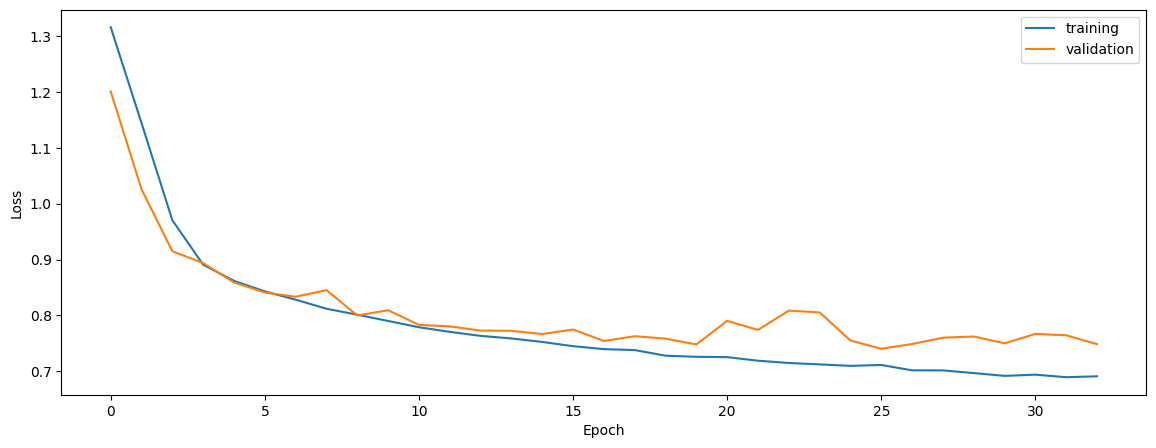

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7153907423093212
0.7101671144121365
0.712058085915379


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized
0.7166195206382737
0.713626992264987
0.7112378446368565


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.7134926410245274
0.7176337460346424
0.7147105235715564


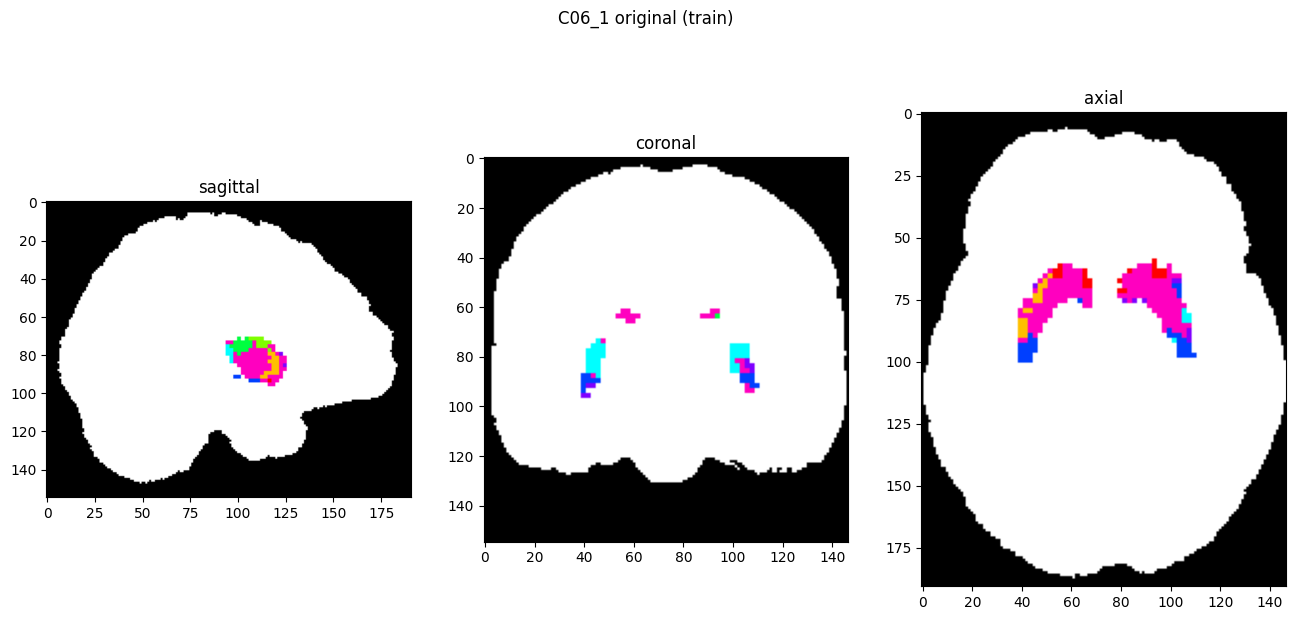

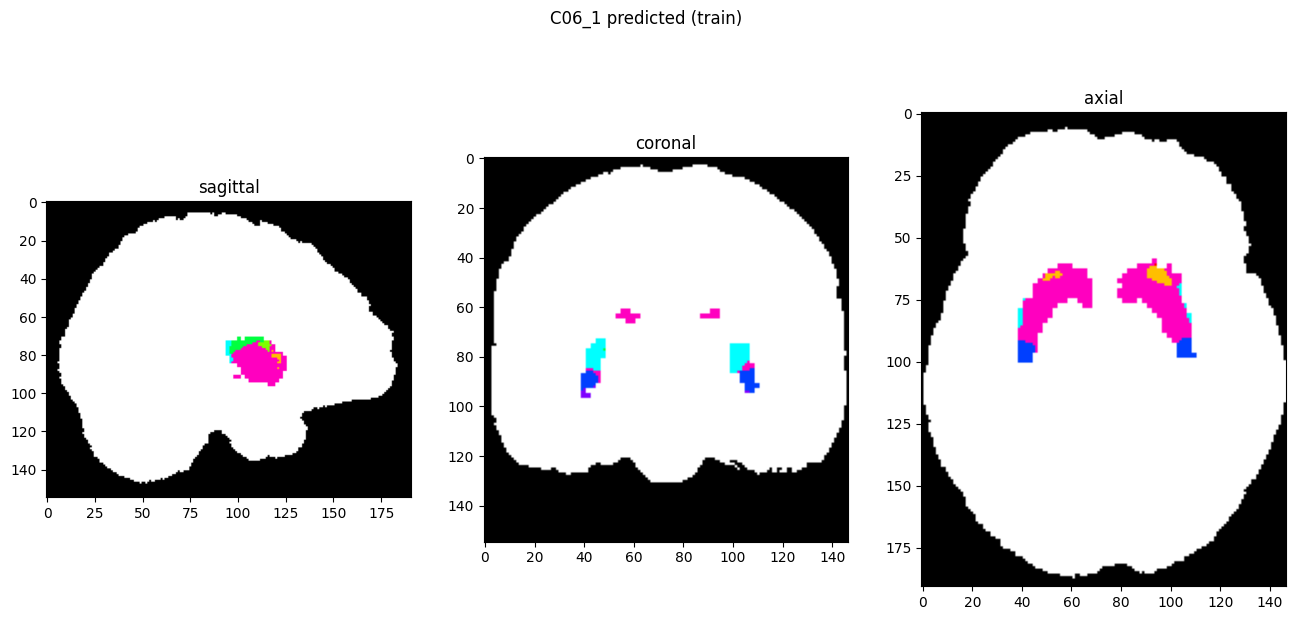

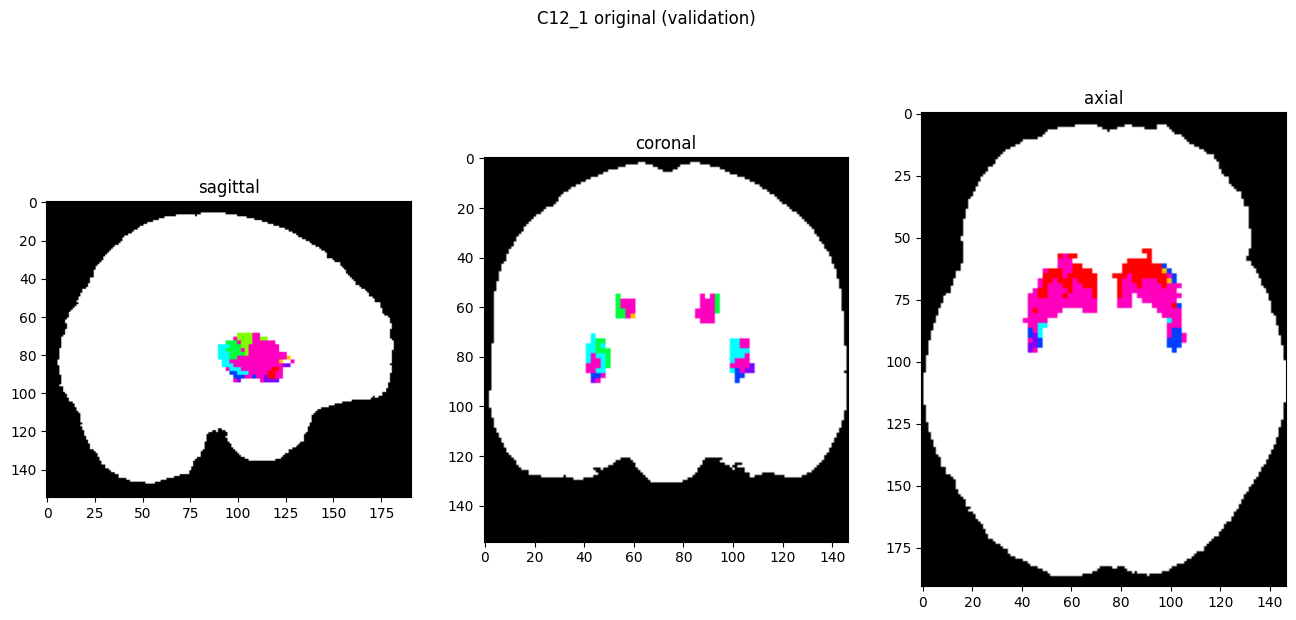

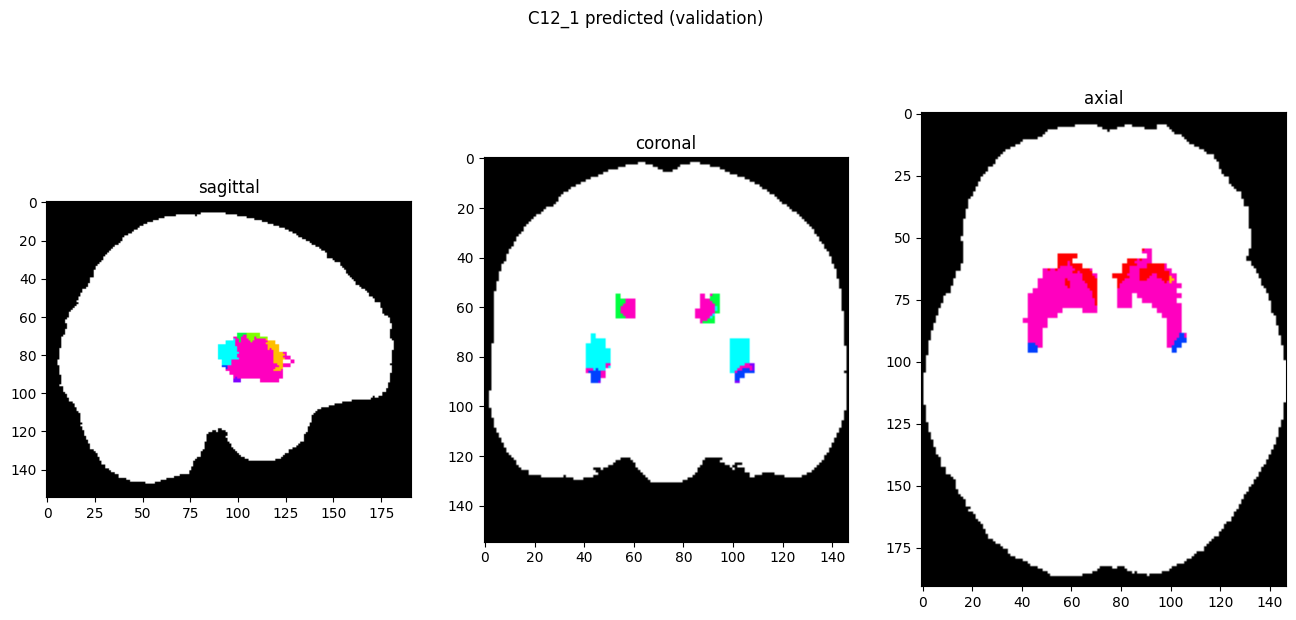

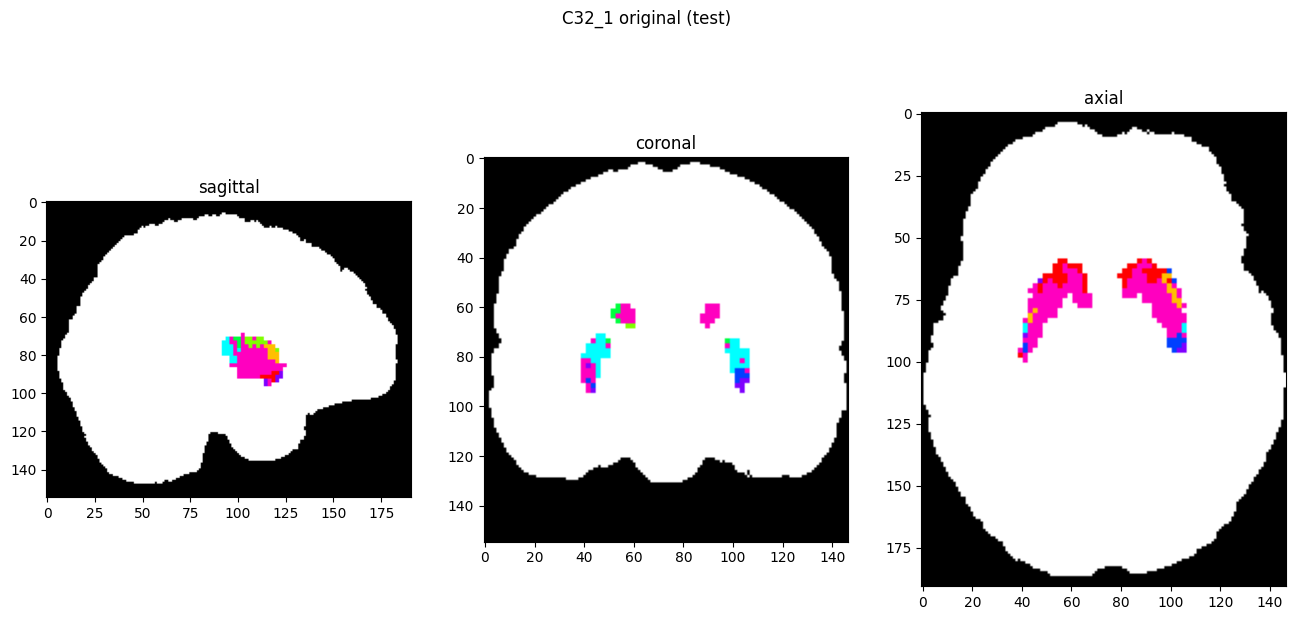

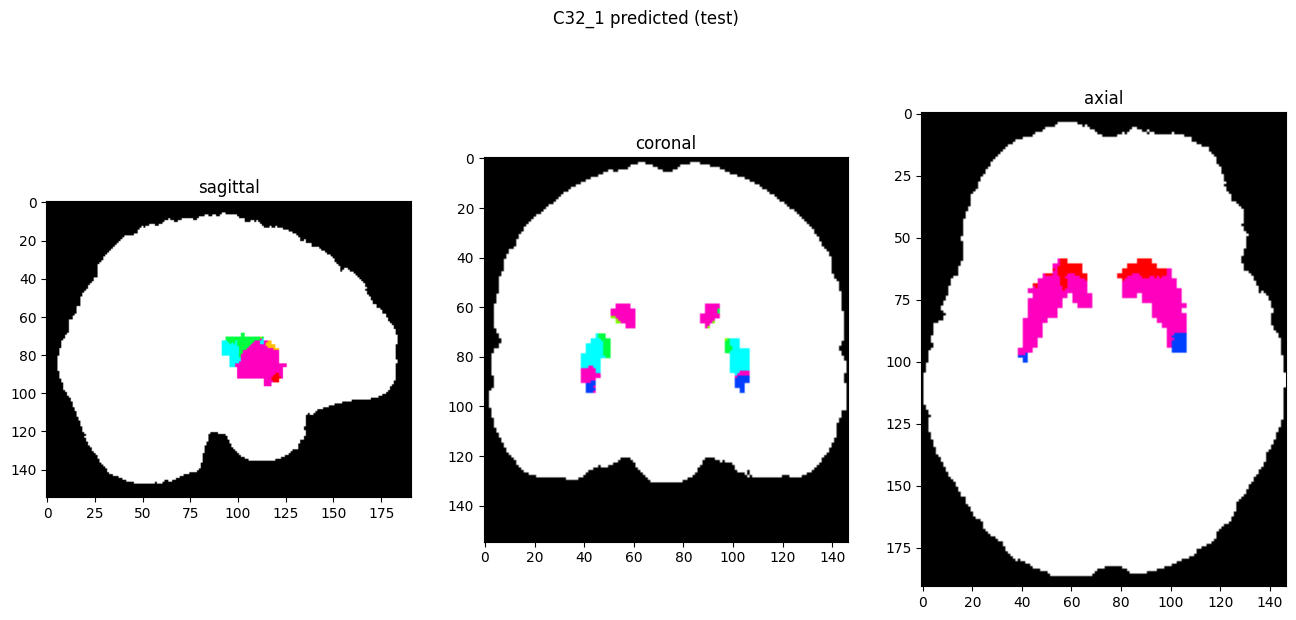

In [10]:
showResults(model, gen, threshold=0)